In [15]:
import numpy as np
import pandas
import torch
import neuralnetworks_torch as nntorch
import os
import time
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import scipy
from scipy.spatial.distance import cosine as cos_dist

In [16]:
class CNN1D(torch.nn.Module):

    def __init__(self, n_inputs, n_channels, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                 patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu'):

        super().__init__()

        self.device = device

        n_conv_layers = len(n_hiddens_per_conv_layer)
        if (len(patch_size_per_conv_layer) != n_conv_layers
            or len(stride_per_conv_layer) != n_conv_layers):
            raise Exception('The lengths of n_hiddens_per_conv_layer, patch_size_per_conv_layer, and stride_per_conv_layer must be equal.')

        self.activation_function = torch.tanh if activation_function == 'tanh' else torch.relu

        self.make_conv_and_fc_layers(n_inputs, n_channels, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                     patch_size_per_conv_layer, stride_per_conv_layer)
        
        self.Xmeans = None
        self.to(self.device)

    def make_conv_and_fc_layers(self, n_inputs, n_channels, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer,
                                n_outputs, patch_size_per_conv_layer, stride_per_conv_layer):
        # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = n_channels
        input_hw = n_inputs  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv1d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            print(input_hw,patch_size,stride,conv_layer_output_hw)
            if conv_layer_output_hw <= 0:
                raise Exception(f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1
           
        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

    def forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Ys = [X]
        for conv_layer in self.conv_layers:
            Ys.append(self.activation_function(conv_layer(Ys[-1])))

        flattened_input = Ys[-1].reshape(n_samples, -1)

        for layeri, fc_layer in enumerate(self.fc_layers[:-1]):
            if layeri == 0:
                Ys.append(self.activation_function(fc_layer(flattened_input)))
            else:
                Ys.append(self.activation_function(fc_layer(Ys[-1])))

        if len(self.fc_layers) == 1:
            # only the output layer
            Ys.append(self.fc_layers[-1](flattened_input))
        else:
            Ys.append(self.fc_layers[-1](Ys[-1]))

        return Ys

    def forward(self, X):
        Ys = self.forward_all_outputs(X)
        return Ys[-1]

    def train(self, X, T, batch_size, n_epochs, learning_rate, method='sgd', verbose=True):
        '''X and T must be numpy arrays'''

        self.classes = np.unique(T)
        T = np.arange(len(self.classes))[np.where(T.reshape(-1, 1) == self.classes)[1]]

        # Set data matrices to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        T = torch.from_numpy(T).long().to(self.device)  # required for classification in pytorch

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing

        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        
        X.requires_grad_(True)

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        CELoss = torch.nn.CrossEntropyLoss(reduction='mean')
        self.error_trace = []

        for epoch in range(n_epochs):

            num_batches = X.shape[0] // batch_size
            loss_sum = 0

            for k in range(num_batches):
                start = k * batch_size
                end = (k + 1) * batch_size
                X_batch = X[start:end, ...]
                T_batch = T[start:end, ...]

                Y = self.forward(X_batch)

                loss = CELoss(Y, T_batch)
                loss.backward()

                # Update parameters
                optimizer.step()
                optimizer.zero_grad()

                loss_sum += loss

            self.error_trace.append(loss_sum / num_batches)

            if verbose and (epoch + 1) % (max(1, n_epochs // 10)) == 0:
                print(f'{method}: Epoch {epoch + 1} Loss {self.error_trace[-1]:.3f}')

        return self

    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1, 1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y

    def use(self, X):
        # Set input matrix to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        # Calculate output of net for all samples in X
        Y = self.forward(X)
        # Convert output to class probabilities
        probs = self.softmax(Y)
        # For each sample pick highest probability and translate that to class labels
        classes = self.classes[torch.argmax(probs, axis=1).cpu().numpy()].reshape(-1, 1)
        return classes, probs.detach().cpu().numpy()

In [17]:
def pad(data):
    eps = np.unique(data[:,0])
    samples = data
    padded = samples.copy()
    for i in eps:
        count = np.count_nonzero(samples[:,0] == i)
        if count < 10:
            max_idx = np.max(np.where(padded[:,0] == i)[0])
            #print(i,10-count,max_idx)
            for j in range(10-count):
                #print("Inserting %s at %s" % (padded[max_idx][0], max_idx+1+j))
                padded = np.insert(padded,max_idx+1+j,padded[max_idx],axis=0)
                #print(j,padded.shape)
                
    return padded

In [18]:
def make_train_test_data(classes, crop_len, feature_idxs):
    subset = crop_len

    Xtrain = np.vstack([train_data[c][:subset] for c in classes])[:,feature_idxs]
    Ttrain = np.vstack([train_data[c][:subset] for c in classes])[:,1]
    Xtrain = Xtrain.reshape(Xtrain.shape[0],-1)

    Xtest = np.vstack([test_data[c] for c in classes])[:,feature_idxs]
    Ttest = np.vstack([test_data[c] for c in classes])[:,1]

    n_channels = Xtrain.shape[1]
    print(Xtrain.shape,Ttrain.shape,Xtest.shape,Ttest.shape)

    Xtrain = Xtrain.flatten().reshape(-1,int(Xtrain.shape[1]*10)) # group into 10s
    Ttrain = np.max(Ttrain.flatten().reshape(-1,10), axis=1)

    Xtest = Xtest.flatten().reshape(-1,int(Xtest.shape[1]*10))
    Ttest = np.max(Ttest.flatten().reshape(-1,10), axis=1)
    print(Xtrain.shape,Ttrain.shape,Xtest.shape,Ttest.shape)

    Xtrain = Xtrain.reshape(-1,1,n_channels*10)
    Xtest = Xtest.reshape(-1,1,n_channels*10)

    print(Xtrain.shape,Ttrain.shape,Xtest.shape,Ttest.shape)

    return Xtrain,Ttrain,Xtest,Ttest

In [19]:
def train_classifier(X, T, n_classes, pretrained=None):
    gpu = True
    device = 'cpu'
    if gpu:
        if not torch.cuda.is_available():
            print("CUDA not available. Defaulting to CPU.")
        else:
            device = 'cuda:0'

    n_channels = X.shape[-1]//10
    
    cnn1d = CNN1D(n_channels*10, 1, [256, 128], [64, 64], n_classes, [n_channels, 4], [8, 2], device=device)
    
    #print(cnn1d.fc_layers[0].weight)
    
    if pretrained is not None:
        with torch.no_grad():
            for i in range(len(pretrained[0])):
                #print("Replacing %s with %s" % (cnn1d.conv_layers[i].weight,\
                #                                torch.nn.Parameter(pretrained[0][i])))
                cnn1d.conv_layers[i].weight = torch.nn.Parameter(pretrained[0][i])
            for i in range(len(pretrained[1])):
                #print("Replacing %s with %s" % (cnn1d.fc_layers[i].weight,\
                #                                torch.nn.Parameter(pretrained[1][i])))
                cnn1d.fc_layers[i].weight = torch.nn.Parameter(pretrained[1][i])

    n_epochs = 500
    batch_size = 100
    learning_rate = 0.001

    cnn1d.train(X, T, batch_size, n_epochs, learning_rate, method='adam')
    
    #print(cnn1d.fc_layers[0].weight)
    
    return cnn1d

In [20]:
# try some new data
# (load all samples from padded_data because we don't care about a balanced set for testing on new object types)
# 2 = cylinders (3 = capsules; 4 = small cubes)
def compare_classes(model, n_channels, novelty_threshold=25):
    novelty = []
    dissimilarities = []
    for i in range(5):
        new_data_class = i
        Xnew = np.vstack([padded_data[new_data_class]])[:,feature_idxs]
        Xnew = Xnew.flatten().reshape(-1,int(Xnew.shape[1]*10))
        Xnew = Xnew.reshape(-1,1,n_channels*10)

        print("New class:", new_data_class)

        # get most similar class
        classes, _ = model.use(Xnew)
        most_similar_class = int(scipy.stats.mode(classes).mode.item())
        print("Most similar class:", most_similar_class)

        # get embedding vectors of the new samples
        newYs = model.forward_all_outputs(torch.from_numpy(Xnew).float())
        new_logits = newYs[-2].detach().numpy()

        #print(np.var(new_logits, axis=0))
        #print(np.var(new_logits, axis=0).shape)
        #print("New data vector variance:", np.sum(np.var(new_logits, axis=0)))

        # get embedding vectors of the known class samples
        Xsim = np.vstack([padded_data[most_similar_class]])[:,feature_idxs]
        Xsim = Xsim.flatten().reshape(-1,int(Xsim.shape[1]*10))
        Xsim = Xsim.reshape(-1,1,n_channels*10)

        simYs = model.forward_all_outputs(torch.from_numpy(Xsim).float())
        sim_logits = simYs[-2].detach().numpy()

        #print(np.mean(new_logits, axis=0))
        #print(np.mean(sim_logits, axis=0))
        new_mean = np.mean(new_logits, axis=0)
        sim_mean = np.mean(sim_logits, axis=0)
        #print(new_mean-sim_mean)

        new_std = np.std(new_logits, axis=0)
        sim_std = np.std(sim_logits, axis=0)
        #print(sim_variance)

        print("Angle from sim_mean to sim_mean+std:",cos_dist(sim_mean,sim_mean+sim_std))
        #print("Angle from sim_mean to sim_mean-var:",cos_dist(sim_mean,sim_mean-sim_variance))
        print("Angle from sim_mean to new_mean:", cos_dist(sim_mean,new_mean))
        #print("Angle from new_mean to new_mean+std:", cos_dist(new_mean,new_mean+new_std))
        #print("Angle from sim_mean to new_mean+std:", cos_dist(sim_mean,new_mean+new_std))
        #print("Angle from sim_mean to new_mean-std:", cos_dist(sim_mean,new_mean-new_std))
        #min_diff_angle = np.min([cos_dist(sim_mean,new_mean+new_std),cos_dist(sim_mean,new_mean-new_std)])
        #max_diff_angle = np.max([cos_dist(sim_mean,new_mean+new_std),cos_dist(sim_mean,new_mean-new_std)])
        #print("Max angle from sim_mean to new_mean+/-std", max_diff_angle)
        #print("Max angle/angle from sim_mean to sim_mean+std:", max_diff_angle/cos_dist(sim_mean,sim_mean+sim_std))
        print("Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std:",\
              cos_dist(sim_mean,new_mean)/cos_dist(sim_mean,sim_mean+sim_std))
        likely_novel_class = cos_dist(sim_mean,new_mean)/cos_dist(sim_mean,sim_mean+sim_std) > 0
        #print(likely_novel_class)

        outlier_threshold = 1
        z_threshold = 3
        
        new_outliers = []
        for i in range(len(new_logits)):
            if cos_dist(sim_mean,new_logits[i])/cos_dist(sim_mean,sim_mean+sim_std) > outlier_threshold:
                #print(i,cos_dist(sim_mean,new_logits[i])/cos_dist(sim_mean,sim_mean+sim_std))
                new_outliers.append(cos_dist(sim_mean,new_logits[i])/cos_dist(sim_mean,sim_mean+sim_std))
        #print(len(new_outliers))
        #print(np.mean([new_outliers]),np.std([new_outliers]))
        new_outliers_pruned = []
        for i in range(len(new_outliers)):
            if (new_outliers[i]-np.mean([new_outliers]))/np.std([new_outliers]) < z_threshold:
                #print(new_outliers[i])
                new_outliers_pruned.append(new_outliers[i])
        #print(len(new_outliers_pruned))
        #print()
        
        sim_outliers = []
        for i in range(len(sim_logits)):
            if cos_dist(sim_mean,sim_logits[i])/cos_dist(sim_mean,sim_mean+sim_std) > outlier_threshold:
                #print(i,cos_dist(sim_mean,sim_logits[i])/cos_dist(sim_mean,sim_mean+sim_std))
                sim_outliers.append(cos_dist(sim_mean,sim_logits[i])/cos_dist(sim_mean,sim_mean+sim_std))
        #print(len(sim_outliers))
        #print(np.mean([sim_outliers]),np.std([sim_outliers]))
        sim_outliers_pruned = []
        for i in range(len(sim_outliers)):
            if (sim_outliers[i]-np.mean([sim_outliers]))/np.std([sim_outliers]) < z_threshold:
                #print(sim_outliers[i])
                sim_outliers_pruned.append(sim_outliers[i])
        #print(len(sim_outliers_pruned))
                
        #print(np.sum(new_outliers_pruned),np.sum(sim_outliers_pruned))
        outlier_ratio = np.sum(new_outliers_pruned)/np.sum(sim_outliers_pruned) \
              if np.sum(sim_outliers_pruned) > 0 else float('inf')
        print("Outlier ratio:",outlier_ratio)
        likely_novel_class = (outlier_ratio == float('inf')) if likely_novel_class else likely_novel_class
        
        dissimilarity = outlier_ratio*cos_dist(sim_mean,new_mean)/cos_dist(sim_mean,sim_mean+sim_std)*\
        np.sum(sim_outliers_pruned)
        print("Dissimilarity from most similar class:", dissimilarity)

        likely_novel_class = (dissimilarity > novelty_threshold) if not likely_novel_class else likely_novel_class
        print("Likely novel class:",likely_novel_class)
        
        print()
        
        dissimilarities.append(dissimilarity)
        novelty.append(likely_novel_class)
        
    return novelty,dissimilarities

Column key:
* Column 1 is the episode number.
* Column 2 is the theme object;  0 = big cube, 1 = sphere, 2 = cylinder, 3 = capsule, 4 = small cube.
* Column 3 is the destination object.  Always 0 because we were always stacking on a cube.
* Columns 4-6 are the rotation (4 = X; 5 = Y; 6 = Z) of the theme object at the start of the trial, in radians.
* Column 7 is the angle, theta (in radians), between the vertical upright axis in world space (0,1,0), and the normalized intrinsic upward axis of the theme object at the start of the trial.
* Columns 8, 9 are the 2-dimensions of the action that was executed.
* Columns 10-12 are the rotation of the theme object after the action was completed (same convention as 4-6), in radians.
* Column 13 is the theta angle, as in 7, but after action was completed.
* Column 14-16 is the "jitter" force applied to the object after placement (to simulate release)
* Columns 17-19 is the center of the theme object (after action completion)
* Columns 20-22 is the size of the theme object
* Column 23-25 is the observation after action completion. Here I’m using height and center of gravity so it takes up 3 columns
* Column 26 is the reward. With this model, the agent gets -1 for missing the destination object entirely, 9 for touching the destination object but the theme falls off, and up to 1000 for successful stacking (1000 on the first try, -100 for each additional attempt).
* Column 27 is the cumulative reward over the episode.
* Column 28 is the mean reward over the episode.

In [21]:
# load up data
data = {}
data[0] = pandas.read_csv('trial-data/122921-2cubes.csv', header=None)
data[0] = data[0][data[0].iloc[:,1] == 0]

data[1] = pandas.read_csv('trial-data/122921-cube_sphere.csv', header=None)
data[1] = data[1][data[1].iloc[:,1] == 1]

data[2] = pandas.read_csv('trial-data/122921-cube_cylinder.csv', header=None)
data[2] = data[2][data[2].iloc[:,1] == 2]

data[3] = pandas.read_csv('trial-data/122921-cube_capsule.csv', header=None)
data[3] = data[3][data[3].iloc[:,1] == 3]

data[4] = pandas.read_csv('trial-data/122921-bigcube_smallcube.csv', header=None)
data[4] = data[4][data[4].iloc[:,1] == 4]

In [22]:
# pad data
padded_data = {}
padded_data[0] = pad(data[0].to_numpy())
padded_data[1] = pad(data[1].to_numpy())
padded_data[2] = pad(data[2].to_numpy())
padded_data[3] = pad(data[3].to_numpy())
padded_data[4] = pad(data[4].to_numpy())

test_n = 100 # 100 test samples of each class

# split train and test
test_data = {}
test_data[0] = padded_data[0][-test_n:]
test_data[1] = padded_data[1][-test_n:]
test_data[2] = padded_data[2][-test_n:]
test_data[3] = padded_data[3][-test_n:]
test_data[4] = padded_data[4][-test_n:]

crop_len = min([len(padded_data[k]) for k in padded_data])-test_n

print(crop_len)

train_data = {}
train_data[0] = padded_data[0][:crop_len]
train_data[1] = padded_data[1][:crop_len]
train_data[2] = padded_data[2][:crop_len]
train_data[3] = padded_data[3][:crop_len]
train_data[4] = padded_data[4][:crop_len]

for k in train_data:
    print(train_data[k].shape,train_data[k])

900
(900, 28) [[   3.    0.    0. ... 1000. 1000. 1000.]
 [   3.    0.    0. ... 1000. 1000. 1000.]
 [   3.    0.    0. ... 1000. 1000. 1000.]
 ...
 [  92.    0.    0. ... 1000. 1000. 1000.]
 [  92.    0.    0. ... 1000. 1000. 1000.]
 [  92.    0.    0. ... 1000. 1000. 1000.]]
(900, 28) [[ 3.        1.        0.       ...  9.        9.        9.      ]
 [ 3.        1.        0.       ...  9.       18.        9.      ]
 [ 3.        1.        0.       ... -1.       17.        5.666667]
 ...
 [92.        1.        0.       ...  9.       62.        7.75    ]
 [92.        1.        0.       ... -1.       61.        6.777778]
 [92.        1.        0.       ... -1.       60.        6.      ]]
(900, 28) [[   3.    2.    0. ... 1000. 1000. 1000.]
 [   3.    2.    0. ... 1000. 1000. 1000.]
 [   3.    2.    0. ... 1000. 1000. 1000.]
 ...
 [  92.    2.    0. ...  800.  798.  266.]
 [  92.    2.    0. ...  800.  798.  266.]
 [  92.    2.    0. ...  800.  798.  266.]]
(900, 28) [[ 3.        3.     

# A: Given cube and sphere

Test for the ability to infer the existence of cylinder and capsule as distinct classes while not splitting small cube from big cube.

========== Experiment 1 ==========
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0022259950637817383
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0032982826232910156
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: inf
Dissimi

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.0022259950637817383
Angle from sim_mean to new_mean: 8.404254913330078e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.003775504739463396
Outlier ratio: 16.481377757110497
Dissimilarity from most similar class: 56.46960093349414
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0032982826232910156
Angle from sim_mean to new_mean: 0.008459627628326416
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 2.56485832008096
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0022259950637817383
Angle from sim_mean to new_mean: 1.7881393432617188e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 8.032988807368929e-05
Outlier ratio: 4.8429705005331725
Dissimilarity from most similar class: 0.35304915041682705
Likely novel class: False

========== Experiment 2 ==========
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.002156674861907959
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from si

Angle from sim_mean to sim_mean+std: 0.0010260343551635742
Angle from sim_mean to new_mean: 7.152557373046875e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0006971070059254096
Outlier ratio: 3.80702459948744
Dissimilarity from most similar class: 3.746840006328796
Likely novel class: False

========== Experiment 6 ==========
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0004897713661193848
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.

Angle from sim_mean to sim_mean+std: 0.0015363097190856934
Angle from sim_mean to new_mean: 5.960464477539062e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0003879728419010669
Outlier ratio: 4.521886968517359
Dissimilarity from most similar class: 2.1463032754729476
Likely novel class: False

========== Experiment 10 ==========
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0007326602935791016
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std:

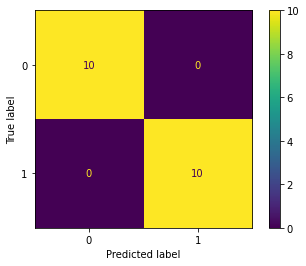

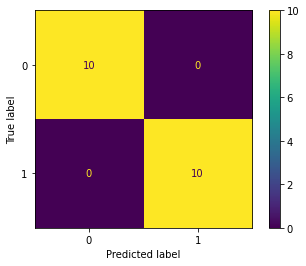

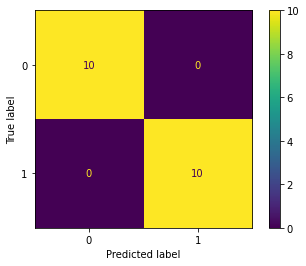

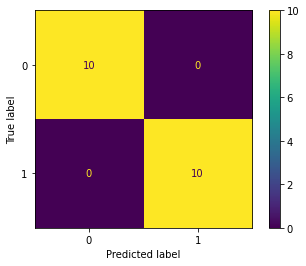

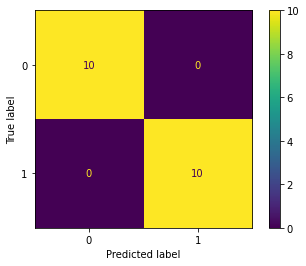

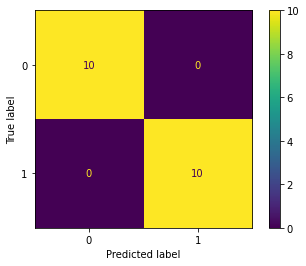

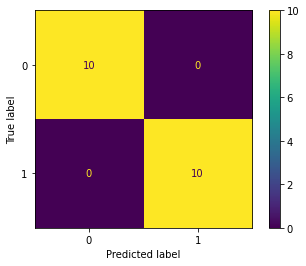

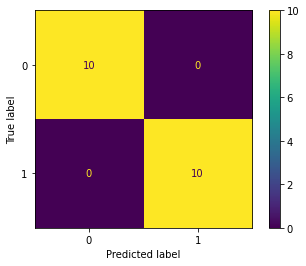

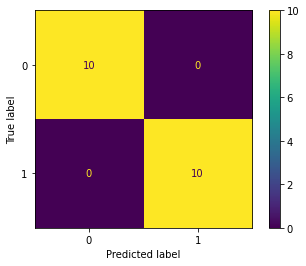

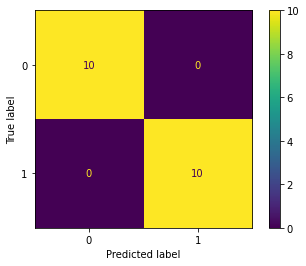

In [23]:
ground_truth = [False, False, True, True, False]
novelty_judgments = []
n_exps = 10

for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    
    feature_idxs = [*range(3,16),*range(22,28)] 
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1], crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, 2)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    novelty_judgments.append(novel_classes)
    
novelty_judgments = np.array(novelty_judgments).reshape(n_exps,-1).T

pred_acc = []
for i in range(2,len(ground_truth)):
    pred_acc.append(np.sum(novelty_judgments[i] == ground_truth[i])/n_exps)
    print(ground_truth[i], novelty_judgments[i], pred_acc[-1])
    
print(pred_acc, np.mean(pred_acc))

# B: Given cube, sphere, and cylinder

Test for the ability to infer the existence of capsule as a distinct class while not splitting small cube from big cube.

========== Experiment 1 ==========
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.061
adam: Epoch 100 Loss 0.021
adam: Epoch 150 Loss 0.004
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0021753907203674316
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0019460320472717285
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimi

adam: Epoch 50 Loss 0.055
adam: Epoch 100 Loss 0.020
adam: Epoch 150 Loss 0.005
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.016221702098846436
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.012523651123046875
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.027739882469177246
Angle from sim_mean to new_mean: 0.0
Angle from sim_m

adam: Epoch 50 Loss 0.058
adam: Epoch 100 Loss 0.019
adam: Epoch 150 Loss 0.006
adam: Epoch 200 Loss 0.003
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0017638206481933594
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0015887618064880371
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.020022988319396973
Angle from sim_mean to new_mean: 0.0
Angle from sim

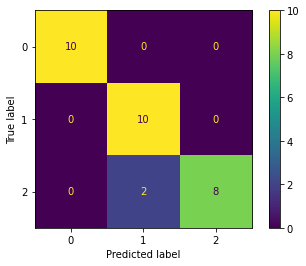

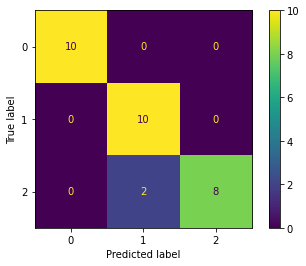

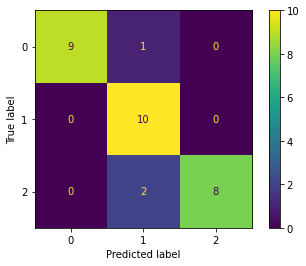

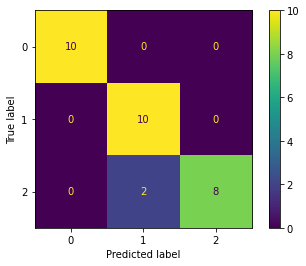

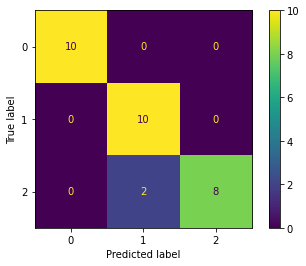

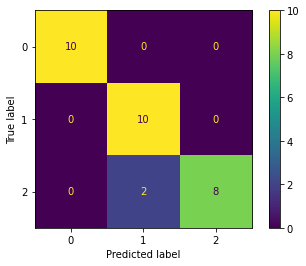

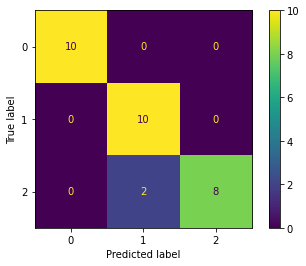

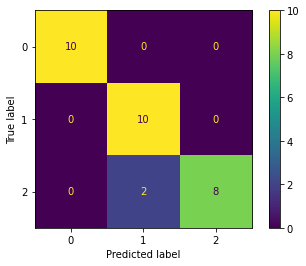

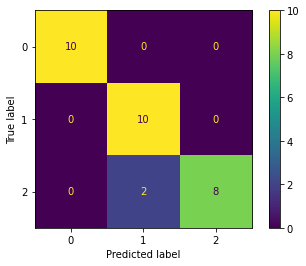

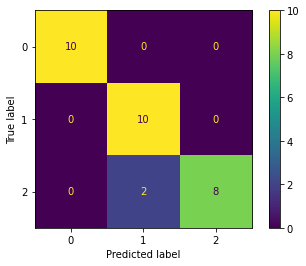

In [24]:
ground_truth = [False, False, False, True, False]
novelty_judgments = []
n_exps = 10

for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))

    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1,2], crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, 3)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    novelty_judgments.append(novel_classes)
    
novelty_judgments = np.array(novelty_judgments).reshape(n_exps,-1).T

pred_acc = []
for i in range(2,len(ground_truth)):
    pred_acc.append(np.sum(novelty_judgments[i] == ground_truth[i])/n_exps)
    print(ground_truth[i], novelty_judgments[i], pred_acc[-1])
    
print(pred_acc, np.mean(pred_acc))

# C: Given cube, sphere, and capsule

Test for the ability to infer the existence of cylinder as a distinct class while not splitting small cube from big cube.

========== Experiment 1 ==========
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.005
adam: Epoch 100 Loss 0.002
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.019071459770202637
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 7.808208465576172e-06
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimil

adam: Epoch 50 Loss 0.006
adam: Epoch 100 Loss 0.002
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.018473148345947266
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 1.2576580047607422e-05
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.018473148345947266
Angle from sim_mean to new_mean: 0.0003628134727478

adam: Epoch 50 Loss 0.007
adam: Epoch 100 Loss 0.002
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01813197135925293
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 1.9848346710205078e-05
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01813197135925293
Angle from sim_mean to new_mean: 0.000512540340423584

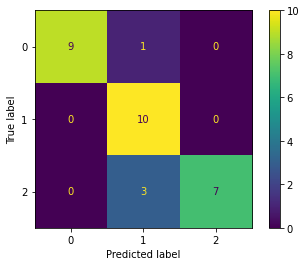

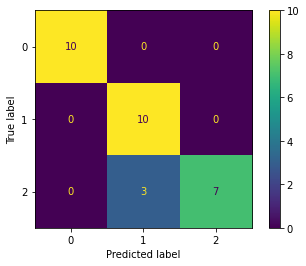

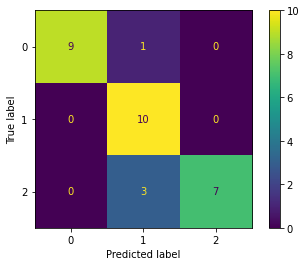

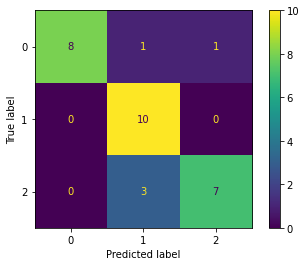

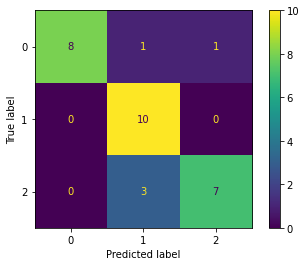

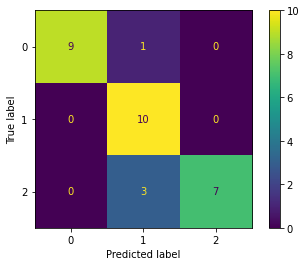

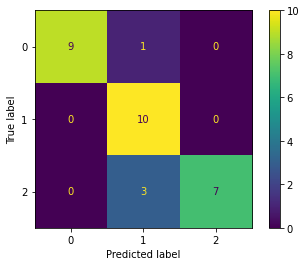

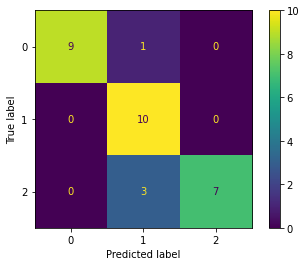

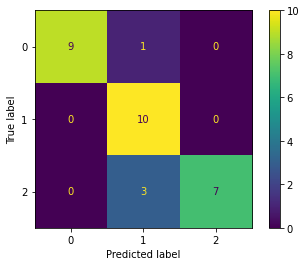

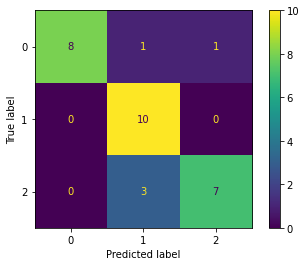

In [25]:
ground_truth = [False, False, True, False, False]
novelty_judgments = []
n_exps = 10

for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    
    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1,3], crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, 3)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    novelty_judgments.append(novel_classes)
    
novelty_judgments = np.array(novelty_judgments).reshape(n_exps,-1).T

pred_acc = []
for i in range(2,len(ground_truth)):
    pred_acc.append(np.sum(novelty_judgments[i] == ground_truth[i])/n_exps)
    print(ground_truth[i], novelty_judgments[i], pred_acc[-1])
    
print(pred_acc, np.mean(pred_acc))

# D: Given cube, sphere, cylinder, and capsule

Test that small cube is not considered to be different from big cube.

========== Experiment 1 ==========
(3600, 19) (3600,) (400, 19) (400,)
(360, 190) (360,) (40, 190) (40,)
(360, 1, 190) (360,) (40, 1, 190) (40,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.033
adam: Epoch 100 Loss 0.008
adam: Epoch 150 Loss 0.004
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.001

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01034998893737793
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.00040477514266967773
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimil

adam: Epoch 50 Loss 0.027
adam: Epoch 100 Loss 0.007
adam: Epoch 150 Loss 0.004
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.016749143600463867
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0014654994010925293
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.05371016263961792
Angle from sim_mean to new_mean: 0.0
Angle from sim_m

adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.011562764644622803
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.00038826465606689453
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.043416380882263184
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+

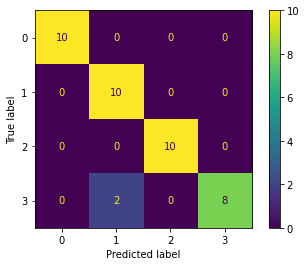

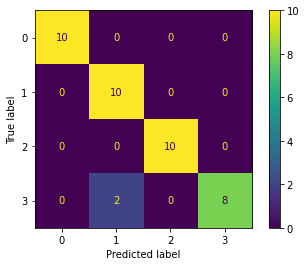

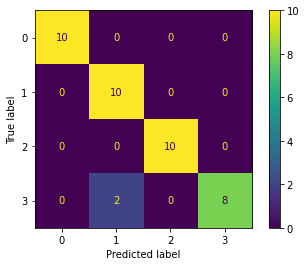

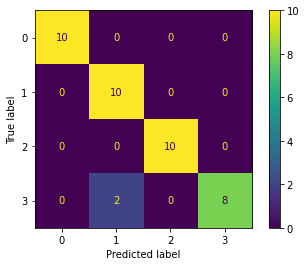

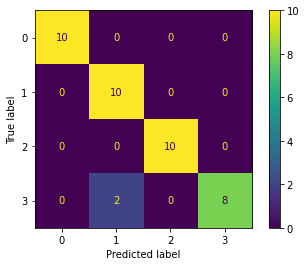

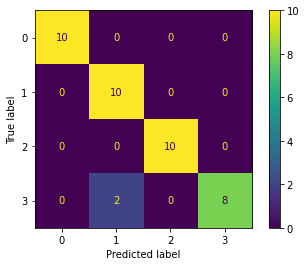

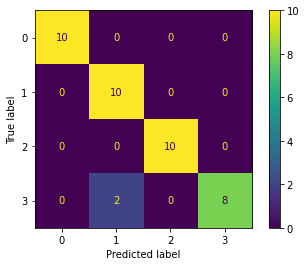

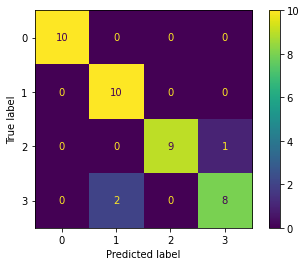

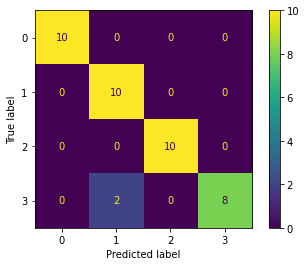

In [26]:
ground_truth = [False, False, False, False, False]
novelty_judgments = []
n_exps = 10

for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    
    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1,2,3], crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, 4)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    novelty_judgments.append(novel_classes)
    
novelty_judgments = np.array(novelty_judgments).reshape(n_exps,-1).T

pred_acc = []
for i in range(2,len(ground_truth)):
    pred_acc.append(np.sum(novelty_judgments[i] == ground_truth[i])/n_exps)
    print(ground_truth[i], novelty_judgments[i], pred_acc[-1])
    
print(pred_acc, np.mean(pred_acc))

# E: Multi-class non-curriculum learning 1

Start with cube and sphere.  After each trial add the class that has inferred to have the *lowest*  dissimilarity from its most similar class *above the novelty threshold*.  Test for the ability to acquire cylinder and capsule as distinct classes while not splitting small cube from big cube.  With each additional class added, the model is retrained from scratch.

========== Experiment 1 ==========
Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0020955801010131836
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.08835023641586304
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlie

adam: Epoch 50 Loss 0.062
adam: Epoch 100 Loss 0.037
adam: Epoch 150 Loss 0.006
adam: Epoch 200 Loss 0.003
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.019896984100341797
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.011600375175476074
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.03382861614227295
Angle from sim_mean to new_mean: 0.0
Angle from sim_me

adam: Epoch 50 Loss 0.030
adam: Epoch 100 Loss 0.008
adam: Epoch 150 Loss 0.004
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.012702703475952148
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0003829002380371094
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.04862493276596069
Angle from sim_mean to new_mean: 0.0
Angle from sim_m

adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0012949109077453613
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.08335351943969727
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0012949109077453613
Angle from sim_mean to new_mean: 1.6570091247558594e

adam: Epoch 50 Loss 0.064
adam: Epoch 100 Loss 0.040
adam: Epoch 150 Loss 0.012
adam: Epoch 200 Loss 0.004
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.003183305263519287
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.009551465511322021
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.021612465381622314
Angle from sim_mean to new_mean: 0.0
Angle from sim_m

adam: Epoch 50 Loss 0.031
adam: Epoch 100 Loss 0.008
adam: Epoch 150 Loss 0.004
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Angle from sim_mean to sim_mean+std: 0.05443805456161499
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0014070868492126465
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.08725249767303467
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.23790031671524048
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean

adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.000883936882019043
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.06924474239349365
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.000883936882019043
Angle from sim_mean to new_mean: 1.3232231140136719e-0

adam: Epoch 50 Loss 0.056
adam: Epoch 100 Loss 0.020
adam: Epoch 150 Loss 0.004
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.006389498710632324
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.003923177719116211
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.02024853229522705
Angle from sim_mean to new_mean: 0.0
Angle from sim_me

adam: Epoch 50 Loss 0.028
adam: Epoch 100 Loss 0.008
adam: Epoch 150 Loss 0.004
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.018407225608825684
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.008508145809173584
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.05421715974807739
Angle from sim_mean to new_mean: 0.0
Angle from sim_me

adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0013179779052734375
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.031763553619384766
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0013179779052734375
Angle from sim_mean to new_mean: 1.633167266845703e

Outlier ratio: 4.836534420498849
Dissimilarity from most similar class: 0.4719289571673766
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 2]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.061
adam: Epoch 100 Loss 0.029
adam: Epoch 150 Loss 0.006
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.00388491153717041
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0011911392211914062
Angle fro

Angle from sim_mean to sim_mean+std: 0.019700467586517334
Angle from sim_mean to new_mean: 0.0002887845039367676
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.014658763943979015
Outlier ratio: 2.347809490697956
Dissimilarity from most similar class: 17.697537653914523
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 3, 2]
(3600, 19) (3600,) (400, 19) (400,)
(360, 190) (360,) (40, 190) (40,)
(360, 1, 190) (360,) (40, 1, 190) (40,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.056
adam: Epoch 100 Loss 0.034
adam: Epoch 150 Loss 0.006
adam: Epoch 200 Loss 0.003
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.001

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.09928405284881592
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_

Angle from sim_mean to sim_mean+std: 0.011591732501983643
Angle from sim_mean to new_mean: 7.587671279907227e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.006545761195411282
Outlier ratio: 1.2195583322900188
Dissimilarity from most similar class: 3.6367027002264902
Likely novel class: False

Known classes: [0, 1, 2, 3]
Order of acquisition: [[0, 1], [0, 1, 2], [0, 1, 2, 3], [0, 1, 2, 3]]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 1.0
========== Experiment 17 ==========
Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.000
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.

Outlier ratio: 13.229299028387933
Dissimilarity from most similar class: 411.9250030570756
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.07833290100097656
Angle from sim_mean to new_mean: 0.24332237243652344
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 3.106260196255083
Outlier ratio: 6.2746761939888716
Dissimilarity from most similar class: 1303.0139063688293
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0013906359672546387
Angle from sim_mean to new_mean: 8.940696716308594e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0006429214350006429
Outlier ratio: 3.903456763264794
Dissimilarity from most similar class: 3.176216228320236
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 2]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available.

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.016295313835144043
Angle from sim_mean to new_mean: 0.0004729032516479492
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.02902081275833059
Outlier ratio: 3.242661386799994
Dissimilarity from most similar class: 66.19995876911973
Likely novel class: True

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.16221052408218384
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.016295313835144043
Angle from sim_mean to new_mean: 0.0002823472023010254
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.017326895643586086
Outlier ratio: 2.117295366868053
Dissimilarity from most similar class: 25.807667495258002
Likely novel class: True

Most novel cla

Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.04208505153656006
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.11764317750930786
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.015697062015533447
Angle from sim_mean to new_mean: 9.244680404663086e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.005889433573948275
Outlier ratio: 1.6324068851909486
Dissimilarity from most similar class: 3.318065163596002
Likely novel class: False

Known classes: [0, 1, 2, 3]
Order of acquisition: [[0, 1], [0, 1, 2], [0, 1

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0008512735366821289
Angle from sim_mean to new_mean: 1.5437602996826172e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.018134715025906734
Outlier ratio: 11.128461550417388
Dissimilarity from most similar class: 303.6543939960659
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.06497633457183838
Angle from sim_mean to new_mean: 0.1637060046195984
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 2.5194712151483962
Outlier ratio: 4.331877994742021
Dissimilarity from most similar class: 691.6483547512132
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0008512735366821289
Angle from sim_mean to new_mean: 3.5762786865234375e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0004201092283993838
Outlier ratio: 4.391678788577938
Dissimilarity from most similar cl

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.024965882301330566
Angle from sim_mean to new_mean: 0.0004035830497741699
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.01616538301763366
Outlier ratio: 2.822843453787309
Dissimilarity from most similar class: 25.8492027407793
Likely novel class: True

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.14011496305465698
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.024965882301330566
Angle from sim_mean to new_mean: 0.00034099817276000977
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.013658566865142842
Outlier ratio: 1.9725514621146174
Dissimilarity from most similar class: 15.261872989380254
Likely novel class: False

Most novel c

Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.0869147777557373
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.21989905834197998
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.02576291561126709
Angle from sim_mean to new_mean: 0.00011879205703735352
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.004610971010804433
Outlier ratio: 2.061769554823849
Dissimilarity from most similar class: 6.06195051612201
Likely novel class: False

Known classes: [0, 1, 2, 3]
Order of acquisition: [[0, 1], [0, 1, 2], [0, 1, 2

Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.18674349784851074
Angle from sim_mean to new_mean: 0.8238740414381027
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 4.411795060765341
Outlier ratio: 34.02613732565727
Dissimilarity from most similar class: 12350.845224737452
Likely novel class: True

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.18674349784851074
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 4
Angle from sim_mean to sim_mean+std: 0.0153961181640625
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

Known classes: [0, 1, 3, 4, 2]
Order of acquisition: [[0, 1], [0, 1, 3], [0, 1, 3], 

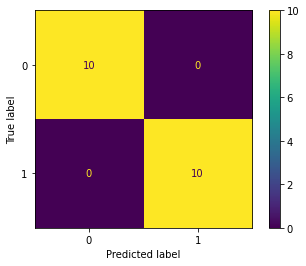

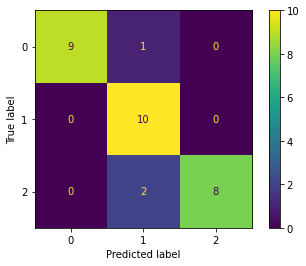

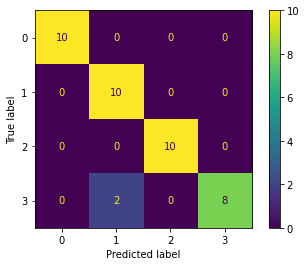

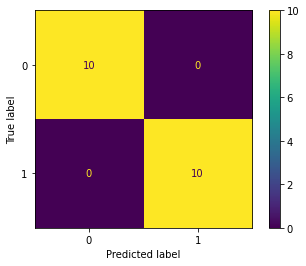

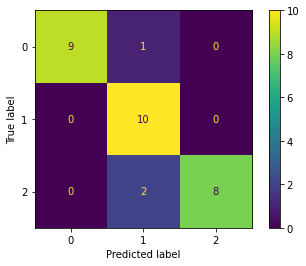

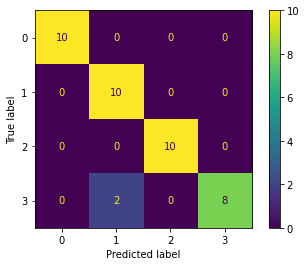

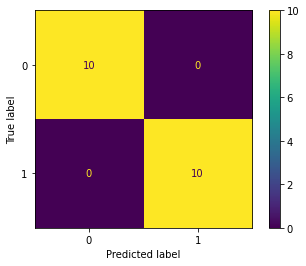

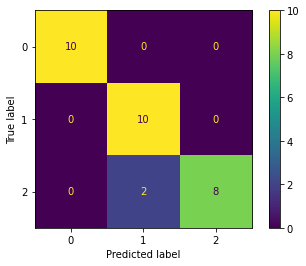

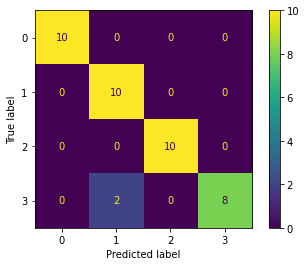

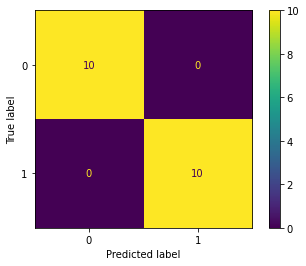

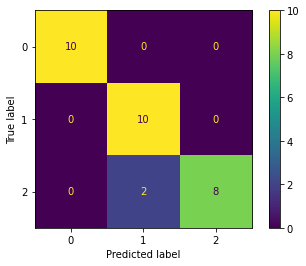

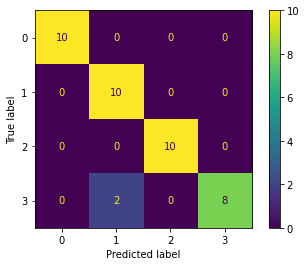

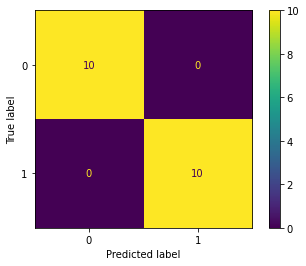

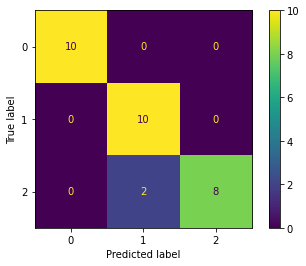

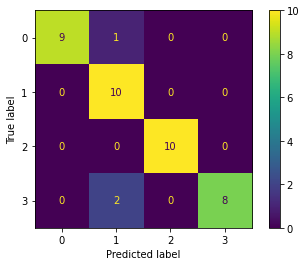

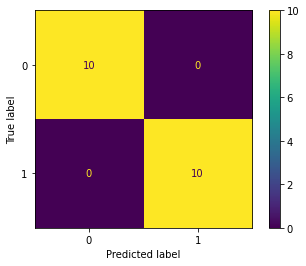

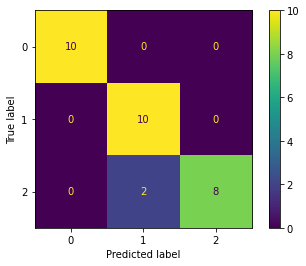

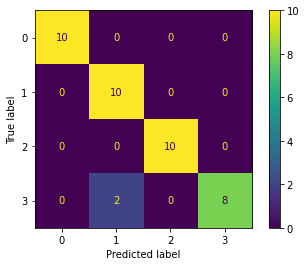

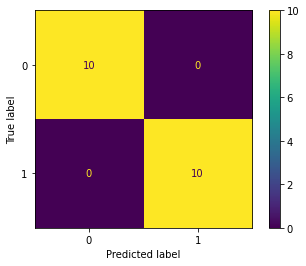

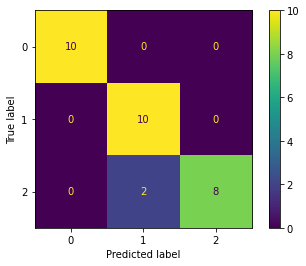

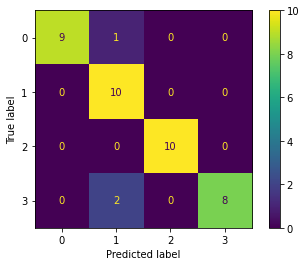

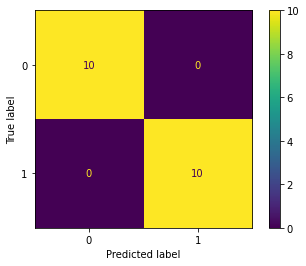

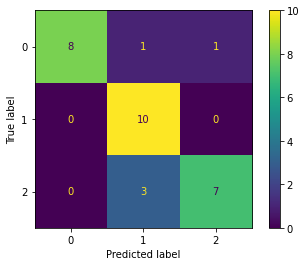

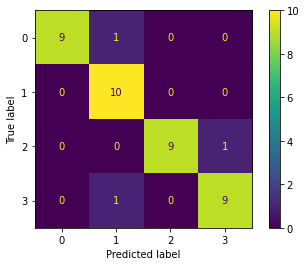

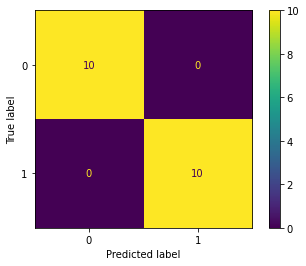

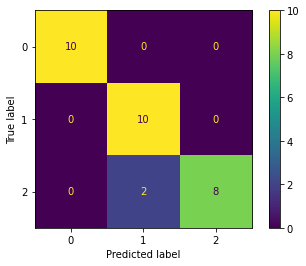

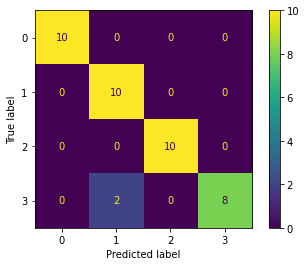

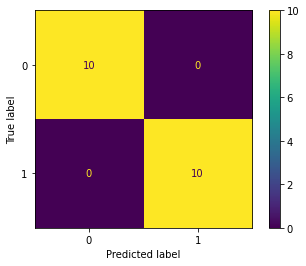

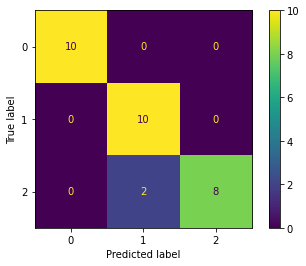

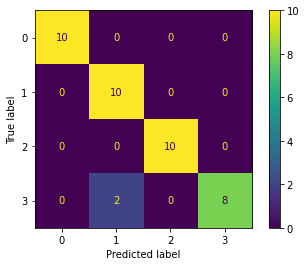

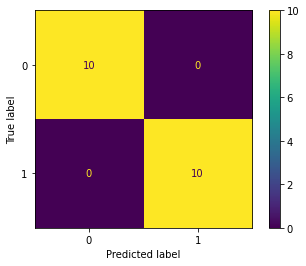

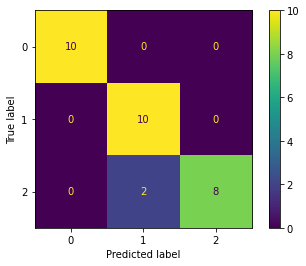

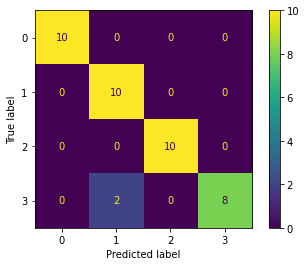

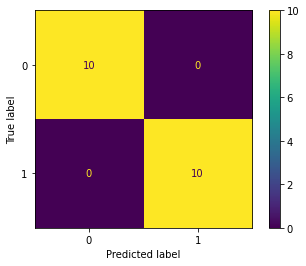

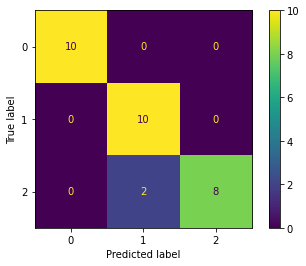

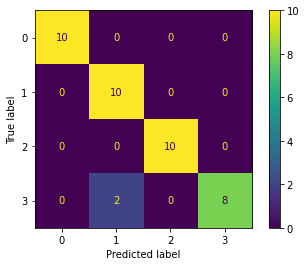

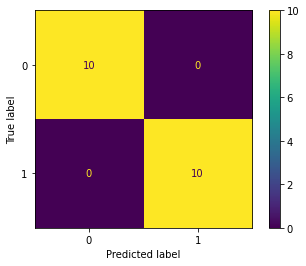

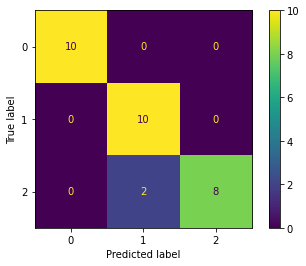

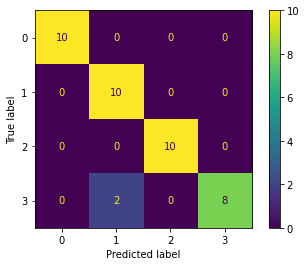

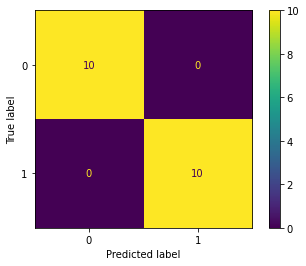

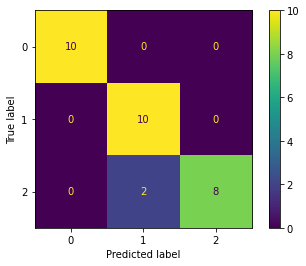

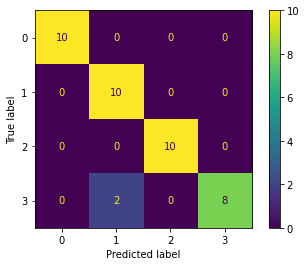

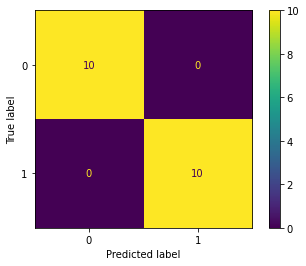

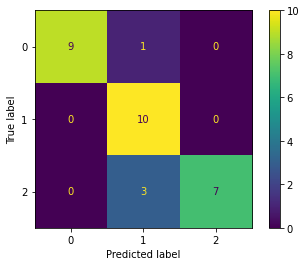

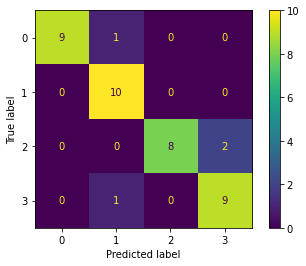

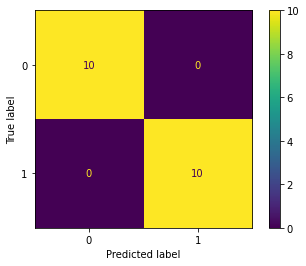

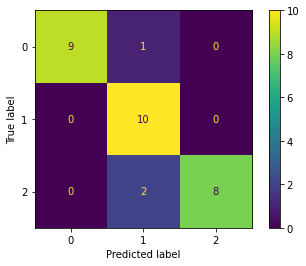

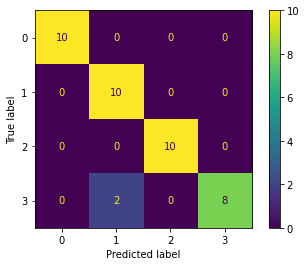

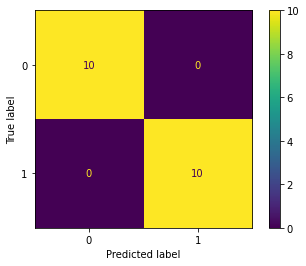

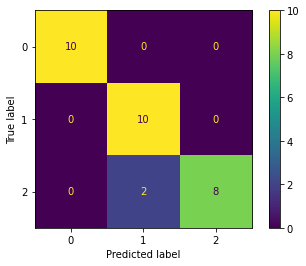

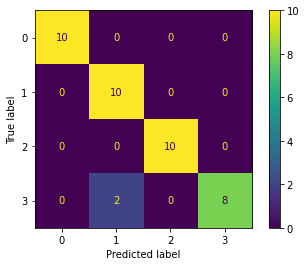

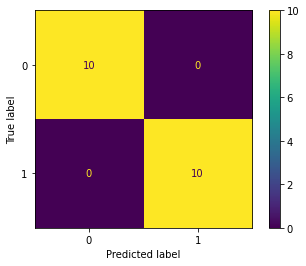

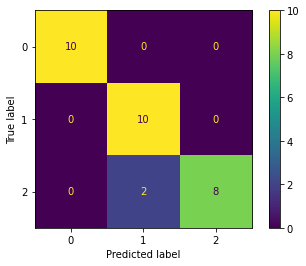

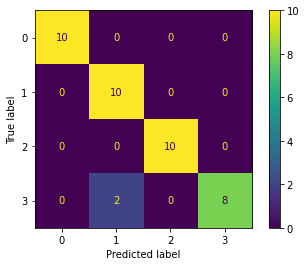

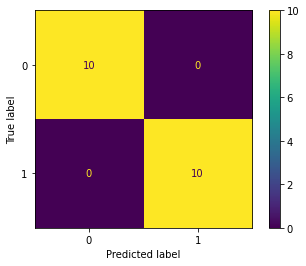

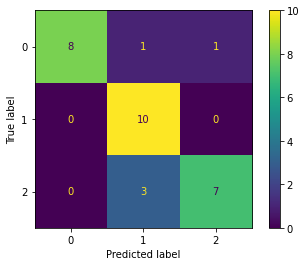

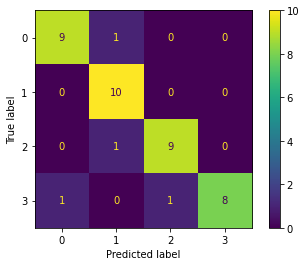

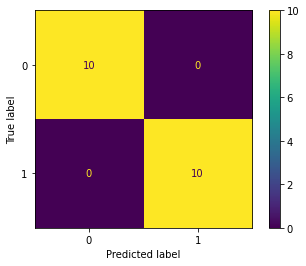

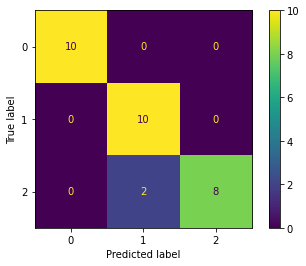

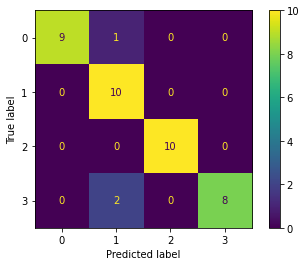

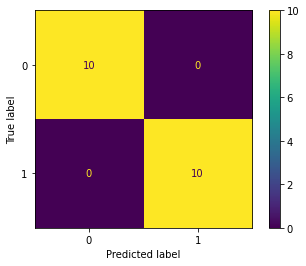

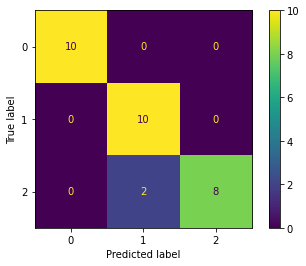

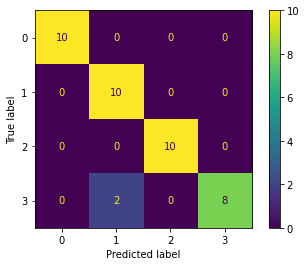

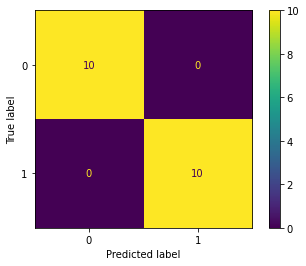

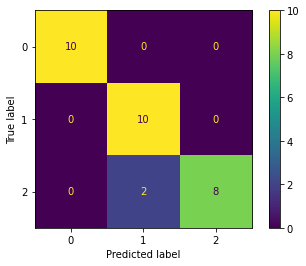

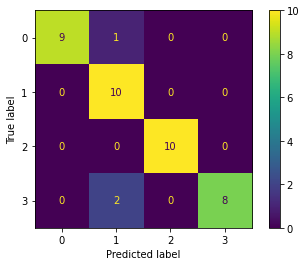

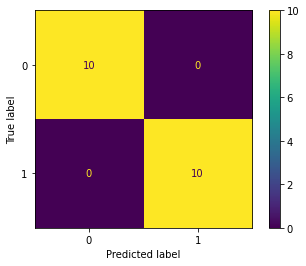

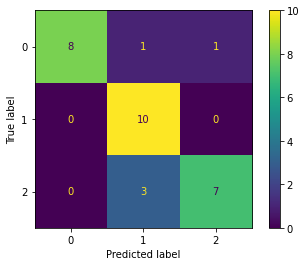

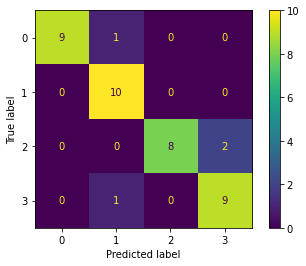

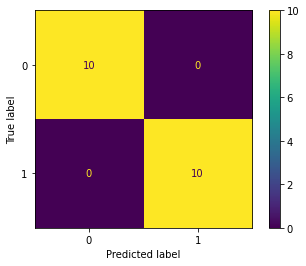

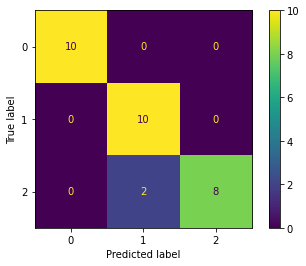

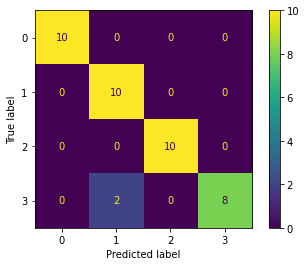

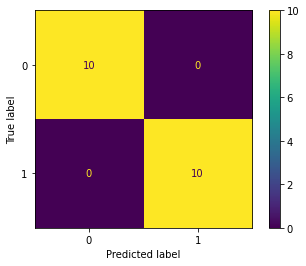

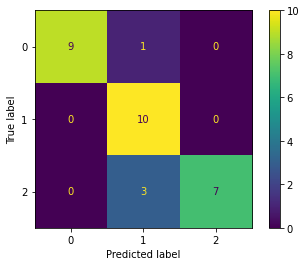

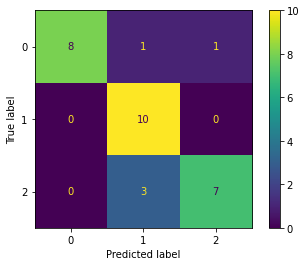

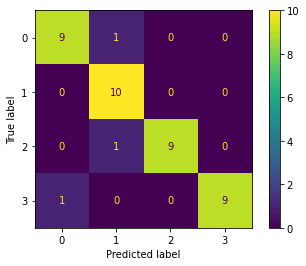

In [27]:
n_exps = 25

ground_truth = [0,1,2,3]

pred_iou = []
for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    known_classes = [0,1]
    known_classes_order = []
    
    model = None
    
    retrains = 0
    while len(known_classes) < len(ground_truth) and retrains < 2:
        print("Known classes:", known_classes)
        known_classes_order.append(known_classes.copy())
        
        feature_idxs = [*range(3,16),*range(22,28)]
        #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
        #feature_idxs = [*range(3,19),*range(22,28)] # with object position
        Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
        print()

        model = train_classifier(Xtrain, Ttrain, len(known_classes))
        print()

        # check classifier on the test data
        classes, probs = model.use(Xtest)

        # make confusion matrix
        cm = sklearn.metrics.confusion_matrix(Ttest, classes)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()

        novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
        gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
            else float('inf') for i in range(len(dissimilarities))]
        
        gated_dissimilarities = [gated_dissimilarities[i] if gated_dissimilarities[i] == gated_dissimilarities[i] \
            else float('inf') for i in range(len(gated_dissimilarities))]
        
        if np.min(gated_dissimilarities) == float('inf'):
            print("No novel class found")
            retrains += 1
            print("Retraining (%s)" % retrains)
        else:
            new_class = np.argmin(gated_dissimilarities)
            known_classes.append(new_class)
            retrains = 0

            print("Most novel class:", known_classes[-1])
        print()
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, len(known_classes))
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
        else float('inf') for i in range(len(dissimilarities))]
    
    gated_dissimilarities = [gated_dissimilarities[i] if gated_dissimilarities[i] == gated_dissimilarities[i] \
        else float('inf') for i in range(len(gated_dissimilarities))]
    
    if np.min(gated_dissimilarities) != float('inf'):
        new_class = np.argmin(gated_dissimilarities)
        known_classes.append(new_class)
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    print("Order of acquisition:", known_classes_order)

    pred_iou.append(np.intersect1d(known_classes[2:],ground_truth[2:]).shape[0]/\
                    np.union1d(known_classes[2:],ground_truth[2:]).shape[0])
    print(pred_iou,pred_iou[-1])
    print()
    
print(np.sum(pred_iou)/len(pred_iou))

# F: Multi-class curriculum learning 1

Start with cube and sphere.  After each trial add the class that has inferred to have the *lowest*  dissimilarity from its most similar class *above the novelty threshold*.  Test for the ability to acquire cylinder and capsule as distinct classes while not splitting small cube from big cube.  With each additional class added, the model is initialized with the trained weights from the previous model (except for the final fully connected layer weights, which are initialized randomly).

========== Experiment 1 ==========
Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.002845585346221924
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0022752881050109863
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outli

adam: Epoch 50 Loss 0.039
adam: Epoch 100 Loss 0.017
adam: Epoch 150 Loss 0.008
adam: Epoch 200 Loss 0.005
adam: Epoch 250 Loss 0.004
adam: Epoch 300 Loss 0.003
adam: Epoch 350 Loss 0.002
adam: Epoch 400 Loss 0.002
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.001

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.05474299192428589
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.013022959232330322
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.050103962421417236
Angle from sim_mean to new_mean: 0.0
Angle from sim_me

adam: Epoch 50 Loss 0.055
adam: Epoch 100 Loss 0.016
adam: Epoch 150 Loss 0.008
adam: Epoch 200 Loss 0.005
adam: Epoch 250 Loss 0.003
adam: Epoch 300 Loss 0.002
adam: Epoch 350 Loss 0.002
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.001

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01986551284790039
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0013149380683898926
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.039724886417388916
Angle from sim_mean to new_mean: 0.0
Angle from sim_m

adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0010684728622436523
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.09929502010345459
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0010684728622436523
Angle from sim_mean to new_mean: 1.9609928131103516e

adam: Epoch 50 Loss 0.067
adam: Epoch 100 Loss 0.018
adam: Epoch 150 Loss 0.008
adam: Epoch 200 Loss 0.005
adam: Epoch 250 Loss 0.004
adam: Epoch 300 Loss 0.003
adam: Epoch 350 Loss 0.002
adam: Epoch 400 Loss 0.002
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.001

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.07100933790206909
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0050209760665893555
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.06953549385070801
Angle from sim_mean to new_mean: 0.0
Angle from sim_me

adam: Epoch 50 Loss 0.078
adam: Epoch 100 Loss 0.018
adam: Epoch 150 Loss 0.008
adam: Epoch 200 Loss 0.005
adam: Epoch 250 Loss 0.003
adam: Epoch 300 Loss 0.002
adam: Epoch 350 Loss 0.002
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.001



/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.010004222393035889
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.00032061338424682617
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.041407644748687744
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.19040846824645996
Angle from sim_mean to new_mea

adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0017269253730773926
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.09233701229095459
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0017269253730773926
Angle from sim_mean to new_mean: 1.2040138244628906e

adam: Epoch 50 Loss 0.078
adam: Epoch 100 Loss 0.044
adam: Epoch 150 Loss 0.023
adam: Epoch 200 Loss 0.011
adam: Epoch 250 Loss 0.006
adam: Epoch 300 Loss 0.004
adam: Epoch 350 Loss 0.003
adam: Epoch 400 Loss 0.003
adam: Epoch 450 Loss 0.002
adam: Epoch 500 Loss 0.002

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.011621177196502686
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.00174635648727417
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.0466427206993103
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean

adam: Epoch 50 Loss 0.057
adam: Epoch 100 Loss 0.021
adam: Epoch 150 Loss 0.010
adam: Epoch 200 Loss 0.005
adam: Epoch 250 Loss 0.003
adam: Epoch 300 Loss 0.002
adam: Epoch 350 Loss 0.002
adam: Epoch 400 Loss 0.002
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.001

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.008845627307891846
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0016236305236816406
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.032702624797821045
Angle from sim_mean to new_mean: 0.0
Angle from sim_

adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0016112327575683594
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.08070611953735352
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0016112327575683594
Angle from sim_mean to new_mean: 1.806020736694336e-

adam: Epoch 50 Loss 0.039
adam: Epoch 100 Loss 0.018
adam: Epoch 150 Loss 0.010
adam: Epoch 200 Loss 0.007
adam: Epoch 250 Loss 0.005
adam: Epoch 300 Loss 0.004
adam: Epoch 350 Loss 0.003
adam: Epoch 400 Loss 0.002
adam: Epoch 450 Loss 0.002
adam: Epoch 500 Loss 0.001

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01838994026184082
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.005051314830780029
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.02124994993209839
Angle from sim_mean to new_mean: 0.0
Angle from sim_mea

adam: Epoch 50 Loss 0.036
adam: Epoch 100 Loss 0.012
adam: Epoch 150 Loss 0.006
adam: Epoch 200 Loss 0.003
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.002
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.001

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.007332324981689453
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0016791820526123047
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.03975975513458252
Angle from sim_mean to new_mean: 0.0
Angle from sim_m

adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0009652376174926758
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.11824649572372437
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0009652376174926758
Angle from sim_mean to new_mean: 8.404254913330078e-

Outlier ratio: 3.6812030776980382
Dissimilarity from most similar class: 0.3806070056491771
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 2]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.053
adam: Epoch 100 Loss 0.022
adam: Epoch 150 Loss 0.009
adam: Epoch 200 Loss 0.005
adam: Epoch 250 Loss 0.004
adam: Epoch 300 Loss 0.003
adam: Epoch 350 Loss 0.002
adam: Epoch 400 Loss 0.002
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.001

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.03358703851699829
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.003840148448944092
Angle fro

Angle from sim_mean to sim_mean+std: 0.01440495252609253
Angle from sim_mean to new_mean: 0.0001125335693359375
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.007812144408813489
Outlier ratio: 1.3230043718403168
Dissimilarity from most similar class: 5.436053671254
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 2, 3]
(3600, 19) (3600,) (400, 19) (400,)
(360, 190) (360,) (40, 190) (40,)
(360, 1, 190) (360,) (40, 1, 190) (40,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.047
adam: Epoch 100 Loss 0.015
adam: Epoch 150 Loss 0.007
adam: Epoch 200 Loss 0.005
adam: Epoch 250 Loss 0.003
adam: Epoch 300 Loss 0.002
adam: Epoch 350 Loss 0.002
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.001

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.02842789888381958
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean

Angle from sim_mean to sim_mean+std: 0.020752370357513428
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

Known classes: [0, 1, 3, 4, 2]
Order of acquisition: [[0, 1], [0, 1, 3], [0, 1, 3, 4], [0, 1, 3, 4, 2]]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666] 0.6666666666666666
========== Experiment 21 ==========
Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 L

Angle from sim_mean to sim_mean+std: 0.00040352344512939453
Angle from sim_mean to new_mean: 2.980232238769531e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0007385524372230429
Outlier ratio: 17.788577154385013
Dissimilarity from most similar class: 6.363215329490388
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 2]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.053
adam: Epoch 100 Loss 0.025
adam: Epoch 150 Loss 0.012
adam: Epoch 200 Loss 0.007
adam: Epoch 250 Loss 0.005
adam: Epoch 300 Loss 0.003
adam: Epoch 350 Loss 0.003
adam: Epoch 400 Loss 0.002
adam: Epoch 450 Loss 0.002
adam: Epoch 500 Loss 0.001

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.07367229461669922
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_

Angle from sim_mean to sim_mean+std: 0.009099900722503662
Angle from sim_mean to new_mean: 6.479024887084961e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0071198852434319546
Outlier ratio: 1.2226089490671588
Dissimilarity from most similar class: 4.5894946021655425
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 2, 3]
(3600, 19) (3600,) (400, 19) (400,)
(360, 190) (360,) (40, 190) (40,)
(360, 1, 190) (360,) (40, 1, 190) (40,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.052
adam: Epoch 100 Loss 0.016
adam: Epoch 150 Loss 0.008
adam: Epoch 200 Loss 0.005
adam: Epoch 250 Loss 0.003
adam: Epoch 300 Loss 0.002
adam: Epoch 350 Loss 0.002
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.001

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.010212421417236328
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to s

Angle from sim_mean to sim_mean+std: 0.12102162837982178
Angle from sim_mean to new_mean: 4.303455352783203e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.000355593905849372
Outlier ratio: 1.0071793968314329
Dissimilarity from most similar class: 0.20029353083805682
Likely novel class: False

Known classes: [0, 1, 3, 2]
Order of acquisition: [[0, 1], [0, 1, 3], [0, 1, 3, 2], [0, 1, 3, 2]]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0] 1.0
========== Experiment 25 ==========
Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: E

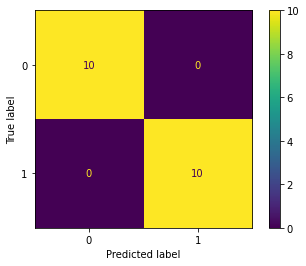

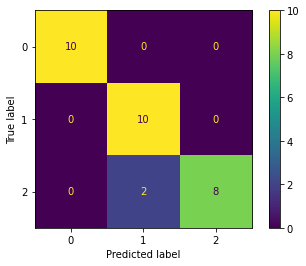

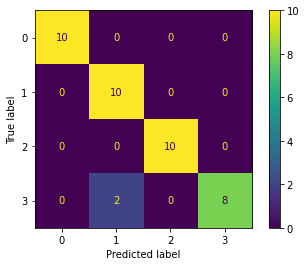

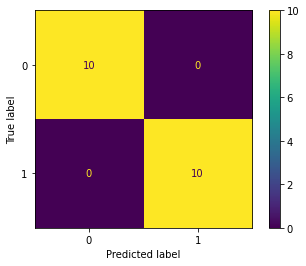

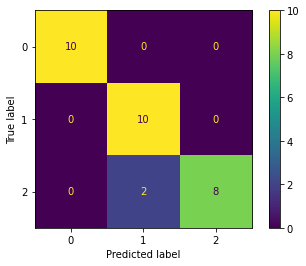

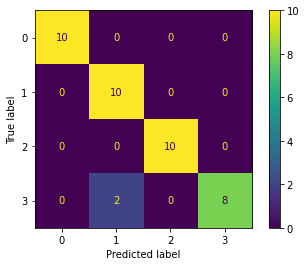

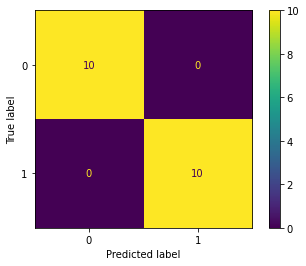

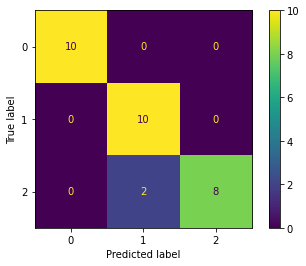

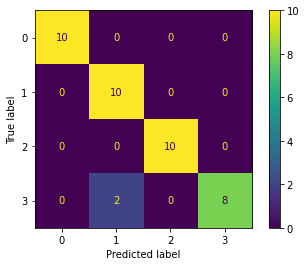

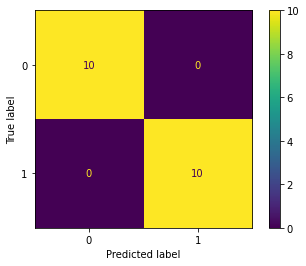

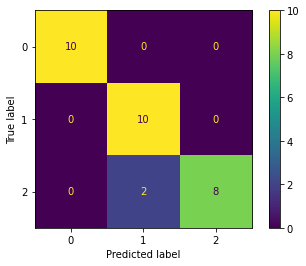

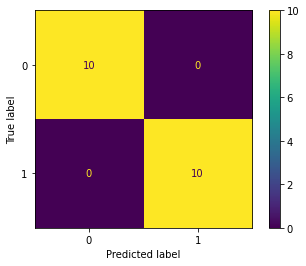

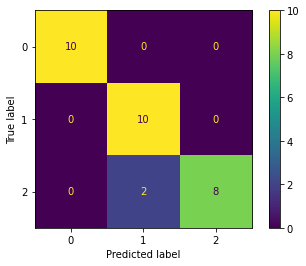

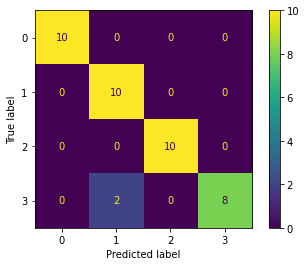

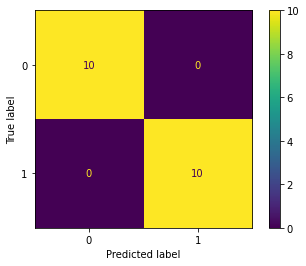

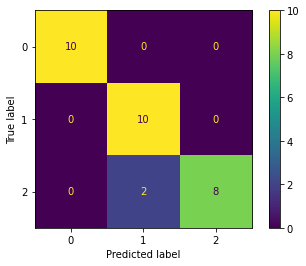

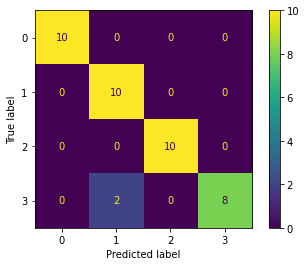

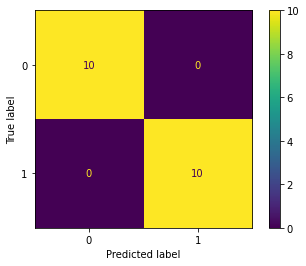

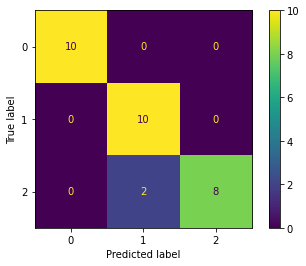

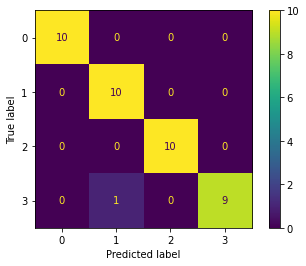

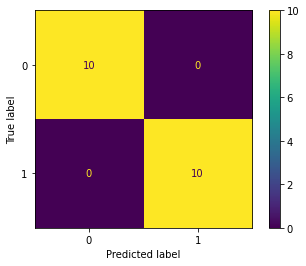

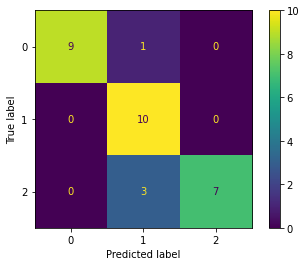

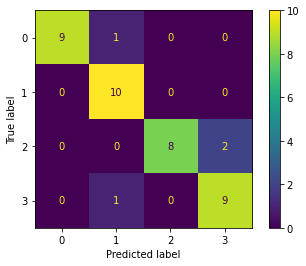

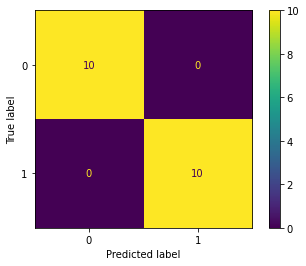

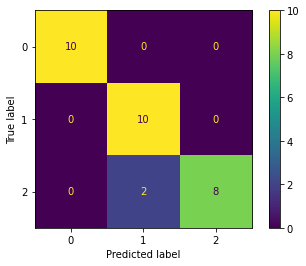

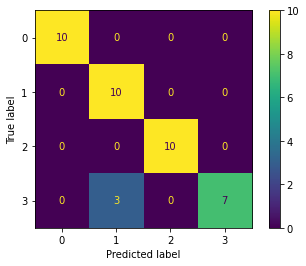

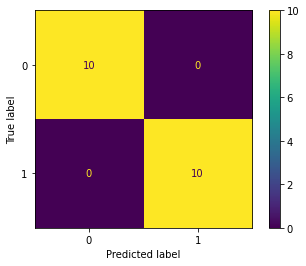

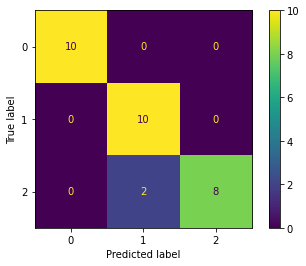

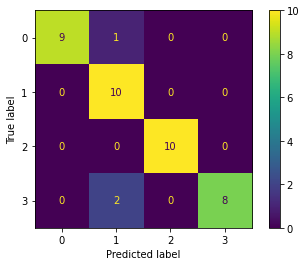

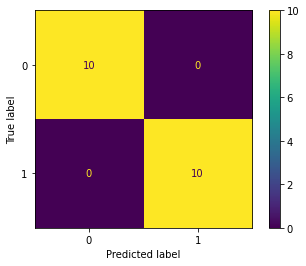

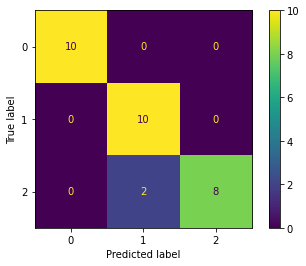

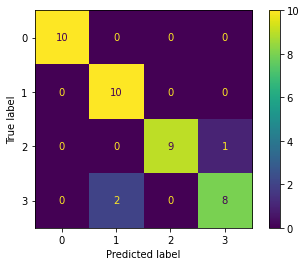

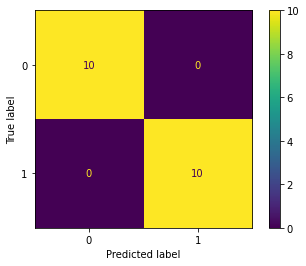

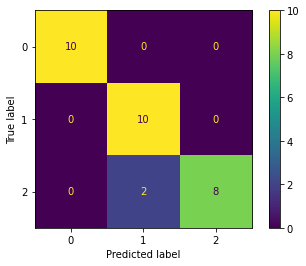

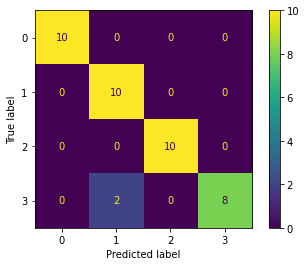

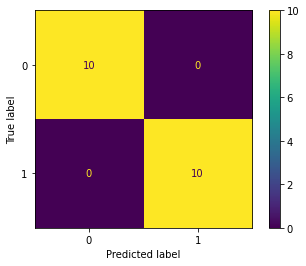

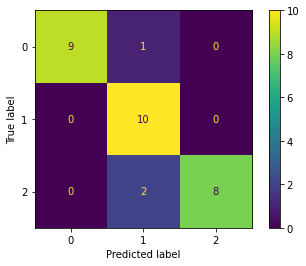

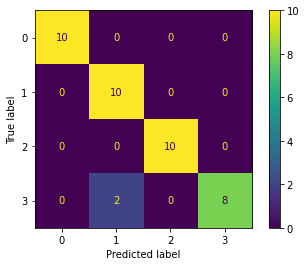

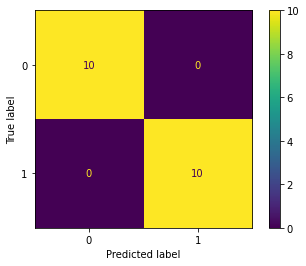

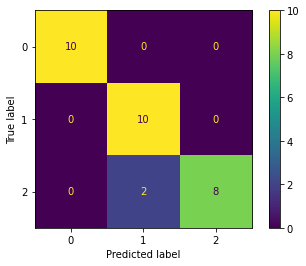

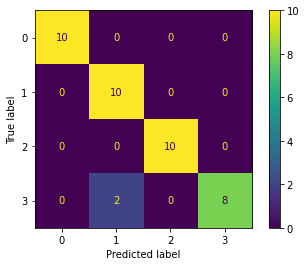

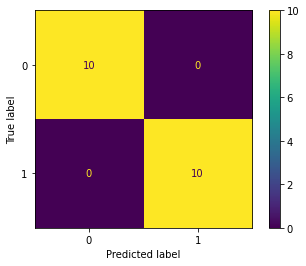

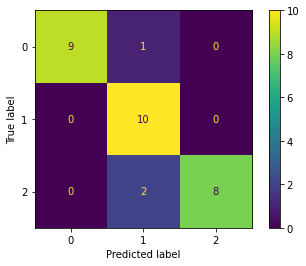

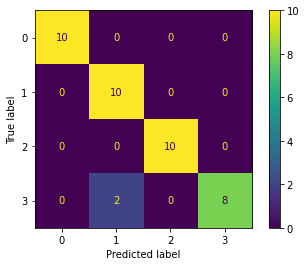

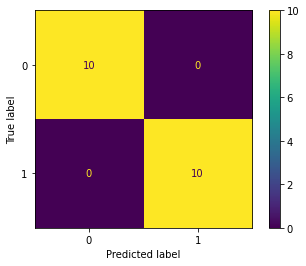

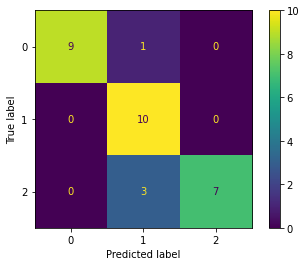

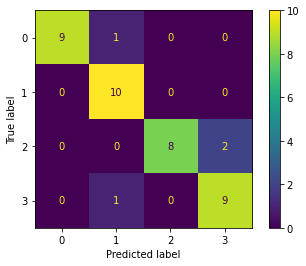

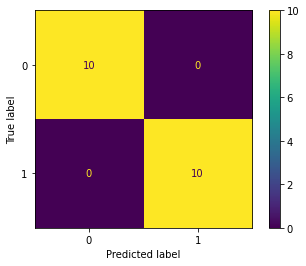

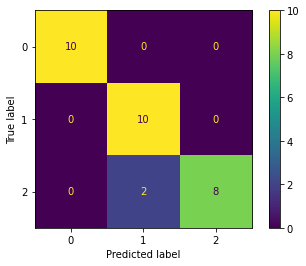

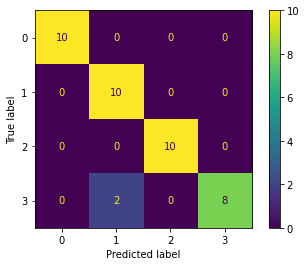

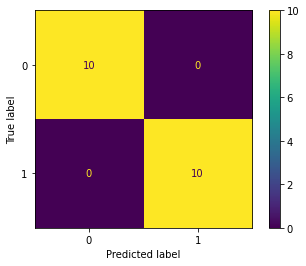

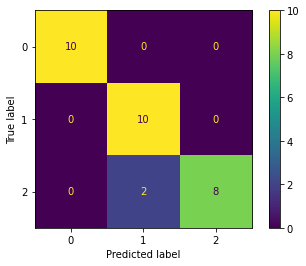

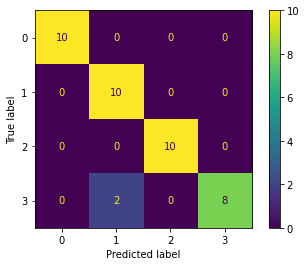

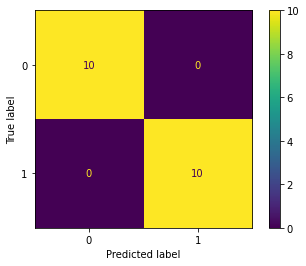

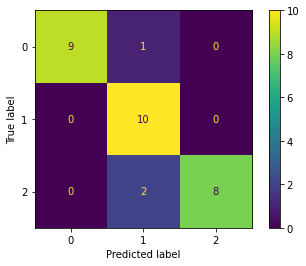

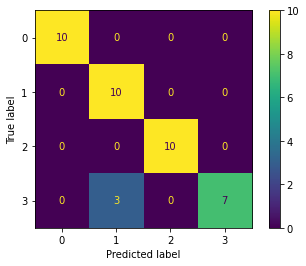

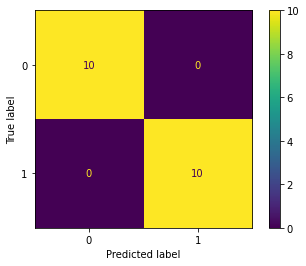

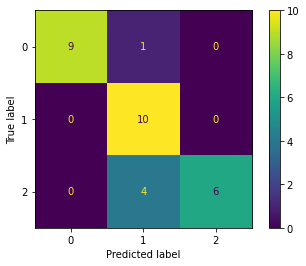

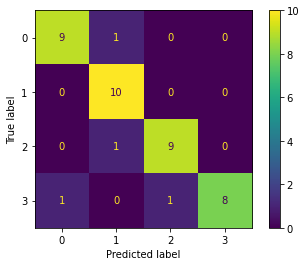

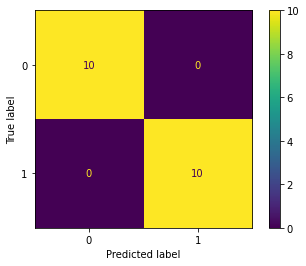

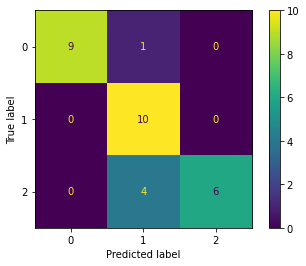

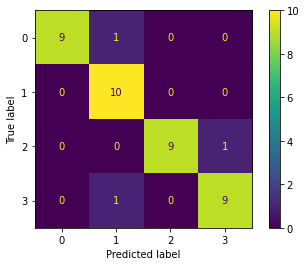

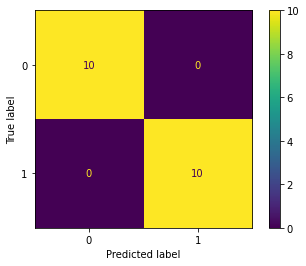

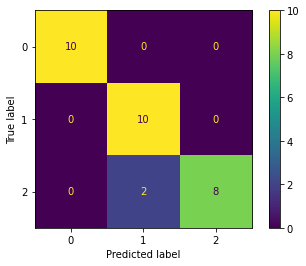

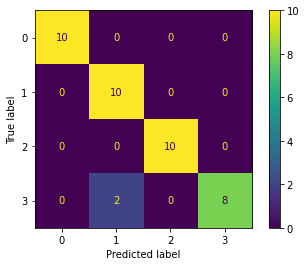

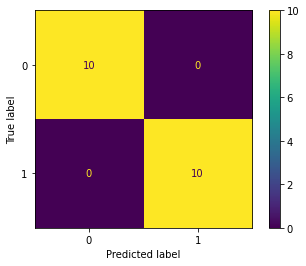

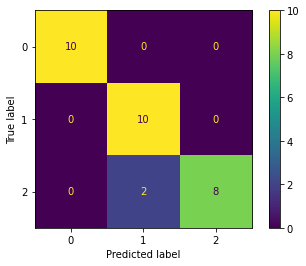

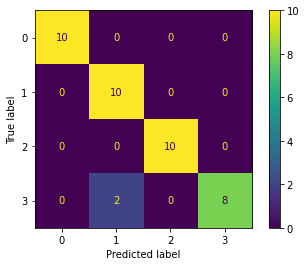

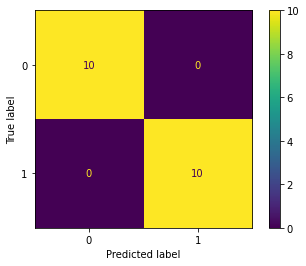

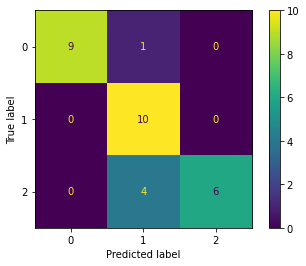

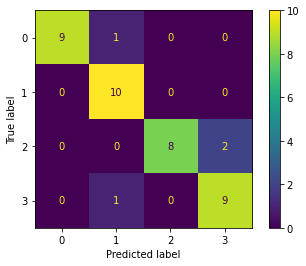

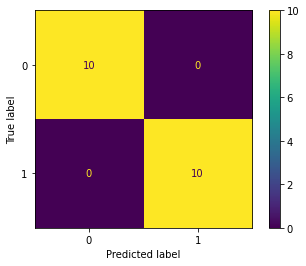

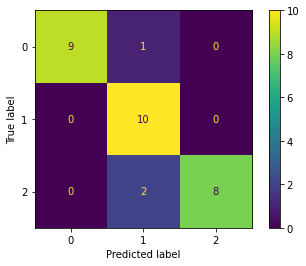

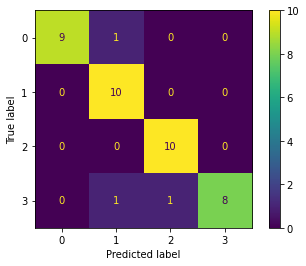

In [28]:
n_exps = 25

ground_truth = [0,1,2,3]

pred_iou = []
for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    known_classes = [0,1]
    known_classes_order = []
    
    model = None
    
    retrains = 0
    while len(known_classes) < len(ground_truth) and retrains < 2:
        print("Known classes:", known_classes)
        known_classes_order.append(known_classes.copy())
        
        feature_idxs = [*range(3,16),*range(22,28)]
        #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
        #feature_idxs = [*range(3,19),*range(22,28)] # with object position
        Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
        print()

        if model is None:
            model = train_classifier(Xtrain, Ttrain, len(known_classes))
        else:
            with torch.no_grad():
                weights = [[],[]]
                for i in range(len(model.conv_layers)):
                    weights[0].append(model.conv_layers[i].weight.detach())
                for i in range(len(model.fc_layers)-1):
                    weights[1].append(model.fc_layers[i].weight.detach())
            model = train_classifier(Xtrain, Ttrain, len(known_classes), pretrained=weights)
        print()

        # check classifier on the test data
        classes, probs = model.use(Xtest)

        # make confusion matrix
        cm = sklearn.metrics.confusion_matrix(Ttest, classes)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()

        novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
        gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
            else float('inf') for i in range(len(dissimilarities))]
        
        gated_dissimilarities = [gated_dissimilarities[i] if gated_dissimilarities[i] == gated_dissimilarities[i] \
            else float('inf') for i in range(len(gated_dissimilarities))]
        
        if np.min(gated_dissimilarities) == float('inf'):
            print("No novel class found")
            retrains += 1
            print("Retraining (%s)" % retrains)
        else:
            new_class = np.argmin(gated_dissimilarities)
            known_classes.append(new_class)
            retrains = 0

            print("Most novel class:", known_classes[-1])
        print()
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
    print()

    with torch.no_grad():
        weights = [[],[]]
        for i in range(len(model.conv_layers)):
            weights[0].append(model.conv_layers[i].weight.detach())
        for i in range(len(model.fc_layers)-1):
            weights[1].append(model.fc_layers[i].weight.detach())
    model = train_classifier(Xtrain, Ttrain, len(known_classes), pretrained=weights)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
        else float('inf') for i in range(len(dissimilarities))]
    
    gated_dissimilarities = [gated_dissimilarities[i] if gated_dissimilarities[i] == gated_dissimilarities[i] \
        else float('inf') for i in range(len(gated_dissimilarities))]
    
    if np.min(gated_dissimilarities) != float('inf'):
        new_class = np.argmin(gated_dissimilarities)
        known_classes.append(new_class)
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    print("Order of acquisition:", known_classes_order)

    pred_iou.append(np.intersect1d(known_classes[2:],ground_truth[2:]).shape[0]/\
                    np.union1d(known_classes[2:],ground_truth[2:]).shape[0])
    print(pred_iou,pred_iou[-1])
    print()
    
print(np.sum(pred_iou)/len(pred_iou))

# G: Multi-class non-curriculum learning 2

Start with cube and sphere.  After each trial add the class that has inferred to have the *greatest*  dissimilarity from its most similar class above the novelty threshold.  Test for the ability to acquire cylinder and capsule as distinct classes while not splitting small cube from big cube. With each additional class added, the model is retrained from scratch.

========== Experiment 1 ==========
Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0010513663291931152
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.08128142356872559
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlie

Outlier ratio: 11.17747497343747
Dissimilarity from most similar class: 6.826795996719076
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 2]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.057
adam: Epoch 100 Loss 0.027
adam: Epoch 150 Loss 0.007
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.003387629985809326
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.006376028060913086
Angle from

Outlier ratio: 2.107672038338256
Dissimilarity from most similar class: 23.87265854841737
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 3, 2]
(3600, 19) (3600,) (400, 19) (400,)
(360, 190) (360,) (40, 190) (40,)
(360, 1, 190) (360,) (40, 1, 190) (40,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.057
adam: Epoch 100 Loss 0.018
adam: Epoch 150 Loss 0.005
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.10915124416351318
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0024448633193969727
Angle f

adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0010151267051696777
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.08892577886581421
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0010151267051696777
Angle from sim_mean to new_mean: 1.901388168334961e-

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.002579987049102783
Angle from sim_mean to new_mean: 6.318092346191406e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0024488852951368833
Outlier ratio: 16.30771074592231
Dissimilarity from most similar class: 32.20558629484402
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.004038393497467041
Angle from sim_mean to new_mean: 0.003506898880004883
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.8683895916047998
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.002579987049102783
Angle from sim_mean to new_mean: 1.1920928955078125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 4.620538292711101e-05
Outlier ratio: 4.7590528442338265
Dissimilarity from most similar class: 0.17733026690493814
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 2]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.057
adam: Epoch 100 Loss 0.019
adam: Epoch 150 Loss 0.005
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.013628244400024414
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Ang

Angle from sim_mean to sim_mean+std: 0.018891096115112305
Angle from sim_mean to new_mean: 0.0002938508987426758
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.015554994636208746
Outlier ratio: 2.0479167309423825
Dissimilarity from most similar class: 20.214301369603792
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 3, 2]
(3600, 19) (3600,) (400, 19) (400,)
(360, 190) (360,) (40, 190) (40,)
(360, 1, 190) (360,) (40, 1, 190) (40,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.043
adam: Epoch 100 Loss 0.012
adam: Epoch 150 Loss 0.004
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Angle from sim_mean to sim_mean+std: 0.2102540135383606
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0026119351387023926
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.1722511649131775
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.11928653717041016
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/A

adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.002359330654144287
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0056143999099731445
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.002359330654144287
Angle from sim_mean to new_mean: 1.0788440704345703e

Outlier ratio: 20.610012779264824
Dissimilarity from most similar class: 4.62845930409038
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 2]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.057
adam: Epoch 100 Loss 0.027
adam: Epoch 150 Loss 0.007
adam: Epoch 200 Loss 0.003
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.002579331398010254
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0020731687545776367
Angle fro

Angle from sim_mean to sim_mean+std: 0.02034813165664673
Angle from sim_mean to new_mean: 0.00033676624298095703
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.016550229213351496
Outlier ratio: 2.0160420965646972
Dissimilarity from most similar class: 23.776834550406335
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 3, 2]
(3600, 19) (3600,) (400, 19) (400,)
(360, 190) (360,) (40, 190) (40,)
(360, 1, 190) (360,) (40, 1, 190) (40,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.049
adam: Epoch 100 Loss 0.020
adam: Epoch 150 Loss 0.005
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.1432514786720276
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_

Angle from sim_mean to sim_mean+std: 0.11176121234893799
Angle from sim_mean to new_mean: 0.00025600194931030273
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0022906153568826725
Outlier ratio: 1.3366384534539761
Dissimilarity from most similar class: 1.6224487011749968
Likely novel class: False

Known classes: [0, 1, 3, 2]
Order of acquisition: [[0, 1], [0, 1, 3], [0, 1, 3, 2], [0, 1, 3, 2]]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 1.0

========== Experiment 13 ==========
Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0


Outlier ratio: 10.094359029354994
Dissimilarity from most similar class: 279.76208877464205
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.11443448066711426
Angle from sim_mean to new_mean: 0.08722656965255737
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.7622402718486249
Outlier ratio: 1.8257470448978819
Dissimilarity from most similar class: 103.56487643954176
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0009029507637023926
Angle from sim_mean to new_mean: 3.5762786865234375e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0003960657469139877
Outlier ratio: 4.021480428915857
Dissimilarity from most similar class: 2.4952411868671733
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 2]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not availa

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.0027331113815307617
Angle from sim_mean to new_mean: 4.708766937255859e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0017228595106206655
Outlier ratio: 16.103381798000807
Dissimilarity from most similar class: 21.373760296421104
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.006573736667633057
Angle from sim_mean to new_mean: 0.003408074378967285
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.5184379221862561
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0027331113815307617
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 2.1808348235704628e-05
Outlier ratio: 4.711029678504921
Dissimilarity from most similar class: 0.07915030516591859
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.000779569149017334
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.002339959144592285
Angle from sim_mean to new_mean: 2.384185791015625e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00010189006062458607
Outlier ratio: 4.843639373732837
Dissimilarity from most similar class: 0.4273223100268086
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.007
adam: Epoch 100 Loss 0.002
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.019864797592163086
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle

Angle from sim_mean to sim_mean+std: 0.017420530319213867
Angle from sim_mean to new_mean: 0.0002964138984680176
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.017015205222603913
Outlier ratio: 2.149722440453625
Dissimilarity from most similar class: 25.01854449573318
Likely novel class: True

Most novel class: 2

Known classes: [0, 1, 3, 2]
(3600, 19) (3600,) (400, 19) (400,)
(360, 190) (360,) (40, 190) (40,)
(360, 1, 190) (360,) (40, 1, 190) (40,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.053
adam: Epoch 100 Loss 0.023
adam: Epoch 150 Loss 0.005
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.04552954435348511
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_me

Angle from sim_mean to sim_mean+std: 0.01999533176422119
Angle from sim_mean to new_mean: 0.00032633543014526367
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.016320580923253027
Outlier ratio: 2.0642506053829415
Dissimilarity from most similar class: 21.340192370292563
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 3, 2]
(3600, 19) (3600,) (400, 19) (400,)
(360, 190) (360,) (40, 190) (40,)
(360, 1, 190) (360,) (40, 1, 190) (40,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.051
adam: Epoch 100 Loss 0.013
adam: Epoch 150 Loss 0.004
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.15899288654327393
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim

Angle from sim_mean to sim_mean+std: 0.08323293924331665
Angle from sim_mean to new_mean: 0.0011919736862182617
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.014320937083979928
Outlier ratio: 1.3583372524265307
Dissimilarity from most similar class: 13.104295193608293
Likely novel class: False

Known classes: [0, 1, 3, 2]
Order of acquisition: [[0, 1], [0, 1, 3], [0, 1, 3, 2], [0, 1, 3, 2]]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 1.0

========== Experiment 20 ==========
Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.000
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Ep

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.0030976533889770508
Angle from sim_mean to new_mean: 5.602836608886719e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0018087358091206465
Outlier ratio: 11.737868434113603
Dissimilarity from most similar class: 20.57817757088067
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.004985809326171875
Angle from sim_mean to new_mean: 0.0031332969665527344
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.6284429992348891
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0030976533889770508
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 1.9241870309794112e-05
Outlier ratio: 3.315051209067654
Dissimilarity from most similar class: 0.06182726865149812
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0007243752479553223
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean t

Angle from sim_mean to sim_mean+std: 0.0005695223808288574
Angle from sim_mean to new_mean: 4.76837158203125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.000837257980115123
Outlier ratio: 9.28814617815199
Dissimilarity from most similar class: 6.521799184593533
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 2]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.056
adam: Epoch 100 Loss 0.017
adam: Epoch 150 Loss 0.004
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.018422722816467285
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean

Angle from sim_mean to sim_mean+std: 0.025377988815307617
Angle from sim_mean to new_mean: 0.0003565549850463867
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.014049773118006821
Outlier ratio: 2.3599968080552114
Dissimilarity from most similar class: 15.581690545872886
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1, 3]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.005
adam: Epoch 100 Loss 0.002
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01768571138381958
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from si

Angle from sim_mean to sim_mean+std: 0.027886509895324707
Angle from sim_mean to new_mean: 0.00034606456756591797
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.012409748256949758
Outlier ratio: 1.9429991316305513
Dissimilarity from most similar class: 10.85034402331068
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1, 3]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.007
adam: Epoch 100 Loss 0.002
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.015190303325653076
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from s

Angle from sim_mean to sim_mean+std: 0.019888103008270264
Angle from sim_mean to new_mean: 0.00030165910720825195
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.015167817015167817
Outlier ratio: 2.014190615255224
Dissimilarity from most similar class: 20.324659136456784
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 3, 2]
(3600, 19) (3600,) (400, 19) (400,)
(360, 190) (360,) (40, 190) (40,)
(360, 1, 190) (360,) (40, 1, 190) (40,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.049
adam: Epoch 100 Loss 0.035
adam: Epoch 150 Loss 0.006
adam: Epoch 200 Loss 0.003
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.14083951711654663
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim

Angle from sim_mean to sim_mean+std: 0.13213413953781128
Angle from sim_mean to new_mean: 0.0003966093063354492
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0030015657401087944
Outlier ratio: 1.0237892183264357
Dissimilarity from most similar class: 1.694450666089526
Likely novel class: False

Known classes: [0, 1, 3, 2]
Order of acquisition: [[0, 1], [0, 1, 3], [0, 1, 3, 2], [0, 1, 3, 2]]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 1.0

1.0


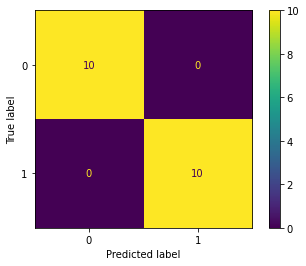

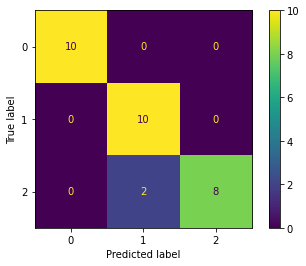

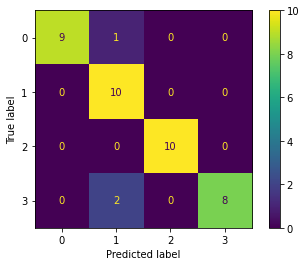

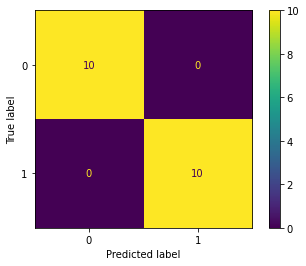

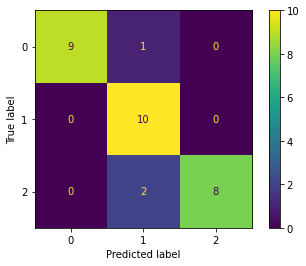

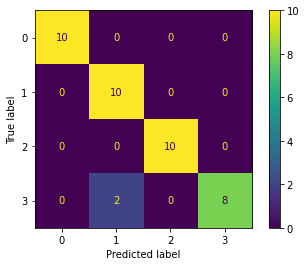

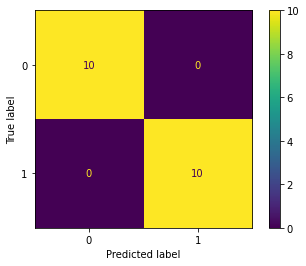

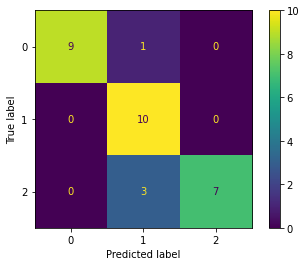

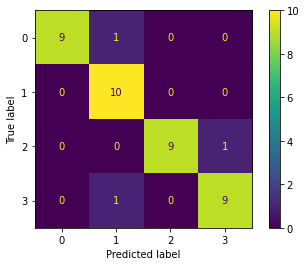

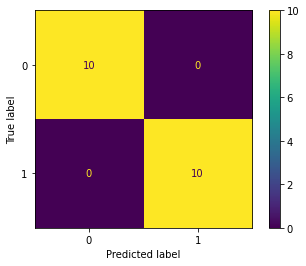

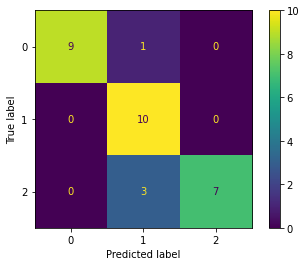

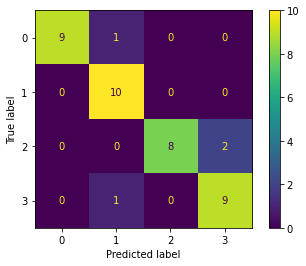

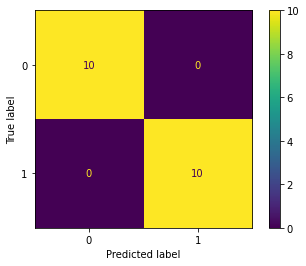

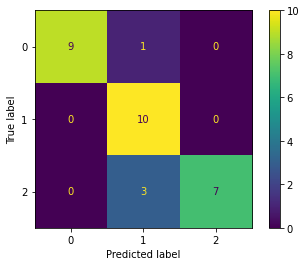

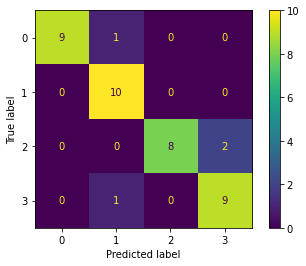

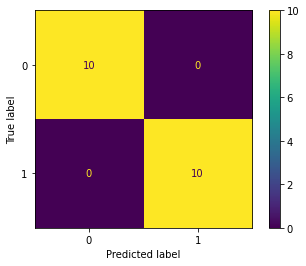

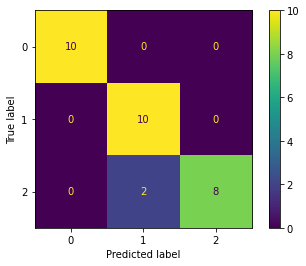

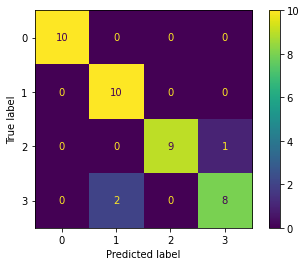

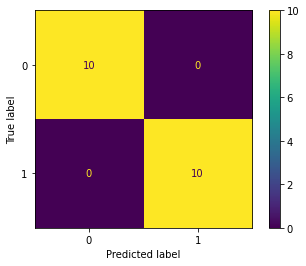

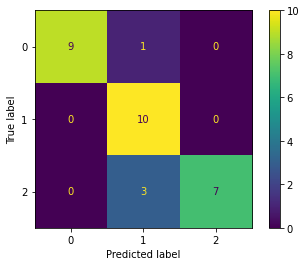

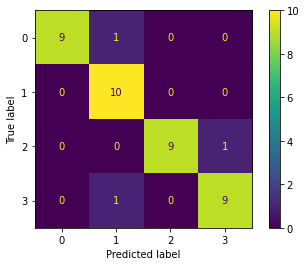

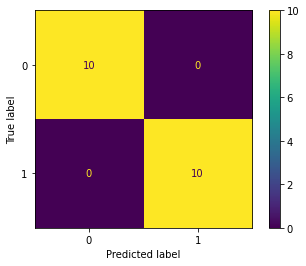

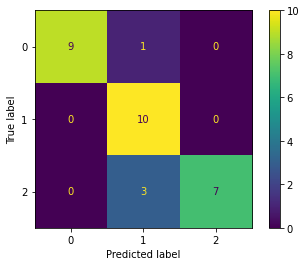

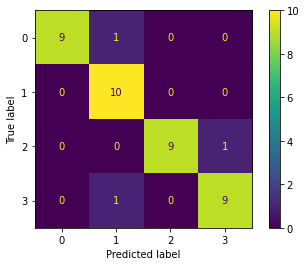

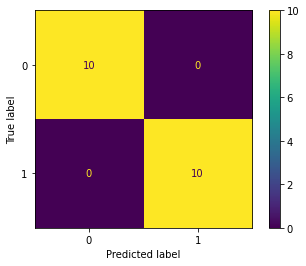

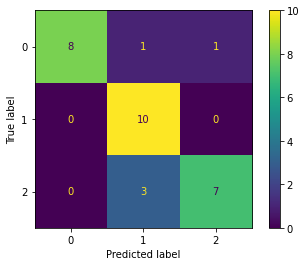

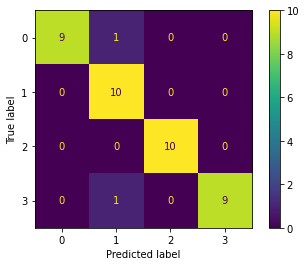

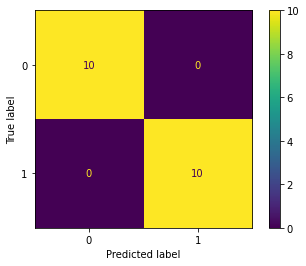

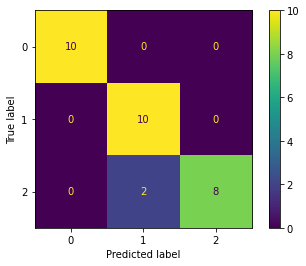

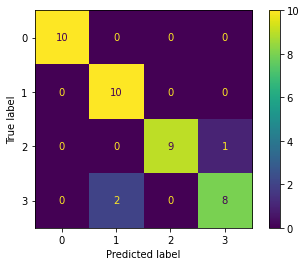

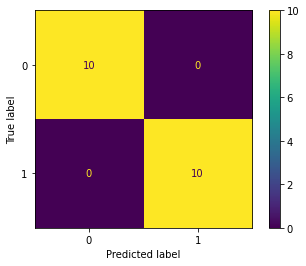

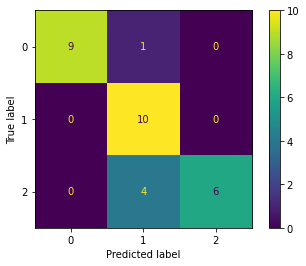

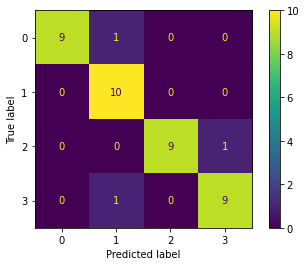

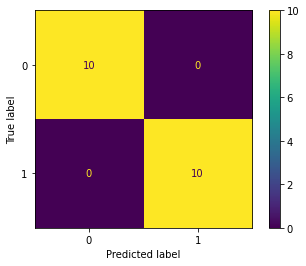

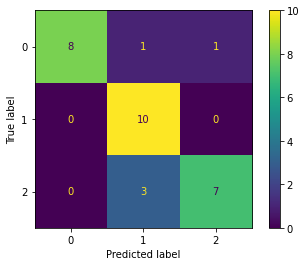

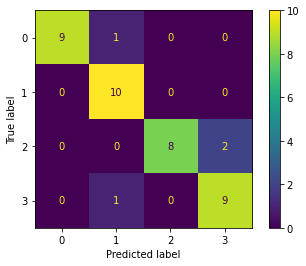

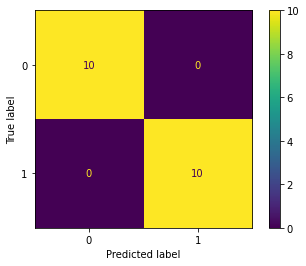

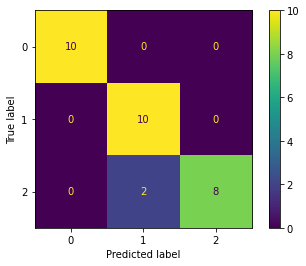

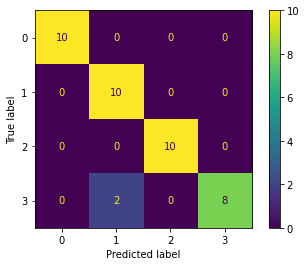

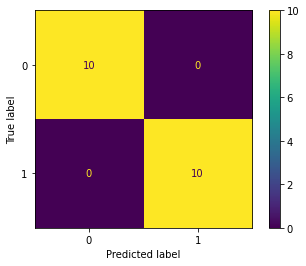

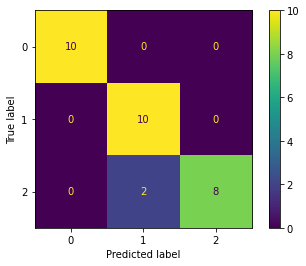

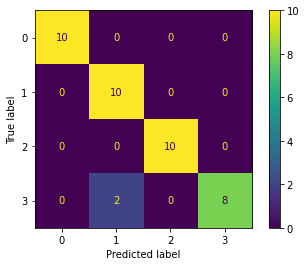

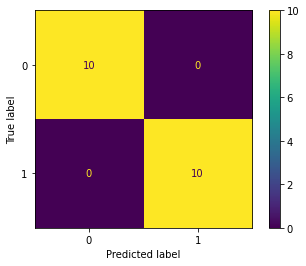

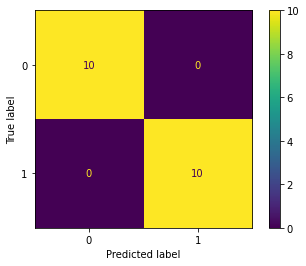

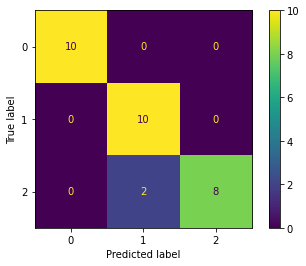

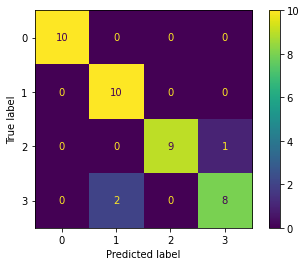

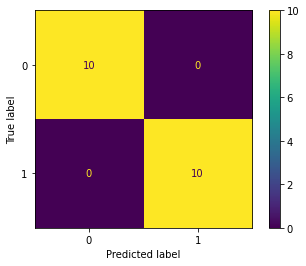

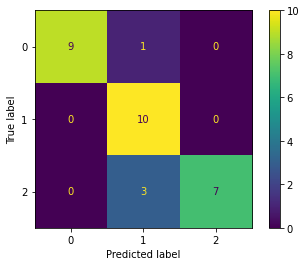

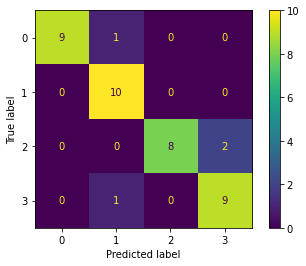

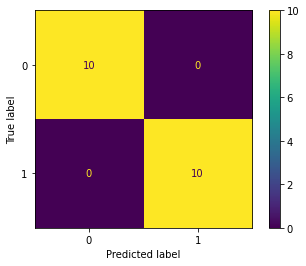

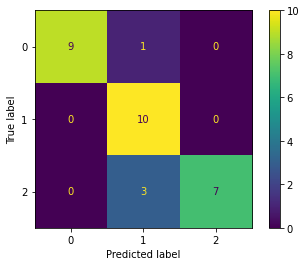

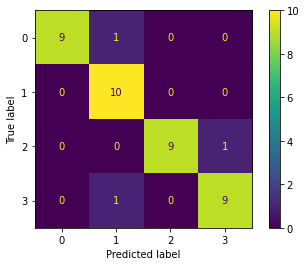

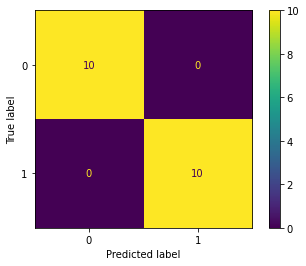

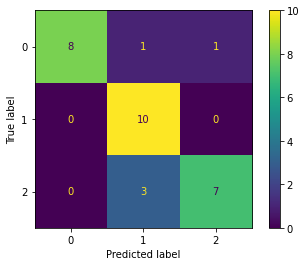

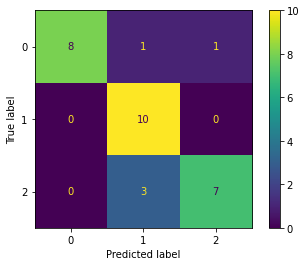

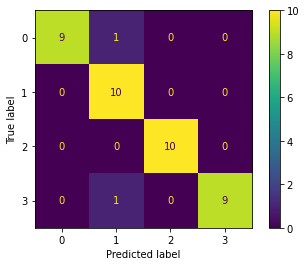

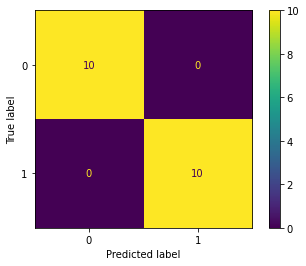

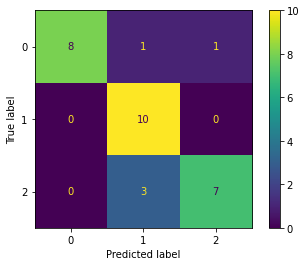

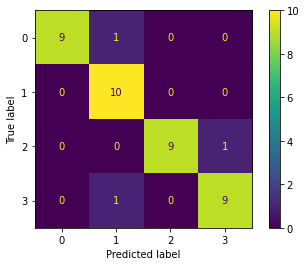

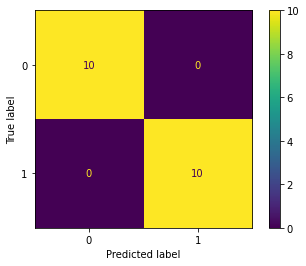

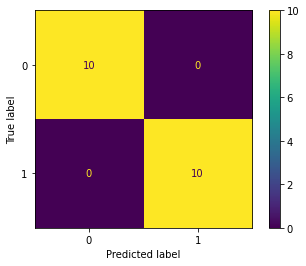

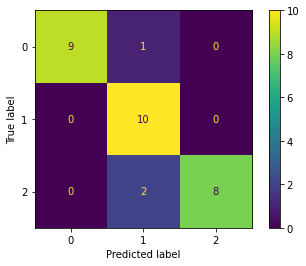

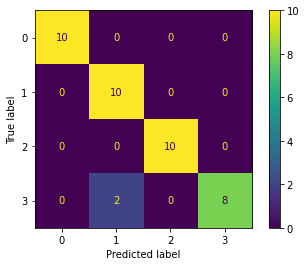

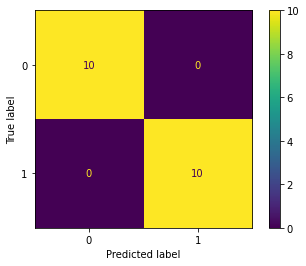

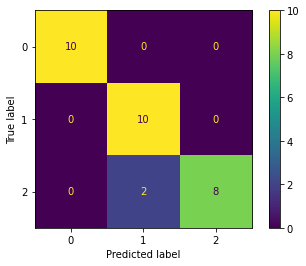

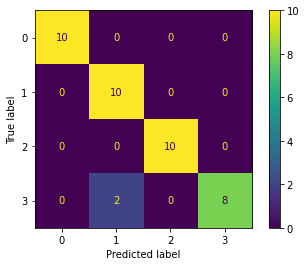

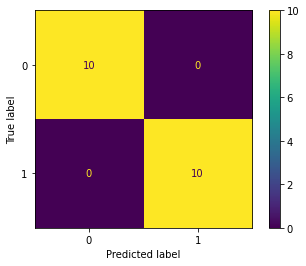

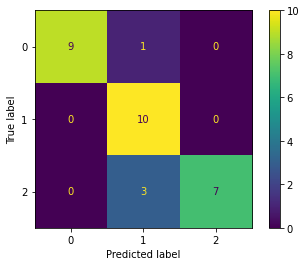

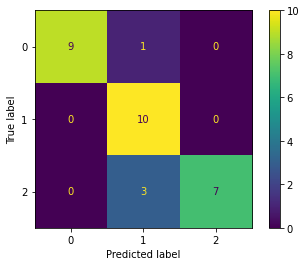

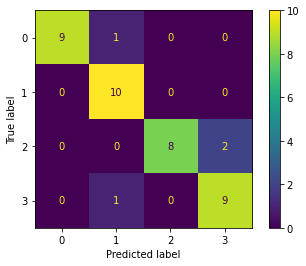

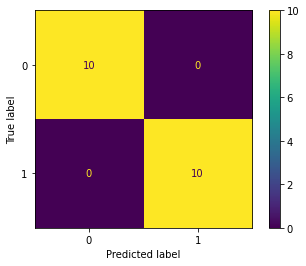

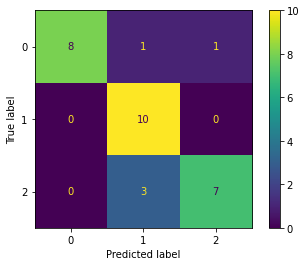

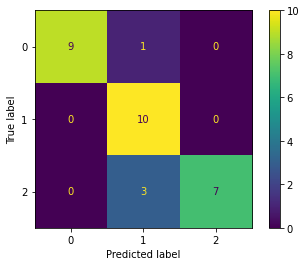

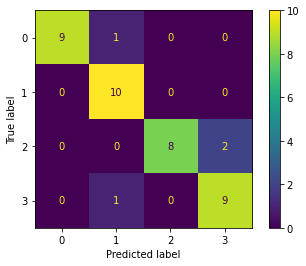

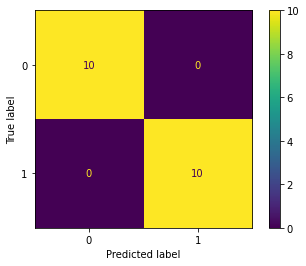

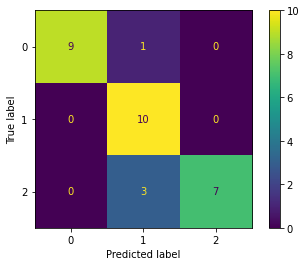

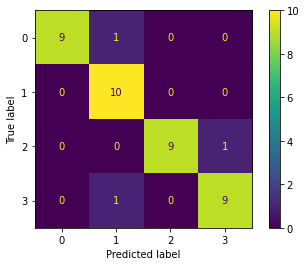

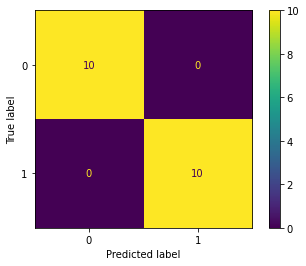

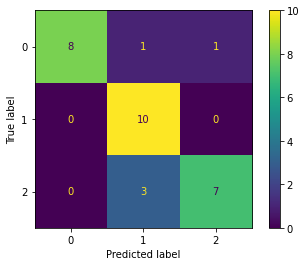

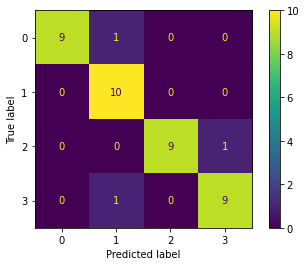

In [30]:
n_exps = 25

ground_truth = [0,1,2,3]

pred_iou = []
for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    known_classes = [0,1]
    known_classes_order = []
    
    model = None
    
    retrains = 0
    while len(known_classes) < len(ground_truth) and retrains < 2:
        print("Known classes:", known_classes)
        known_classes_order.append(known_classes.copy())
        
        feature_idxs = [*range(3,16),*range(22,28)]
        #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
        #feature_idxs = [*range(3,19),*range(22,28)] # with object position
        Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
        print()

        model = train_classifier(Xtrain, Ttrain, len(known_classes))
        print()

        # check classifier on the test data
        classes, probs = model.use(Xtest)

        # make confusion matrix
        cm = sklearn.metrics.confusion_matrix(Ttest, classes)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()

        novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
        gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
            else float('-inf') for i in range(len(dissimilarities))]
        
        gated_dissimilarities = [gated_dissimilarities[i] if gated_dissimilarities[i] == gated_dissimilarities[i] \
            else float('-inf') for i in range(len(gated_dissimilarities))]
        
        if np.max(gated_dissimilarities) == float('-inf'):
            print("No novel class found")
            retrains += 1
            print("Retraining (%s)" % retrains)
        else:
            new_class = np.argmax(gated_dissimilarities)
            known_classes.append(new_class)
            retrains = 0

            print("Most novel class:", known_classes[-1])
        print()
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, len(known_classes))
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
        else float('-inf') for i in range(len(dissimilarities))]
    
    gated_dissimilarities = [gated_dissimilarities[i] if gated_dissimilarities[i] == gated_dissimilarities[i] \
        else float('-inf') for i in range(len(gated_dissimilarities))]
    
    if np.max(gated_dissimilarities) != float('-inf'):
        new_class = np.argmax(gated_dissimilarities)
        known_classes.append(new_class)
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    print("Order of acquisition:", known_classes_order)

    pred_iou.append(np.intersect1d(known_classes[2:],ground_truth[2:]).shape[0]/\
                    np.union1d(known_classes[2:],ground_truth[2:]).shape[0])
    print(pred_iou,pred_iou[-1])
    print()
    
print(np.sum(pred_iou)/len(pred_iou))

# H: Multi-class curriculum learning 2

Start with cube and sphere.  After each trial add the class that has inferred to have the *greatest*  dissimilarity from its most similar class above the novelty threshold.  Test for the ability to acquire cylinder and capsule as distinct classes while not splitting small cube from big cube. With each additional class added, the model is initialized with the trained weights from the previous model (except for the final fully connected layer weights, which are initialized randomly).

========== Experiment 1 ==========
Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000
CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.010
adam: Epoch 100 Loss 0.005
adam: Epoch 150 Loss 0.004
adam: Epoch 200 Loss 0.003
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.002
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.001

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0021516084671020508
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle fr

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0022028684616088867
Angle from sim_mean to new_mean: 1.5079975128173828e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.006845608528600032
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.003997325897216797
Angle from sim_mean to new_mean: 0.005879580974578857
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 1.4708785637599904
Outlier ratio: 207.97088674585777
Dissimilarity from most similar class: 15910.326254974158
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.0022028684616088867
Angle from sim_mean to new_mean: 8.344650268554688e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00037880837707668163
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.050
adam: Epoch 100 Loss 0.013
adam: Epoch 150 Loss 0.006
adam: Epoch 200 Loss 0.004
adam: Epoch 250 Loss 0.003
adam: Epoch 300 Loss 0.002
adam: Epoch 350 Loss 0.002
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.001

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.016933560371398926
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.016933560371398926
Angle from sim_mean to new_mean: 0.00047665834426879883
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.028148737407514307
Outlier ratio: 3.217273694830464
Dissimilarity from most similar class: 63.800854956631035
Likely novel class: True

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.17791491746902466
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.016933560371398926
Angle from sim_mean to new_mean: 0.0002487301826477051
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.014688593372709417
Outlier ratio: 2.1382074710333203
Dissimilarity from most similar class: 22.126342045198214
Likely novel class: False

Most nove

Angle from sim_mean to sim_mean+std: 0.031756818294525146
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.001530468463897705
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.07422453165054321
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.20272278785705566
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean

adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000
CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.007
adam: Epoch 100 Loss 0.004
adam: Epoch 150 Loss 0.003
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.002
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.001

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.002436041831970215
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0016052722930908203
Angle from sim

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.002436041831970215
Angle from sim_mean to new_mean: 2.9802322387695312e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.012233912405187179
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0016052722930908203
Angle from sim_mean to new_mean: 0.008595466613769531
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 5.354522501113917
Outlier ratio: 431.867267289042
Dissimilarity from most similar class: 142097.7849090544
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.002436041831970215
Angle from sim_mean to new_mean: 1.6689300537109375e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.000685099094690482
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.065
adam: Epoch 100 Loss 0.016
adam: Epoch 150 Loss 0.009
adam: Epoch 200 Loss 0.006
adam: Epoch 250 Loss 0.004
adam: Epoch 300 Loss 0.003
adam: Epoch 350 Loss 0.002
adam: Epoch 400 Loss 0.002
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.001

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.015018641948699951
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.

Outlier ratio: 3.292616564646377
Dissimilarity from most similar class: 91.76432038558077
Likely novel class: True

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.1803310513496399
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.014586091041564941
Angle from sim_mean to new_mean: 0.0002467036247253418
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.016913621615436795
Outlier ratio: 2.163031832395209
Dissimilarity from most similar class: 28.003565268535738
Likely novel class: True

Most novel class: 2

Known classes: [0, 1, 3, 2]
(3600, 19) (3600,) (400, 19) (400,)
(360, 190) (360,) (40, 190) (40,)
(360, 1, 190) (360,) (40, 1, 190) (40,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Los

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.08591747283935547
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.002191603183746338
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.12888824939727783
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.20806598663330078
Angle from sim_mean to new_mean: 0

adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000
CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.005
adam: Epoch 100 Loss 0.003
adam: Epoch 150 Loss 0.002
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.001

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0021224021911621094
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.003646552562713623
Angle from sim

Angle from sim_mean to sim_mean+std: 0.002768099308013916
Angle from sim_mean to new_mean: 2.562999725341797e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0009259059882431472
Outlier ratio: 3.5844790733049994
Dissimilarity from most similar class: 2.960817134935806
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.049
adam: Epoch 100 Loss 0.011
adam: Epoch 150 Loss 0.006
adam: Epoch 200 Loss 0.004
adam: Epoch 250 Loss 0.003
adam: Epoch 300 Loss 0.002
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.001

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01783674955368042
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_me

Outlier ratio: 3.3478758375809554
Dissimilarity from most similar class: 74.12704095444244
Likely novel class: True

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.14149457216262817
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.017219126224517822
Angle from sim_mean to new_mean: 0.00025087594985961914
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.014569609780919314
Outlier ratio: 2.1727828735092594
Dissimilarity from most similar class: 22.144524475654304
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 3, 2]
(3600, 19) (3600,) (400, 19) (400,)
(360, 190) (360,) (40, 190) (40,)
(360, 1, 190) (360,) (40, 1, 190) (40,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 5

Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.11343663930892944
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.2009618878364563
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0590248703956604
Angle from sim_mean to new_mean: 0.0005011558532714844
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.008490587948979725
Outlier ratio: 1.6879661243893476
Dissimilarity from most similar class: 6.9195685174207435
Likely novel class: False

Known classes: [0, 1, 3, 2]
Order of acquisition: [[0, 1], [0, 1, 3], [0, 1, 

adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000
CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.005
adam: Epoch 100 Loss 0.003
adam: Epoch 150 Loss 0.002
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0032806992530822754
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.000141143798828125
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Lik

Angle from sim_mean to sim_mean+std: 0.0026541948318481445
Angle from sim_mean to new_mean: 4.76837158203125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0001796541657309679
Outlier ratio: 4.943237259136537
Dissimilarity from most similar class: 0.66982843743288
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.032
adam: Epoch 100 Loss 0.010
adam: Epoch 150 Loss 0.006
adam: Epoch 200 Loss 0.004
adam: Epoch 250 Loss 0.003
adam: Epoch 300 Loss 0.002
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.001

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.014893710613250732
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mea

Outlier ratio: 3.5384495955466866
Dissimilarity from most similar class: 25.875829924712722
Likely novel class: True

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.15449512004852295
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.025829851627349854
Angle from sim_mean to new_mean: 0.00031375885009765625
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.012147141014369348
Outlier ratio: 2.0390046906009753
Dissimilarity from most similar class: 10.537010324673439
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 3, 2]
(3600, 19) (3600,) (400, 19) (400,)
(360, 190) (360,) (40, 190) (40,)
(360, 1, 190) (360,) (40, 1, 190) (40,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0730239748954773
Angle from sim_mean to new_mean: 0.0005636811256408691
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.007719124115712584
Outlier ratio: 0.8952897321411356
Dissimilarity from most similar class: 3.5793528762334508
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.05896294116973877
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0730239748954773
Angle from sim_mean to new_mean: 0.0001323223114013672
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.001812039286970703
Outlier ratio: 1.0551946662914062
Dissimilarity from most similar class: 0.990314379557969
Likely novel class: False

No novel clas

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.017236530780792236
Angle from sim_mean to new_mean: 0.0006799697875976562
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.03944934141592982
Outlier ratio: 3.756190798997044
Dissimilarity from most similar class: 56.45481718637624
Likely novel class: True

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.09703779220581055
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.017236530780792236
Angle from sim_mean to new_mean: 0.0001989603042602539
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.011542943692704569
Outlier ratio: 2.136028996249569
Dissimilarity from most similar class: 9.393713805720898
Likely novel class: False

Known classes:

adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000
CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.009
adam: Epoch 100 Loss 0.005
adam: Epoch 150 Loss 0.004
adam: Epoch 200 Loss 0.003
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.002
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.001

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.004149317741394043
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0016141533851623535
Angle from sim

Outlier ratio: 16.647901509851227
Dissimilarity from most similar class: 54.18763459195394
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0009859800338745117
Angle from sim_mean to new_mean: 0.0023692846298217773
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 2.40297424737033
Outlier ratio: 737.8920821049254
Dissimilarity from most similar class: 106201.73696584512
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.002725660800933838
Angle from sim_mean to new_mean: 5.960464477539062e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00021867961249972666
Outlier ratio: 4.8829091895734384
Dissimilarity from most similar class: 0.7907210232557388
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not availa

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.013993620872497559
Angle from sim_mean to new_mean: 0.0006093382835388184
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.04354400402088817
Outlier ratio: 3.3804623107493192
Dissimilarity from most similar class: 126.59034503492003
Likely novel class: True

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.2192467451095581
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.013993620872497559
Angle from sim_mean to new_mean: 0.0002459287643432617
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.01757434809646724
Outlier ratio: 2.159240206454378
Dissimilarity from most similar class: 32.63445066345442
Likely novel class: True

Most novel clas

adam: Epoch 500 Loss 0.001

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.04006659984588623
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0008977055549621582
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.07385861873626709
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.15875238180160522
Angle

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.0018025636672973633
Angle from sim_mean to new_mean: 3.224611282348633e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.01788902850340586
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.20104455947875977
Angle from sim_mean to new_mean: 0.22447901964187622
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 1.1165635132026157
Outlier ratio: 3.8824246496799852
Dissimilarity from most similar class: 255.05223443420138
Likely novel class: True

New class: 4


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0018025636672973633
Angle from sim_mean to new_mean: 4.76837158203125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0002645327689967595
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 19) (2700,) (300, 19) (300,)
(270, 190) (270,) (30, 190) (30,)
(270, 1, 190) (270,) (30, 1, 190) (30,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.025
adam: Epoch 100 Loss 0.010
adam: Epoch 150 Loss 0.006
adam: Epoch 200 Loss 0.004
adam: Epoch 250 Loss 0.003
adam: Epoch 300 Loss 0.002
adam: Epoch 350 Loss 0.002
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.001

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0155487060546875
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0

Outlier ratio: 3.810662946932998
Dissimilarity from most similar class: 84.04576796080528
Likely novel class: True

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.17644017934799194
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.014413654804229736
Angle from sim_mean to new_mean: 0.0002110600471496582
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.014643062430475435
Outlier ratio: 2.1437784140238048
Dissimilarity from most similar class: 21.263057943888516
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 3, 2]
(3600, 19) (3600,) (400, 19) (400,)
(360, 190) (360,) (40, 190) (40,)
(360, 1, 190) (360,) (40, 1, 190) (40,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 

Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.1199725866317749
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.21245485544204712
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.09795969724655151
Angle from sim_mean to new_mean: 0.00014638900756835938
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0014943799509702213
Outlier ratio: 1.0521474639566617
Dissimilarity from most similar class: 0.8320391924222634
Likely novel class: False

Known classes: [0, 1, 3, 2]
Order of acquisition: [[0, 1], [0, 1, 3], [0, 

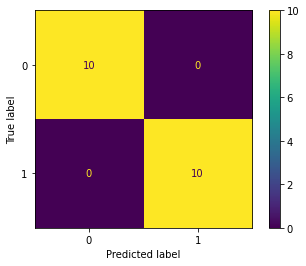

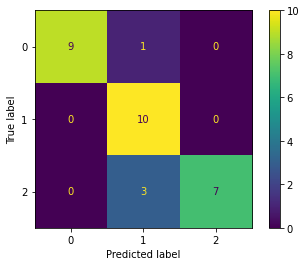

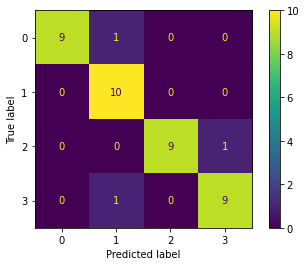

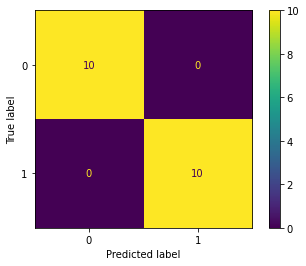

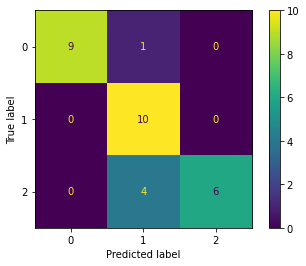

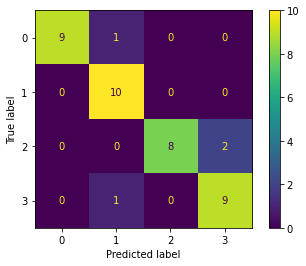

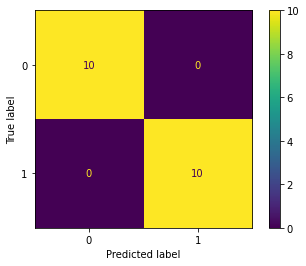

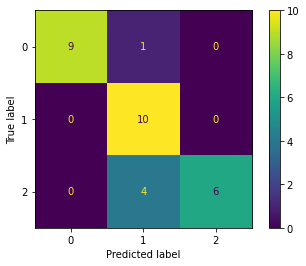

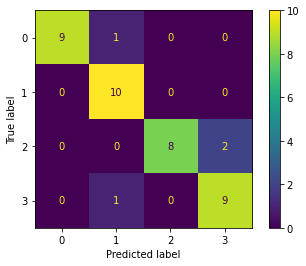

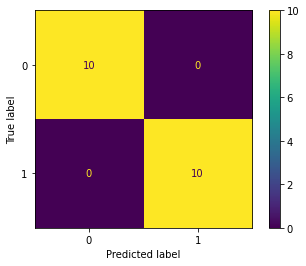

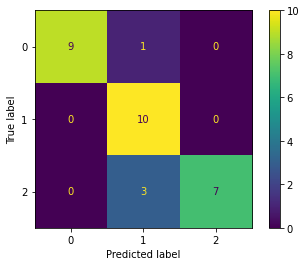

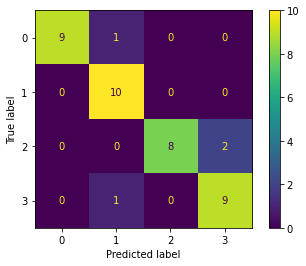

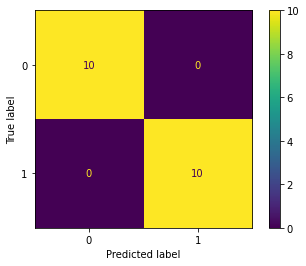

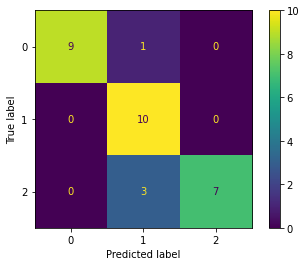

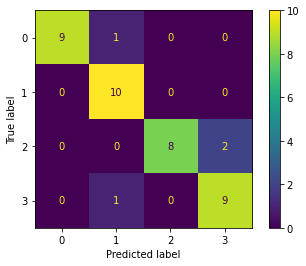

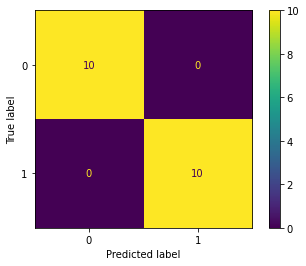

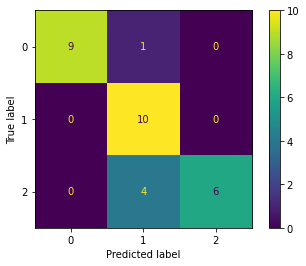

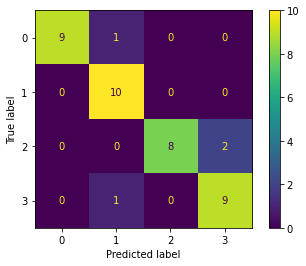

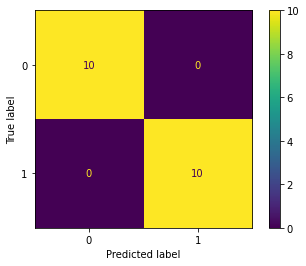

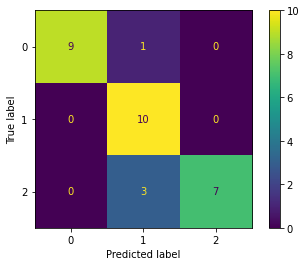

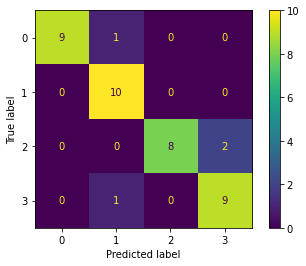

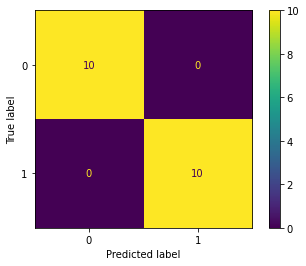

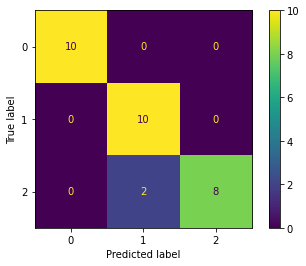

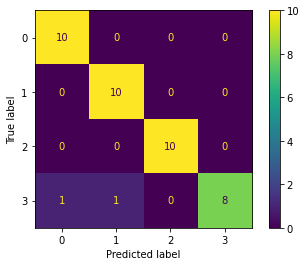

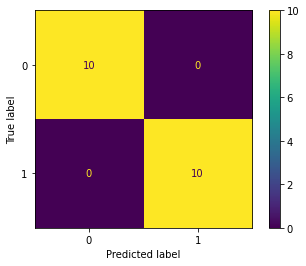

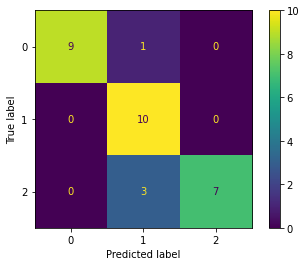

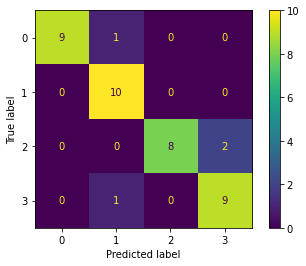

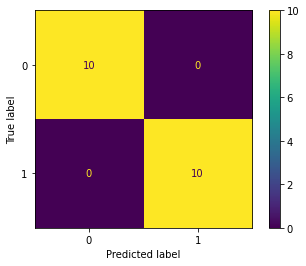

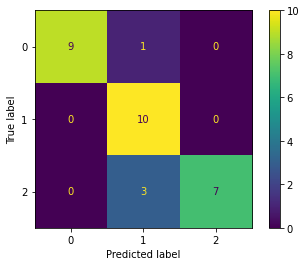

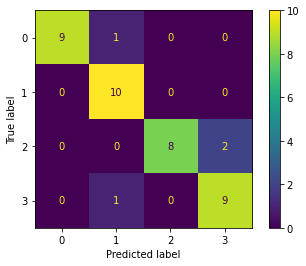

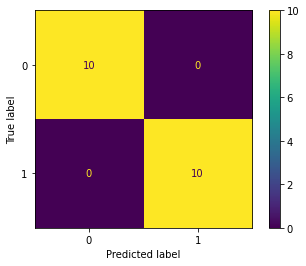

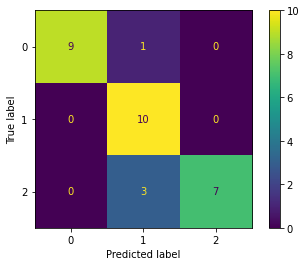

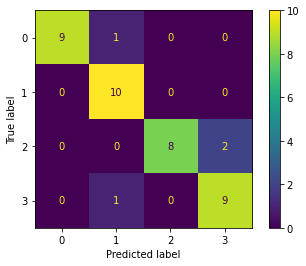

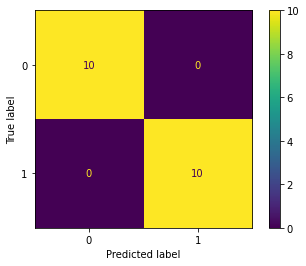

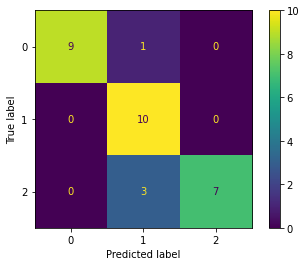

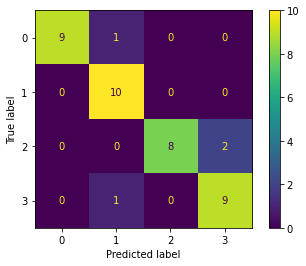

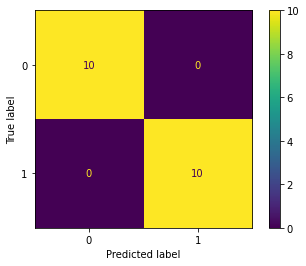

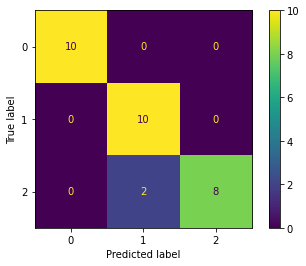

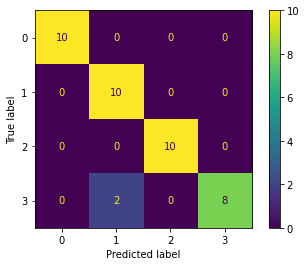

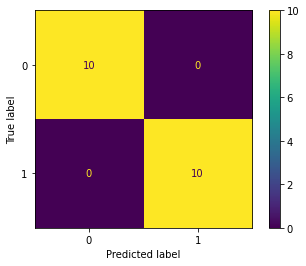

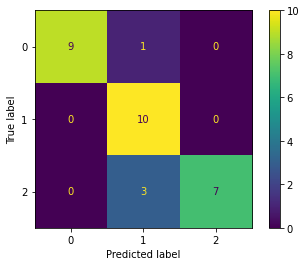

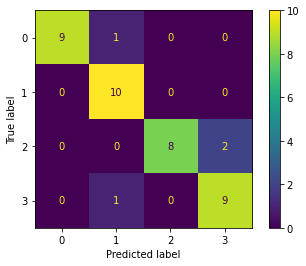

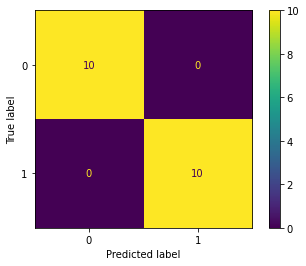

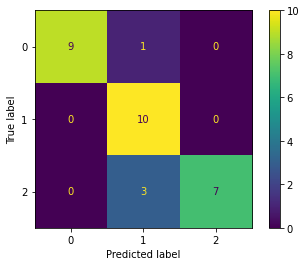

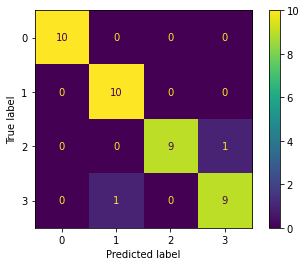

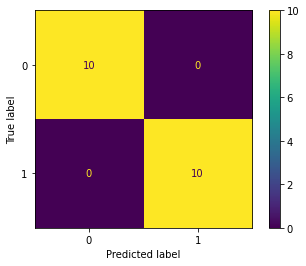

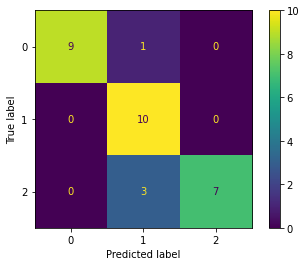

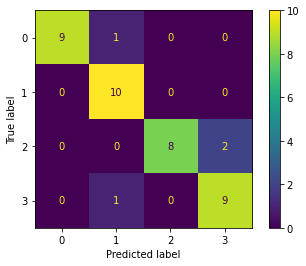

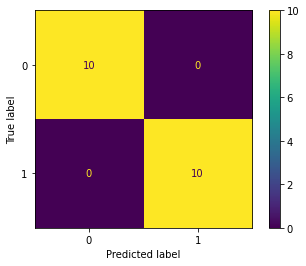

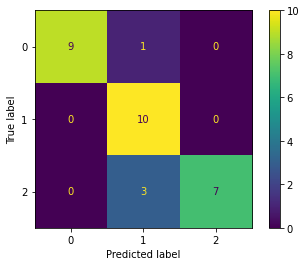

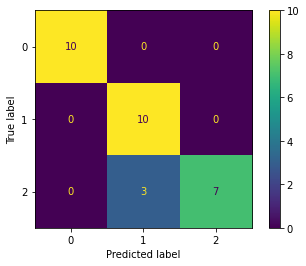

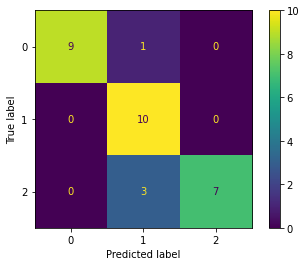

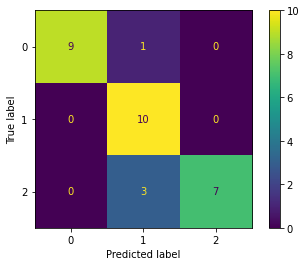

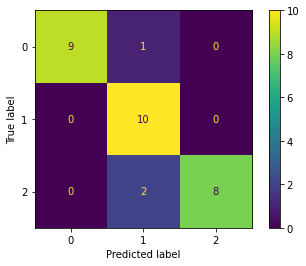

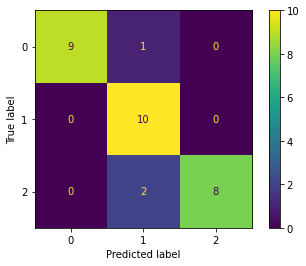

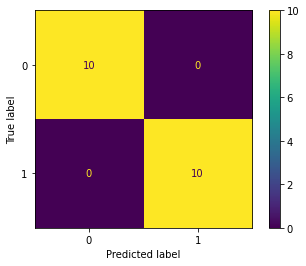

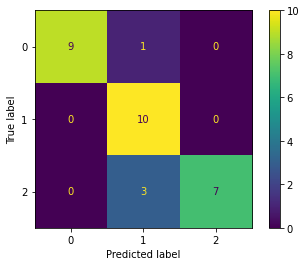

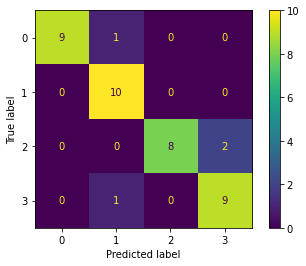

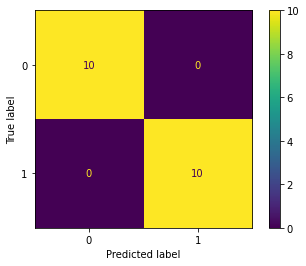

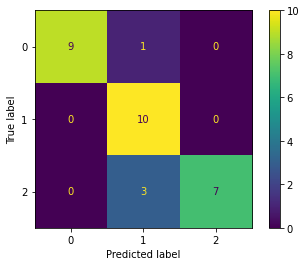

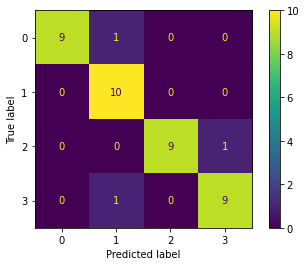

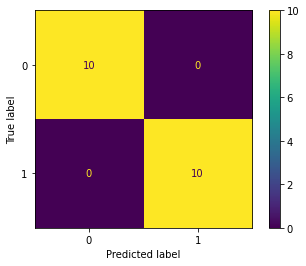

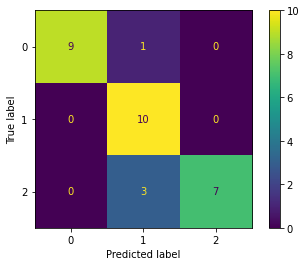

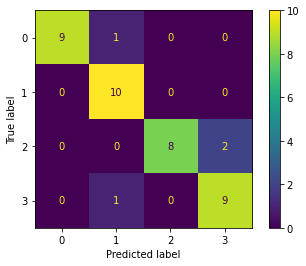

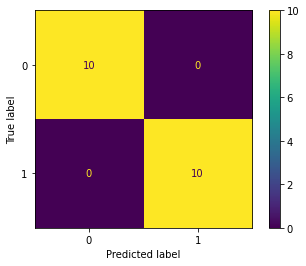

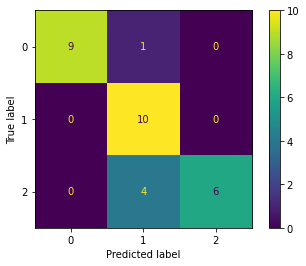

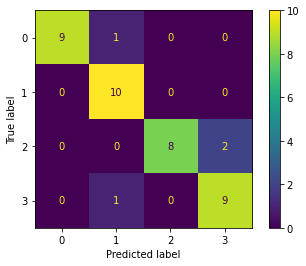

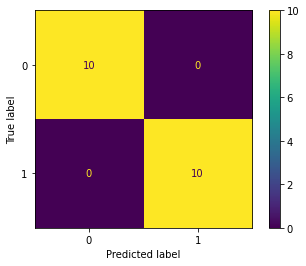

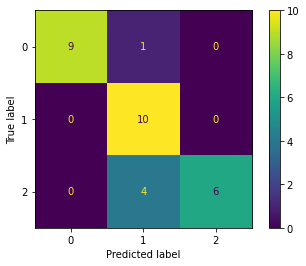

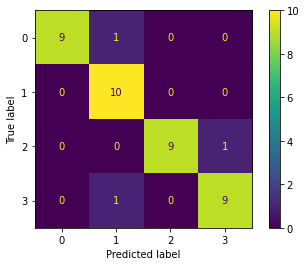

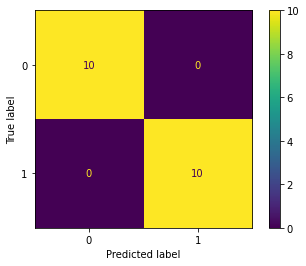

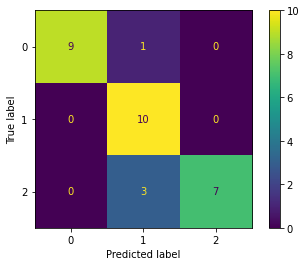

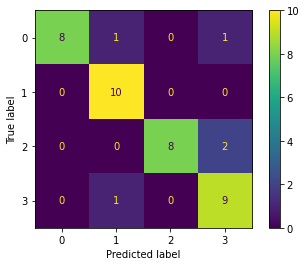

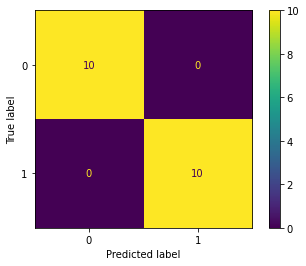

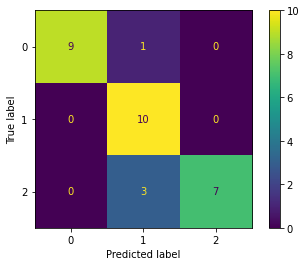

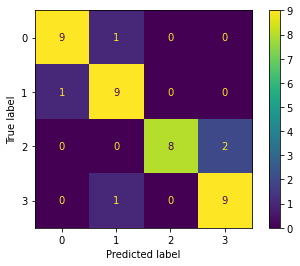

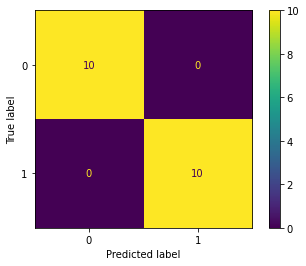

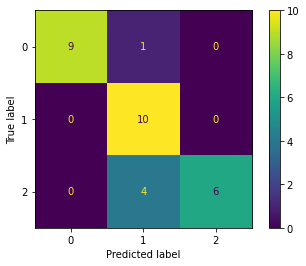

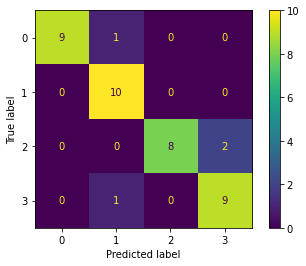

In [31]:
n_exps = 25

ground_truth = [0,1,2,3]

pred_iou = []
for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    known_classes = [0,1]
    known_classes_order = []
    
    model = None
    
    retrains = 0
    while len(known_classes) < len(ground_truth) and retrains < 2:
        print("Known classes:", known_classes)
        known_classes_order.append(known_classes.copy())
        
        feature_idxs = [*range(3,16),*range(22,28)]
        #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
        #feature_idxs = [*range(3,19),*range(22,28)] # with object position
        Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
        print()

        if model is None:
            model = train_classifier(Xtrain, Ttrain, len(known_classes))
        with torch.no_grad():
            weights = [[],[]]
            for i in range(len(model.conv_layers)):
                weights[0].append(model.conv_layers[i].weight.detach())
            for i in range(len(model.fc_layers)-1):
                weights[1].append(model.fc_layers[i].weight.detach())
        model = train_classifier(Xtrain, Ttrain, len(known_classes), pretrained=weights)
        print()

        # check classifier on the test data
        classes, probs = model.use(Xtest)

        # make confusion matrix
        cm = sklearn.metrics.confusion_matrix(Ttest, classes)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()

        novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
        gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
            else float('-inf') for i in range(len(dissimilarities))]
        
        gated_dissimilarities = [gated_dissimilarities[i] if gated_dissimilarities[i] == gated_dissimilarities[i] \
            else float('-inf') for i in range(len(gated_dissimilarities))]
        
        if np.max(gated_dissimilarities) == float('-inf'):
            print("No novel class found")
            retrains += 1
            print("Retraining (%s)" % retrains)
        else:
            new_class = np.argmax(gated_dissimilarities)
            known_classes.append(new_class)
            retrains = 0

            print("Most novel class:", known_classes[-1])
        print()
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
    print()

    with torch.no_grad():
        weights = [[],[]]
        for i in range(len(model.conv_layers)):
            weights[0].append(model.conv_layers[i].weight.detach())
        for i in range(len(model.fc_layers)-1):
            weights[1].append(model.fc_layers[i].weight.detach())
    model = train_classifier(Xtrain, Ttrain, len(known_classes), pretrained=weights)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
        else float('-inf') for i in range(len(dissimilarities))]
    
    gated_dissimilarities = [gated_dissimilarities[i] if gated_dissimilarities[i] == gated_dissimilarities[i] \
        else float('-inf') for i in range(len(gated_dissimilarities))]
    
    if np.max(gated_dissimilarities) != float('-inf'):
        new_class = np.argmax(gated_dissimilarities)
        known_classes.append(new_class)
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    print("Order of acquisition:", known_classes_order)

    pred_iou.append(np.intersect1d(known_classes[2:],ground_truth[2:]).shape[0]/\
                    np.union1d(known_classes[2:],ground_truth[2:]).shape[0])
    print(pred_iou,pred_iou[-1])
    print()
    
print(np.sum(pred_iou)/len(pred_iou))

# I: Given cube and sphere (no VoxML features)

Like (A), but the training data drops the VoxML-derived "jitter" features.

========== Experiment 1 ==========
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.006064713001251221
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 4.231929779052734e-06
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimila

Outlier ratio: 4.735854213538281
Dissimilarity from most similar class: 0.0
Likely novel class: False

========== Experiment 5 ==========
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.007197439670562744
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 4.172325134277344e-07
Angle from sim_mean to new_mean: 0.

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 4.807694594519627
Dissimilarity from most similar class: 0.7301720570318834
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 2.7298927307128906e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 458.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.013111591339111328
Angle from sim_mean to new_mean: 4.172325134277344e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 3.182165327126596e-05


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 1.9968452674842274
Dissimilarity from most similar class: 0.04824786654297361
Likely novel class: False

========== Experiment 8 ==========
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.013951480388641357
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 1.1920928955078125e-07
Angle from sim_me

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 4.961833035365505
Dissimilarity from most similar class: 0.6345437321699606
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 3.9696693420410156e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 666.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.009387671947479248
Angle from sim_mean to new_mean: 1.7881393432617188e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00019047739985650702


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 1.9294161238382845
Dissimilarity from most similar class: 0.35249038565357477
Likely novel class: False

========== Experiment 10 ==========
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.014609277248382568
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Outlier ratio: 5.657708546562056
Dissimilarity from most similar class: 1.1685597697820658
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 3.93986701965332e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.014609277248382568
Angle from sim_mean to new_mean: 2.0265579223632812e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00013871719236402654
Outlier ratio: 2.1970451793398253
Dissimilarity from most similar class: 0.2084954320635687
Likely novel class: False

True [False False False False False False False False False False] 0.0
True [ True  True  True  True  True  True  True  True  True  True] 1.0
False [False False False False False False False False False False] 1.0
[0.0, 1.0, 1.0] 0.6666666666666666


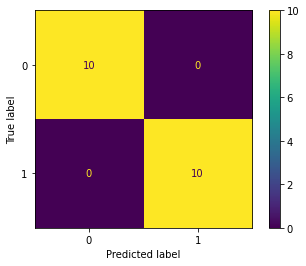

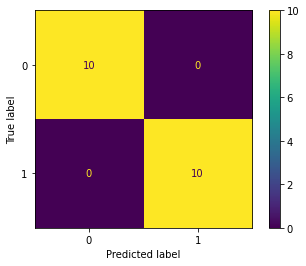

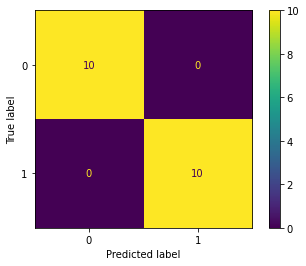

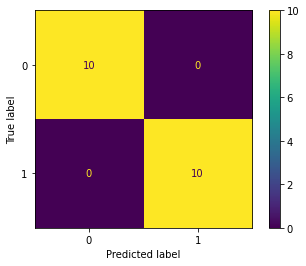

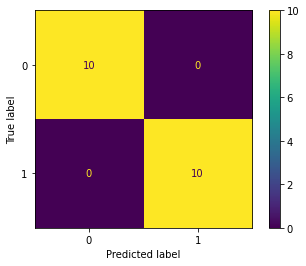

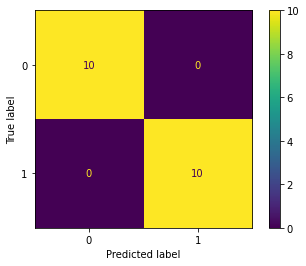

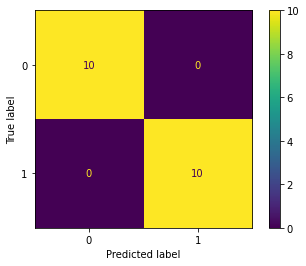

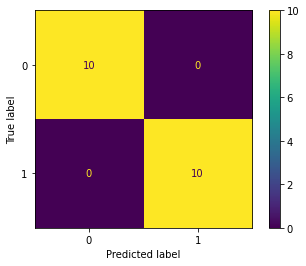

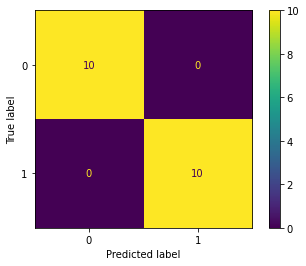

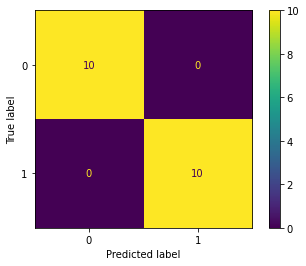

In [32]:
ground_truth = [False, False, True, True, False]
novelty_judgments = []
n_exps = 10

for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    
    #feature_idxs = [*range(3,16),*range(22,28)]
    feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1], crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, 2)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    novelty_judgments.append(novel_classes)
    
novelty_judgments = np.array(novelty_judgments).reshape(n_exps,-1).T

pred_acc = []
for i in range(2,len(ground_truth)):
    pred_acc.append(np.sum(novelty_judgments[i] == ground_truth[i])/n_exps)
    print(ground_truth[i], novelty_judgments[i], pred_acc[-1])
    
print(pred_acc, np.mean(pred_acc))

# J: Given cube, sphere, and cylinder (no VoxML features)

Like (B), but the training data drops the VoxML-derived "jitter" features.

========== Experiment 1 ==========
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.260
adam: Epoch 100 Loss 0.252
adam: Epoch 150 Loss 0.238
adam: Epoch 200 Loss 0.226
adam: Epoch 250 Loss 0.202
adam: Epoch 300 Loss 0.182
adam: Epoch 350 Loss 0.169
adam: Epoch 400 Loss 0.160
adam: Epoch 450 Loss 0.151
adam: Epoch 500 Loss 0.138

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.016366302967071533
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.000443875789642334
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilar

adam: Epoch 50 Loss 0.259
adam: Epoch 100 Loss 0.254
adam: Epoch 150 Loss 0.244
adam: Epoch 200 Loss 0.226
adam: Epoch 250 Loss 0.205
adam: Epoch 300 Loss 0.178
adam: Epoch 350 Loss 0.160
adam: Epoch 400 Loss 0.147
adam: Epoch 450 Loss 0.135
adam: Epoch 500 Loss 0.125

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0015129446983337402
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.017326653003692627
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0015129446983337402
Angle from sim_mean to new_mean: 0.0001101493835449

adam: Epoch 50 Loss 0.262
adam: Epoch 100 Loss 0.256
adam: Epoch 150 Loss 0.250
adam: Epoch 200 Loss 0.239
adam: Epoch 250 Loss 0.216
adam: Epoch 300 Loss 0.200
adam: Epoch 350 Loss 0.186
adam: Epoch 400 Loss 0.168
adam: Epoch 450 Loss 0.160
adam: Epoch 500 Loss 0.152

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.005986630916595459
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 3.1888484954833984e-05
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.005986630916595459
Angle from sim_mean to new_mean: 0.0002697110176086

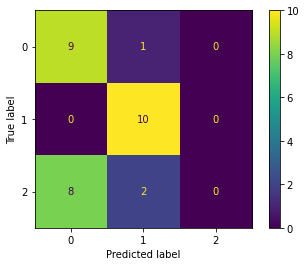

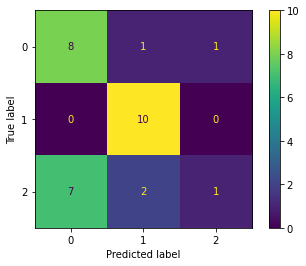

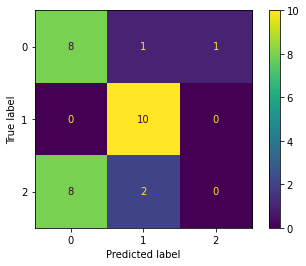

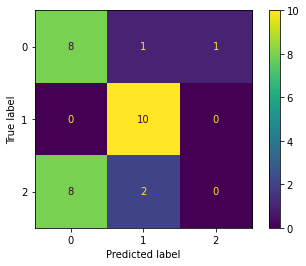

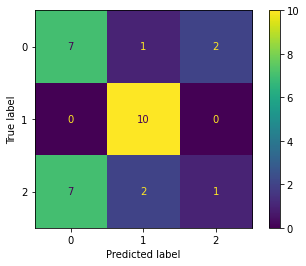

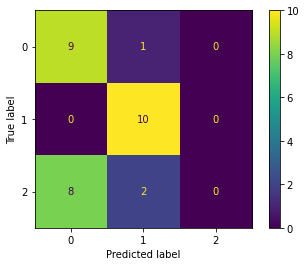

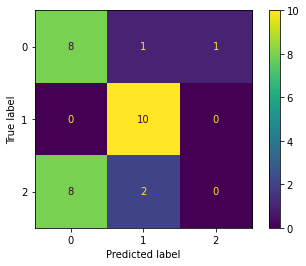

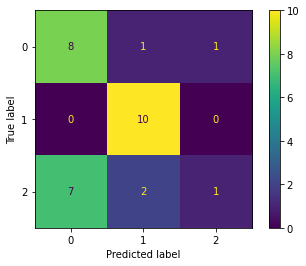

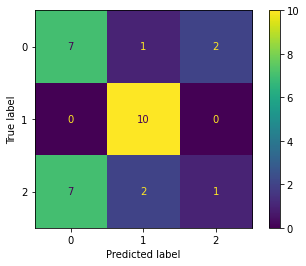

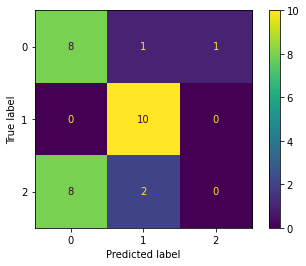

In [39]:
ground_truth = [False, False, False, True, False]
novelty_judgments = []
n_exps = 10

for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    
    #feature_idxs = [*range(3,16),*range(22,28)]
    feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1,2], crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, 3)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    novelty_judgments.append(novel_classes)
    
novelty_judgments = np.array(novelty_judgments).reshape(n_exps,-1).T

pred_acc = []
for i in range(2,len(ground_truth)):
    pred_acc.append(np.sum(novelty_judgments[i] == ground_truth[i])/n_exps)
    print(ground_truth[i], novelty_judgments[i], pred_acc[-1])
    
print(pred_acc, np.mean(pred_acc))

# K: Given cube, sphere, and capsule (no VoxML features)

Like (C), but the training data drops the VoxML-derived "jitter" features.

========== Experiment 1 ==========
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.023
adam: Epoch 100 Loss 0.009
adam: Epoch 150 Loss 0.006
adam: Epoch 200 Loss 0.003
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.013603448867797852
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 1.8477439880371094e-06
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimil

adam: Epoch 50 Loss 0.025
adam: Epoch 100 Loss 0.007
adam: Epoch 150 Loss 0.003
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01959371566772461
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 1.7881393432617188e-07
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01959371566772461
Angle from sim_mean to new_mean: 0.000384032726287841

adam: Epoch 50 Loss 0.025
adam: Epoch 100 Loss 0.011
adam: Epoch 150 Loss 0.008
adam: Epoch 200 Loss 0.005
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01797473430633545
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.00038939714431762695
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01797473430633545
Angle from sim_mean to new_mean: 0.000259935855865478

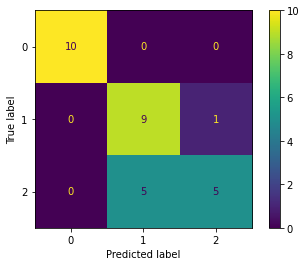

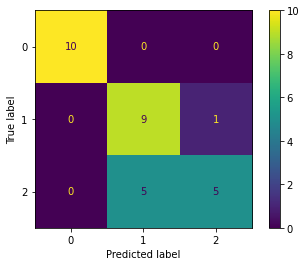

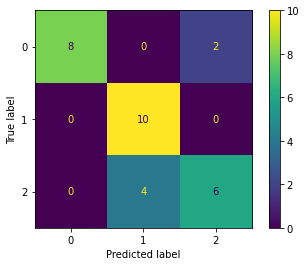

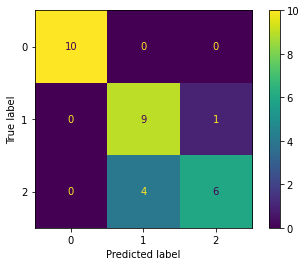

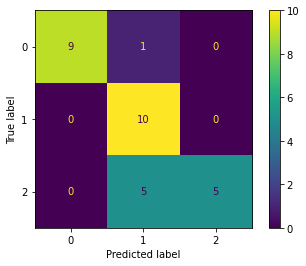

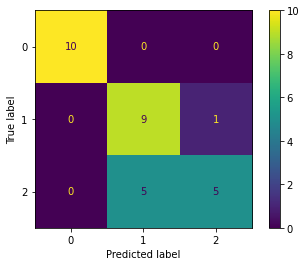

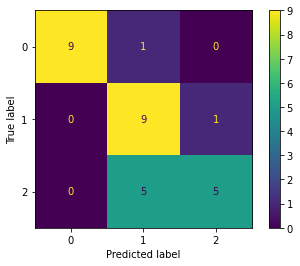

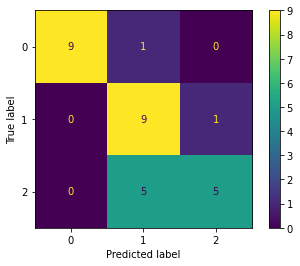

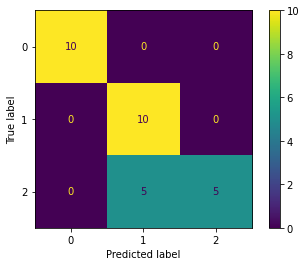

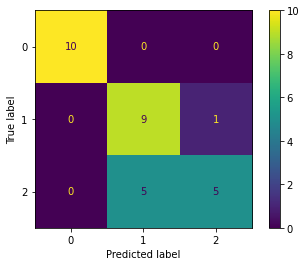

In [40]:
ground_truth = [False, False, True, False, False]
novelty_judgments = []
n_exps = 10

for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    
    #feature_idxs = [*range(3,16),*range(22,28)]
    feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1,3], crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, 3)
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    novelty_judgments.append(novel_classes)
    
novelty_judgments = np.array(novelty_judgments).reshape(n_exps,-1).T

pred_acc = []
for i in range(2,len(ground_truth)):
    pred_acc.append(np.sum(novelty_judgments[i] == ground_truth[i])/n_exps)
    print(ground_truth[i], novelty_judgments[i], pred_acc[-1])
    
print(pred_acc, np.mean(pred_acc))

# L: Multi-class learning (no VoxML features)

Like (E), but the training data drops the VoxML-derived "jitter" features.

========== Experiment 1 ==========
Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.012871325016021729
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissi

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Angle from sim_mean to sim_mean+std: 0.012871325016021729
Angle from sim_mean to new_mean: 3.0994415283203125e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00024080205607909422
Outlier ratio: 4.850681947667967
Dissimilarity from most similar class: 0.9050328216331816
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 4.5418739318847656e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.012871325016021729
Angle from sim_mean to new_mean: 2.384185791015625e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 1.852323508300725e-05
Outlier ratio: 2.0006250885137145
Dissimilarity from most similar class: 0.02871335155982452
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.014245390892028809
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to n

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Angle from sim_mean to sim_mean+std: 0.008724391460418701
Angle from sim_mean to new_mean: 8.940696716308594e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00010247931625800193
Outlier ratio: 5.454823419445345
Dissimilarity from most similar class: 0.5120657071631664
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 4.0650367736816406e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.008724391460418701
Angle from sim_mean to new_mean: 1.1920928955078125e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00013663908834400258
Outlier ratio: 2.0606663928847286
Dissimilarity from most similar class: 0.2579238012699798
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.012675166130065918
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to 

Angle from sim_mean to sim_mean+std: 0.018424689769744873
Angle from sim_mean to new_mean: 0.00031566619873046875
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.017132782297850313
Outlier ratio: 2.032306118519904
Dissimilarity from most similar class: 20.476660996660332
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 3, 2]
(3600, 19) (3600,) (400, 19) (400,)
(360, 190) (360,) (40, 190) (40,)
(360, 1, 190) (360,) (40, 1, 190) (40,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.059
adam: Epoch 100 Loss 0.037
adam: Epoch 150 Loss 0.006
adam: Epoch 200 Loss 0.003
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.001

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.17282462120056152
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim

Angle from sim_mean to sim_mean+std: 0.1678343415260315
Angle from sim_mean to new_mean: 0.0011091828346252441
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.006608795461882319
Outlier ratio: 1.2296145249380181
Dissimilarity from most similar class: 4.709593736191161
Likely novel class: False

Known classes: [0, 1, 3, 2]
Order of acquisition: [[0, 1], [0, 1, 3], [0, 1, 3, 2], [0, 1, 3, 2]]
[1.0, 1.0, 1.0] 1.0

========== Experiment 4 ==========
Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_me

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 4.858996389661622
Dissimilarity from most similar class: 0.5930565130585704
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: -1.1920928955078125e-07
Angle from sim_mean to new_mean: 4.458427429199219e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: -374.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.011370420455932617
Angle from sim_mean to new_mean: 7.152557373046875e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 6.290495061961377e-05


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 2.2064678756307674
Dissimilarity from most similar class: 0.11969185399698573
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.010507524013519287
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.96046447753906

adam: Epoch 50 Loss 0.035
adam: Epoch 100 Loss 0.007
adam: Epoch 150 Loss 0.002
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.014147520065307617
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 1.1742115020751953e-05
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.014147520065307617
Angle from sim_mean to new_mean: 0.0003819465637207

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 3.5762786865234375e-07
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01145559549331665
Angle from sim_mean to new_mean: 2.9802322387695312e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0002601551565353577
Outlier ratio: 4.817769552374808
Dissimilarity from most similar class: 1.0791352344508474
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 3.5762786865234375e-07
Angle from sim_mean to new_mean: 5.40614128112793e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 151.16666666666666
Outlier ratio: 1963541.

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 2.907465309832125
Dissimilarity from most similar class: 22.08722137285347
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.08887672424316406
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.020840704441070557
Angle from sim_mean to new_mean: 0.0004299283027648926
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.020629259628942166
Outlier ratio: 2.5033848226750153
Dissimilarity from most similar class: 23.062114793282493
Likely novel class: False

No novel class found
Retraining (3)

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
ad

Outlier ratio: 7.204703277257735
Dissimilarity from most similar class: 0.5599943074560818
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 4.410743713378906e-06
Angle from sim_mean to new_mean: 6.884336471557617e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 15.608108108108109
Outlier ratio: 215872.84583901774
Dissimilarity from most similar class: 133499773.10445583
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.007482945919036865
Angle from sim_mean to new_mean: 1.3113021850585938e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00017523876281433454
Outlier ratio: 2.0579684523477395
Dissimilarity from most similar class: 0.27069831625221835
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not 

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 4.984451749766639
Dissimilarity from most similar class: 0.4559031300484464
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 2.8371810913085938e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 476.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.009900271892547607
Angle from sim_mean to new_mean: 1.1324882507324219e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0001143896110151175


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 1.9955274759985713
Dissimilarity from most similar class: 0.21674371241672094
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.013368785381317139
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.96046447753906

Outlier ratio: 2.5057275936653522
Dissimilarity from most similar class: 0.11689735154331922
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.041
adam: Epoch 100 Loss 0.010
adam: Epoch 150 Loss 0.004
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.02730458974838257
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 6.616115570068359e-06
Angle fr

adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.011691749095916748
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 1.1920928955078125e-07
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.011691749095916748
Angle from sim_mean to new_mean: 1.3113021850585938

adam: Epoch 50 Loss 0.036
adam: Epoch 100 Loss 0.011
adam: Epoch 150 Loss 0.008
adam: Epoch 200 Loss 0.007
adam: Epoch 250 Loss 0.004
adam: Epoch 300 Loss 0.002
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.014530420303344727
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 8.940696716308594e-07
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.014530420303344727
Angle from sim_mean to new_mean: 0.00040477514266967

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 4.834585725238415
Dissimilarity from most similar class: 0.5209736155468639
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 3.743171691894531e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 628.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.012389123439788818
Angle from sim_mean to new_mean: 4.172325134277344e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 3.367732313391547e-05


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 1.9998506123405513
Dissimilarity from most similar class: 0.053875836694016195
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.011602461338043213
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 2.9802322387695

Angle from sim_mean to sim_mean+std: 0.009033381938934326
Angle from sim_mean to new_mean: 8.344650268554688e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 9.237570518953515e-05
Outlier ratio: 1.9549744496196129
Dissimilarity from most similar class: 0.18900137060330685
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.048
adam: Epoch 100 Loss 0.010
adam: Epoch 150 Loss 0.008
adam: Epoch 200 Loss 0.006
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.039584994316101074
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_

Angle from sim_mean to sim_mean+std: 0.01460278034210205
Angle from sim_mean to new_mean: 0.00011563301086425781
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.007918561270888266
Outlier ratio: 1.7660081231046736
Dissimilarity from most similar class: 4.8210884764108535
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 3, 2]
(3600, 19) (3600,) (400, 19) (400,)
(360, 190) (360,) (40, 190) (40,)
(360, 1, 190) (360,) (40, 1, 190) (40,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.058
adam: Epoch 100 Loss 0.013
adam: Epoch 150 Loss 0.004
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.11197656393051147
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim

Angle from sim_mean to sim_mean+std: 0.024982929229736328
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

Known classes: [0, 1, 3, 4, 2]
Order of acquisition: [[0, 1], [0, 1, 3], [0, 1, 3, 4], [0, 1, 3, 4, 2]]
[1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.6666666666666666] 0.6666666666666666

========== Experiment 14 ==========
Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most simila

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Outlier ratio: 4.838255066003022
Dissimilarity from most similar class: 1.0303470180461527
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 3.147125244140625e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.011213839054107666
Angle from sim_mean to new_mean: 2.384185791015625e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 2.1261102281847802e-05
Outlier ratio: 2.0000562486917643
Dissimilarity from most similar class: 0.0378603344231716
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.014636635780334473
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Outlier ratio: 5.778702888544848
Dissimilarity from most similar class: 0.5304438606769852
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 2.866983413696289e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.014636635780334473
Angle from sim_mean to new_mean: 1.6093254089355469e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0001099518655166516
Outlier ratio: 2.000010409426285
Dissimilarity from most similar class: 0.15020733530890495
Likely novel class: False

No novel class found
Retraining (2)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.012431561946868896
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim

Angle from sim_mean to sim_mean+std: 0.010712504386901855
Angle from sim_mean to new_mean: 1.0728836059570312e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00010015245429153267
Outlier ratio: 1.9767484393995343
Dissimilarity from most similar class: 0.17762595743812706
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.023
adam: Epoch 100 Loss 0.009
adam: Epoch 150 Loss 0.005
adam: Epoch 200 Loss 0.003
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01592916250228882
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Outlier ratio: 5.36718968564537
Dissimilarity from most similar class: 0.6807733056665255
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 5.728006362915039e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.007690727710723877
Angle from sim_mean to new_mean: 1.3113021850585938e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00017050430523370716
Outlier ratio: 2.088322627164567
Dissimilarity from most similar class: 0.36421335456869697
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.012935280799865723
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from si

Angle from sim_mean to sim_mean+std: 0.021690428256988525
Angle from sim_mean to new_mean: 0.00014495849609375
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.006683062887292013
Outlier ratio: 1.2227297751672463
Dissimilarity from most similar class: 3.2857940508865773
Likely novel class: False

No novel class found
Retraining (3)

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.024
adam: Epoch 100 Loss 0.005
adam: Epoch 150 Loss 0.002
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.013079345226287842
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 12.817802576941615
Dissimilarity from most similar class: 3.9200221492232443
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0006579756736755371
Angle from sim_mean to new_mean: 0.0002117753028869629
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.3218588640275387
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.0035048723220825195
Angle from sim_mean to new_mean: 5.960464477539063e-08
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 1.700622427808578e-05
Outlier ratio: 2.9229988790350183
Dissimilarity from most similar class: 0.0388665288296986
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0077928900718688965
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from si

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Angle from sim_mean to sim_mean+std: 0.007746398448944092
Angle from sim_mean to new_mean: 8.940696716308594e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00011541746497079938
Outlier ratio: 5.932999029346888
Dissimilarity from most similar class: 0.6573587901602053
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 4.6193599700927734e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.007746398448944092
Angle from sim_mean to new_mean: 1.0728836059570312e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00013850095796495926
Outlier ratio: 2.1006745950787935
Dissimilarity from most similar class: 0.2792982577972784
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.013257324695587158
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from si

Angle from sim_mean to sim_mean+std: 0.012833178043365479
Angle from sim_mean to new_mean: 2.384185791015625e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 1.857829590580804e-05
Outlier ratio: 2.161692998710599
Dissimilarity from most similar class: 0.031150161656138656
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.042
adam: Epoch 100 Loss 0.010
adam: Epoch 150 Loss 0.005
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.03295499086380005
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_m

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Outlier ratio: 4.80848426117783
Dissimilarity from most similar class: 0.3095253798431879
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 1.4662742614746094e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.013257145881652832
Angle from sim_mean to new_mean: 2.384185791015625e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 1.7984155958600475e-05
Outlier ratio: 2.1778705577426165
Dissimilarity from most similar class: 0.02951389449935827
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.003
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.011221706867218018
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from si

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 4.6655760916113085
Dissimilarity from most similar class: 0.2618193204827197
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 1.531839370727539e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 257.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.011221706867218018
Angle from sim_mean to new_mean: 4.172325134277344e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 3.718084230542469e-05


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 1.992555111522293
Dissimilarity from most similar class: 0.06522642123138034
Likely novel class: False

No novel class found
Retraining (2)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.005676150321960449
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 9.238719940185547

adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0055869221687316895
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 8.344650268554688e-07
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0055869221687316895
Angle from sim_mean to new_mean: 5.960464477539062

adam: Epoch 50 Loss 0.028
adam: Epoch 100 Loss 0.005
adam: Epoch 150 Loss 0.002
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.010102629661560059
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 3.337860107421875e-06
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.010102629661560059
Angle from sim_mean to new_mean: 0.00051158666610717

Outlier ratio: 1.487665230537849
Dissimilarity from most similar class: 7.399444012453404
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.050
adam: Epoch 100 Loss 0.011
adam: Epoch 150 Loss 0.009
adam: Epoch 200 Loss 0.008
adam: Epoch 250 Loss 0.007
adam: Epoch 300 Loss 0.005
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.017966628074645996
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 8.22544097900390

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Angle from sim_mean to sim_mean+std: 0.013579189777374268
Angle from sim_mean to new_mean: 3.0994415283203125e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00022824937121687641
Outlier ratio: 4.8575106149599545
Dissimilarity from most similar class: 0.8136599002235106
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 4.1544437408447266e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.013579189777374268
Angle from sim_mean to new_mean: 3.5762786865234375e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 2.6336465909639587e-05
Outlier ratio: 1.9997830567157429
Dissimilarity from most similar class: 0.03865092980686584
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.003
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.013232171535491943
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from s

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Angle from sim_mean to sim_mean+std: 0.026246190071105957
Angle from sim_mean to new_mean: 0.000324249267578125
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.01235414613319768
Outlier ratio: 4.158256247254186
Dissimilarity from most similar class: 22.401286960711662
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.19813436269760132
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.026246190071105957
Angle from sim_mean to new_mean: 0.00027638673782348633
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.010530546988903978
Outlier ratio: 2.975976834892866
Dissimilarity from most similar class: 13.665623874489867
Likely novel class: False

No novel class found
Retraining (

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 5.692268176850646
Dissimilarity from most similar class: 0.39661615641363196
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 4.106760025024414e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 689.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.015042304992675781
Angle from sim_mean to new_mean: 4.589557647705078e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0003051099980980156


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 2.0041398924409437
Dissimilarity from most similar class: 0.4135523174707896
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.003
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01293647289276123
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.960464477539063e

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 4.8139806300981025
Dissimilarity from most similar class: 0.3067358384256649
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 1.4483928680419922e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 243.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.01293647289276123
Angle from sim_mean to new_mean: 4.172325134277344e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 3.225241662750302e-05
Outlier ratio: 2.000120439613525
Dissimilarity from most similar class: 0.04956120597219574
Likely novel class: False

No novel class found
Retraining (2)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.013797223567962646
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_m

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Outlier ratio: 4.813983388537128
Dissimilarity from most similar class: 1.2175788173455824
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 8.577108383178711e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.013797223567962646
Angle from sim_mean to new_mean: 2.384185791015625e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 1.728018524358581e-05
Outlier ratio: 2.000236466443987
Dissimilarity from most similar class: 0.02498324285792624
Likely novel class: False

No novel class found
Retraining (3)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.005006134510040283
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_

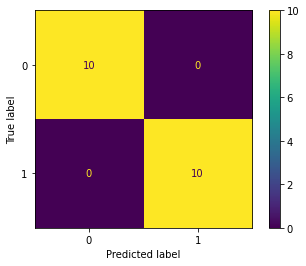

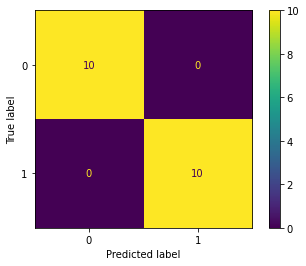

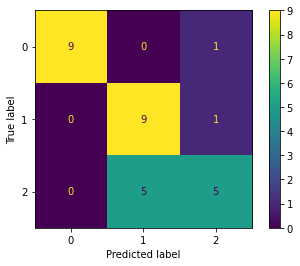

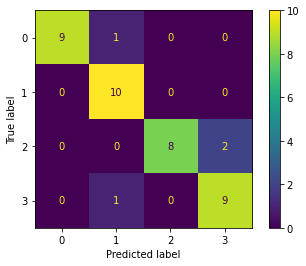

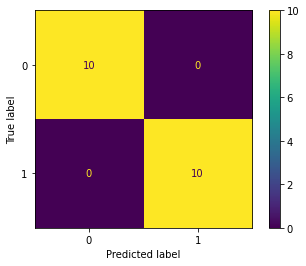

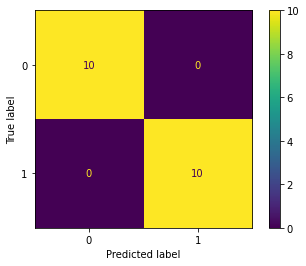

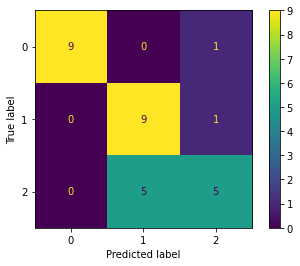

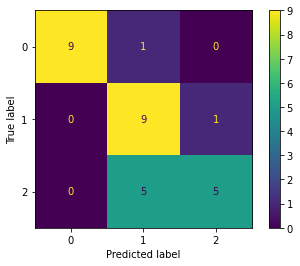

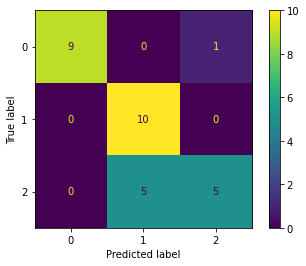

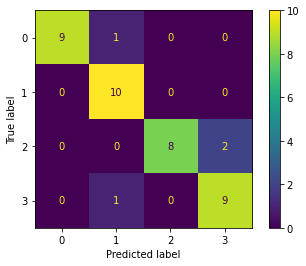

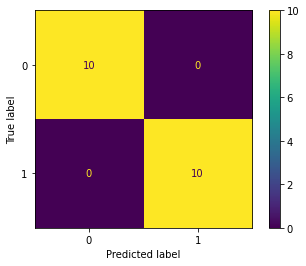

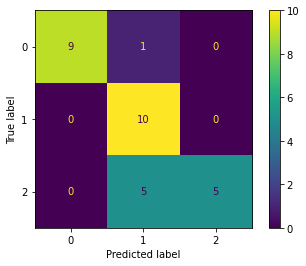

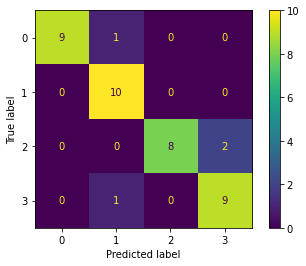

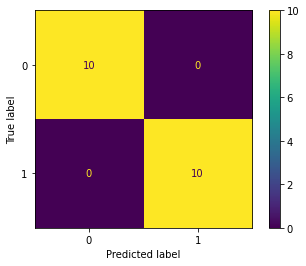

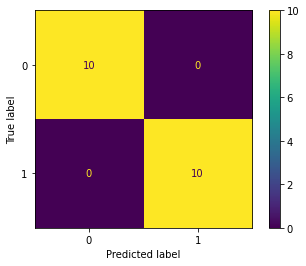

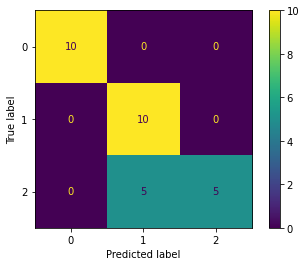

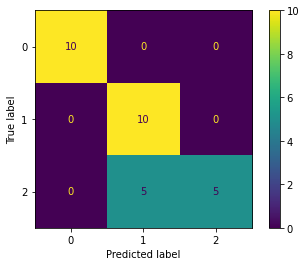

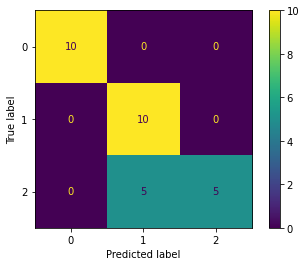

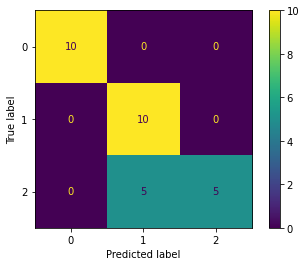

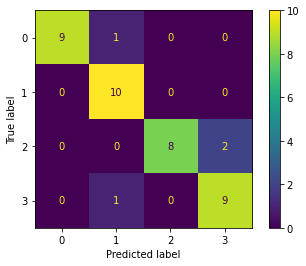

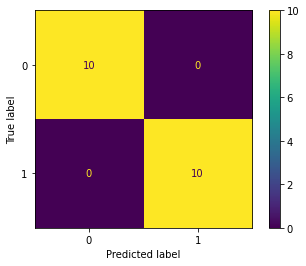

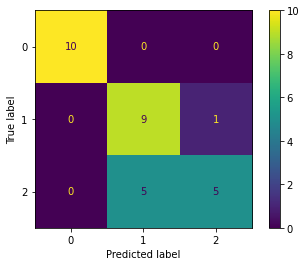

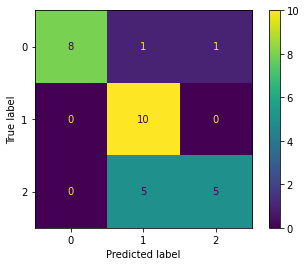

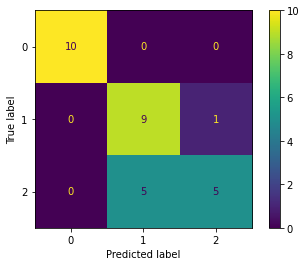

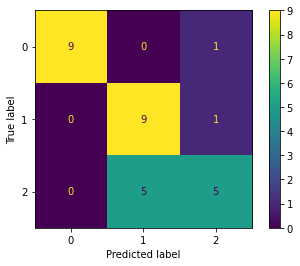

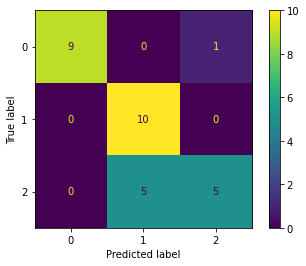

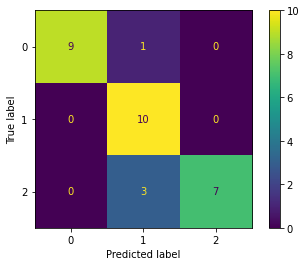

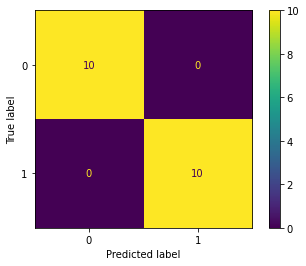

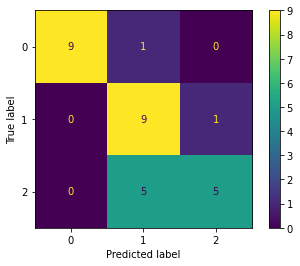

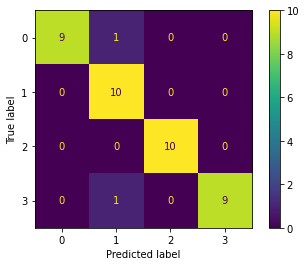

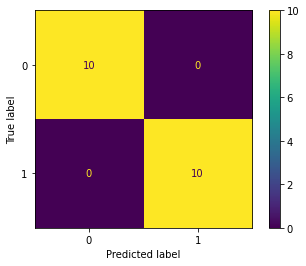

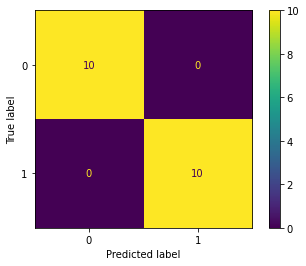

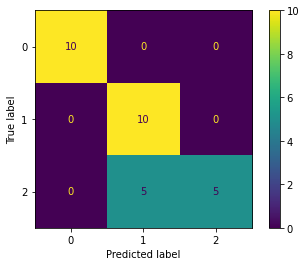

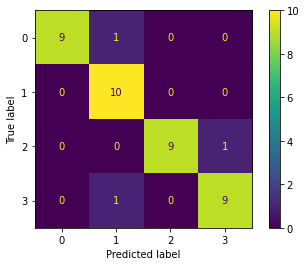

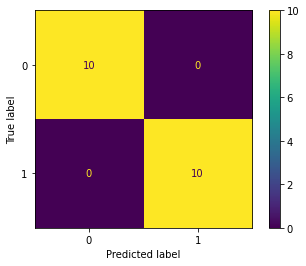

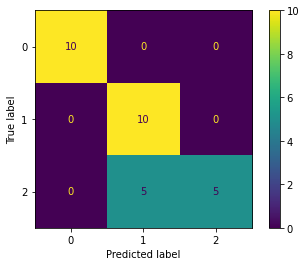

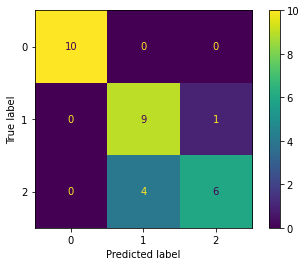

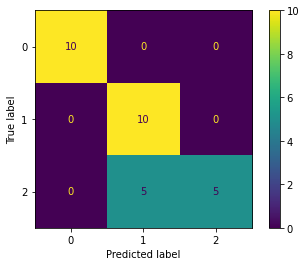

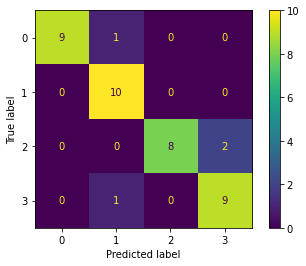

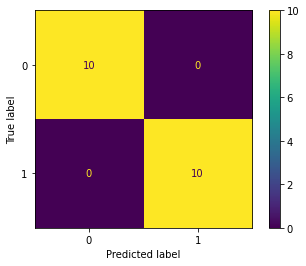

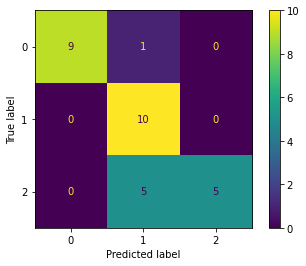

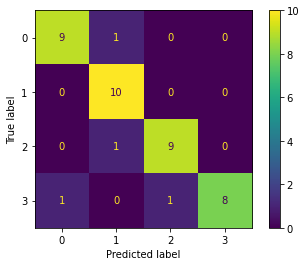

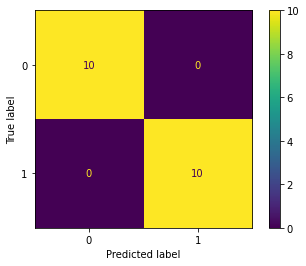

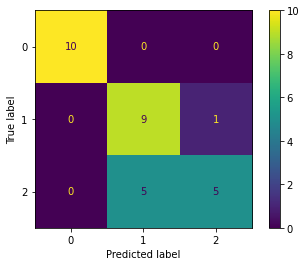

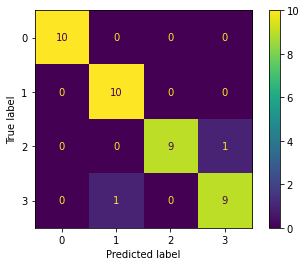

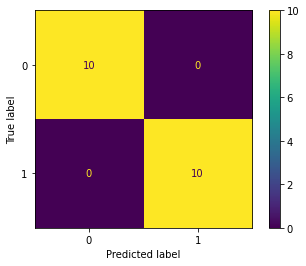

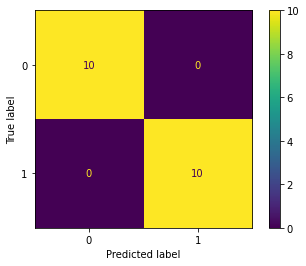

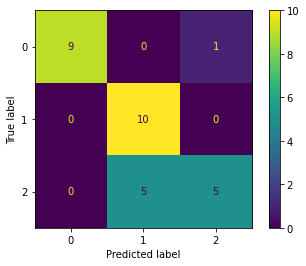

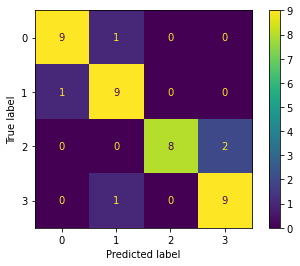

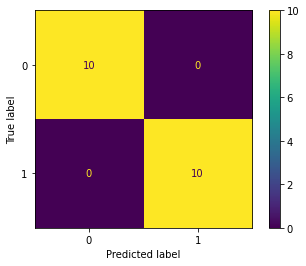

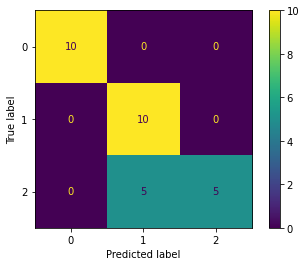

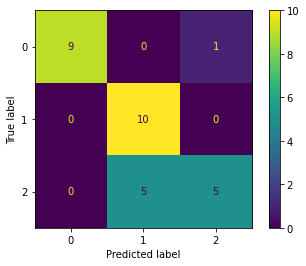

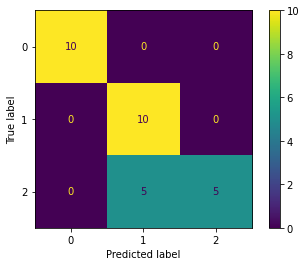

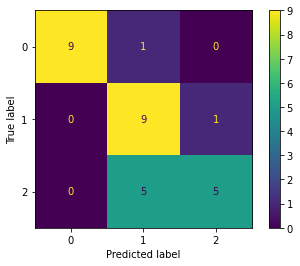

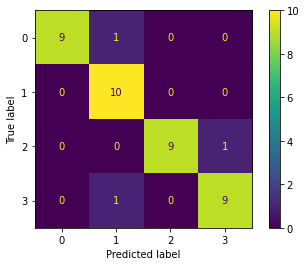

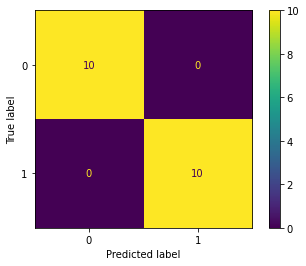

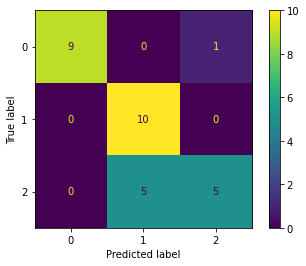

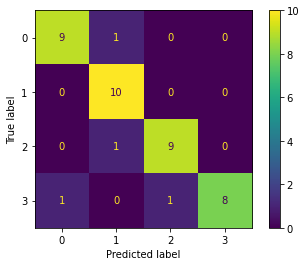

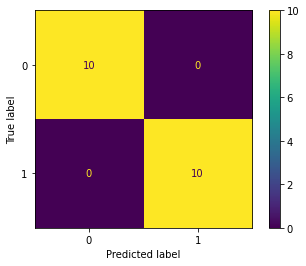

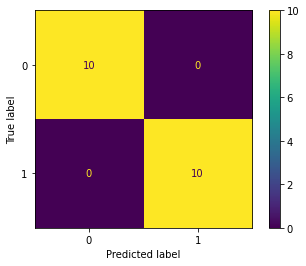

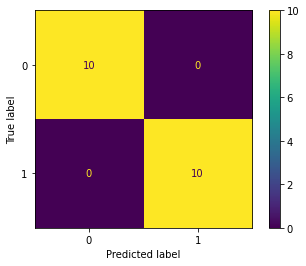

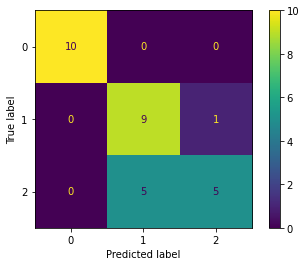

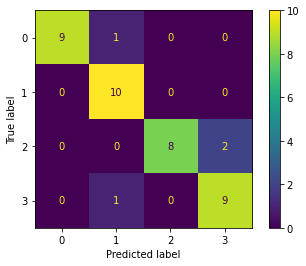

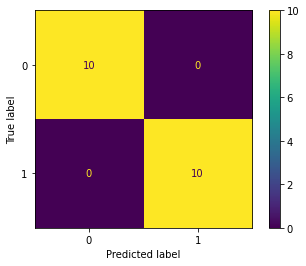

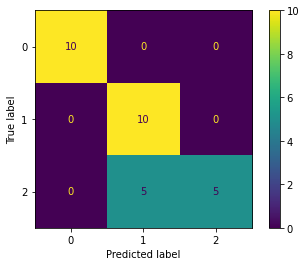

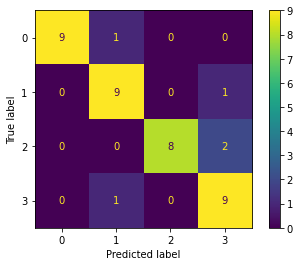

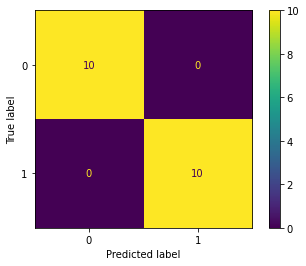

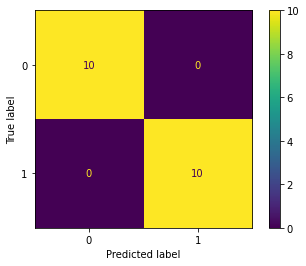

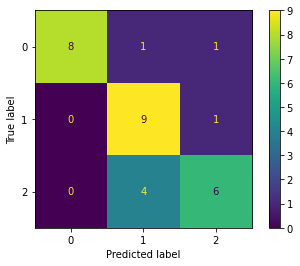

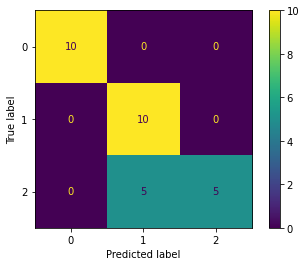

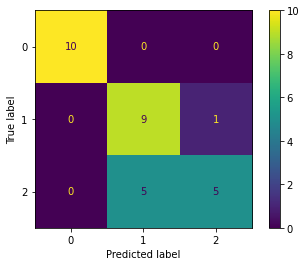

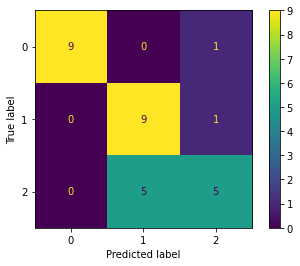

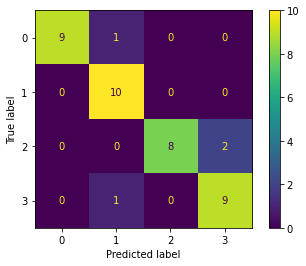

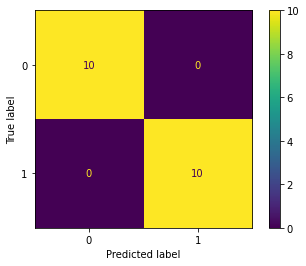

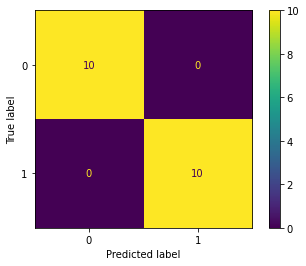

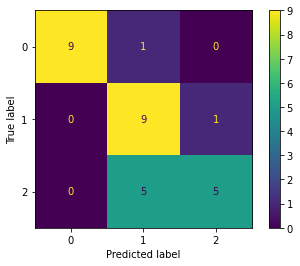

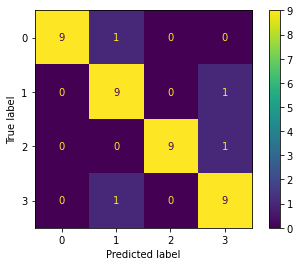

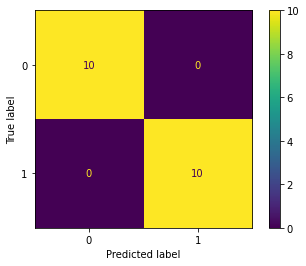

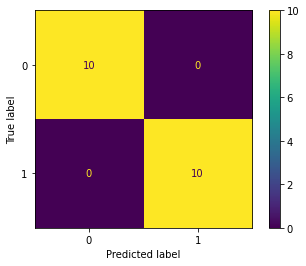

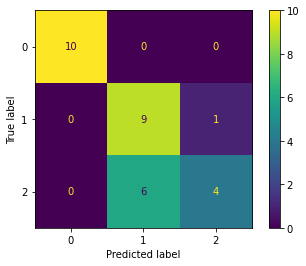

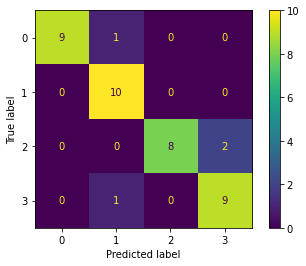

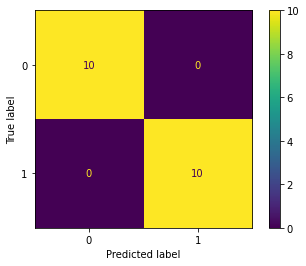

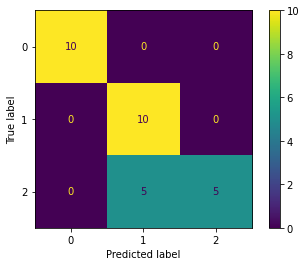

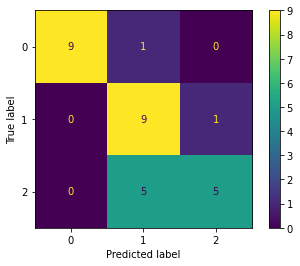

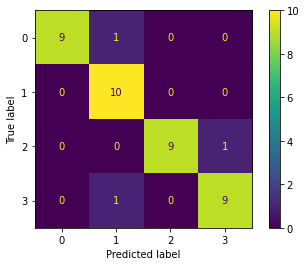

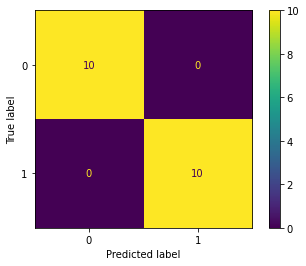

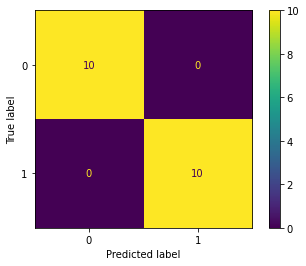

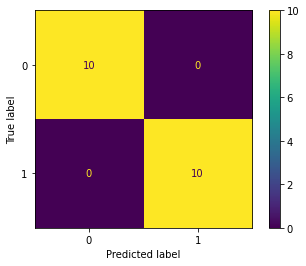

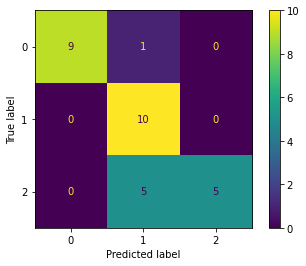

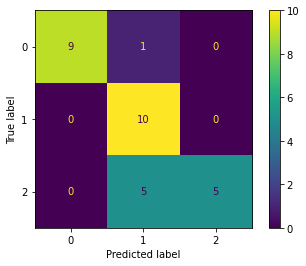

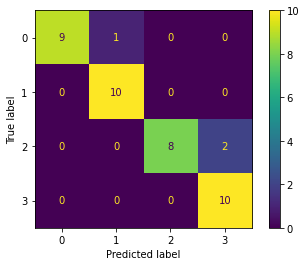

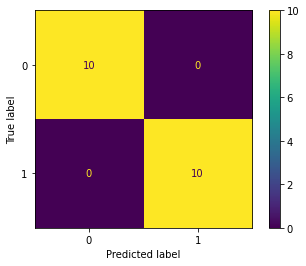

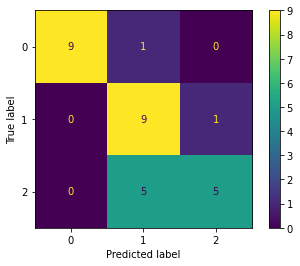

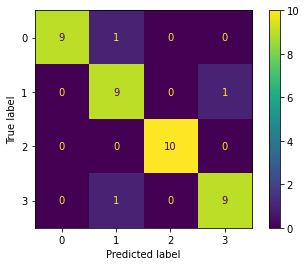

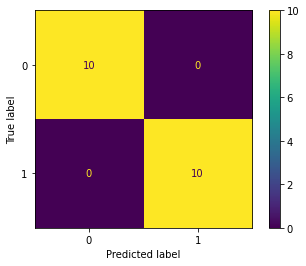

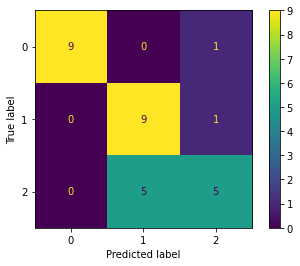

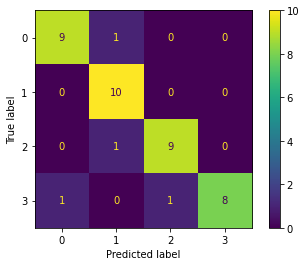

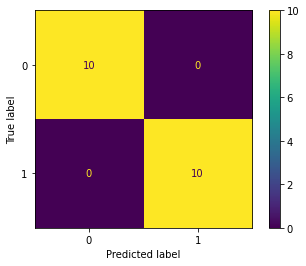

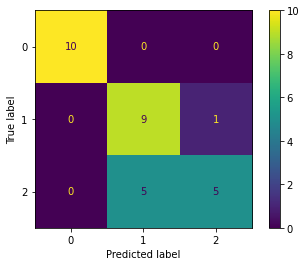

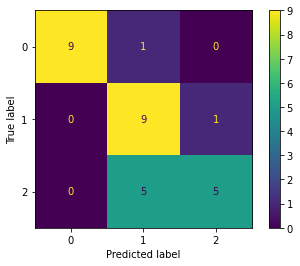

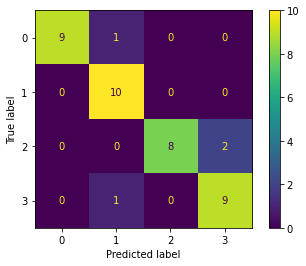

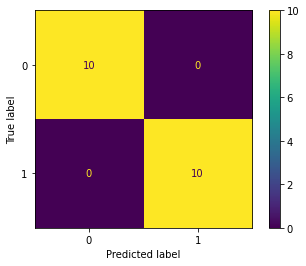

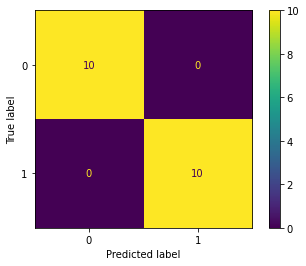

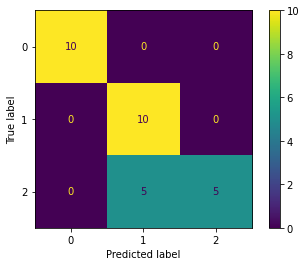

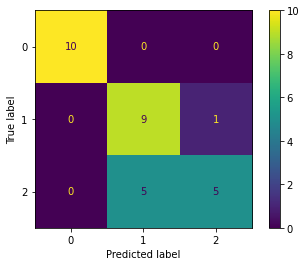

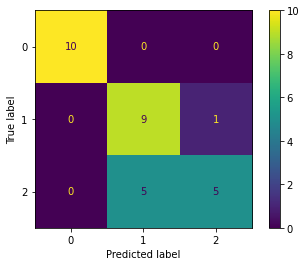

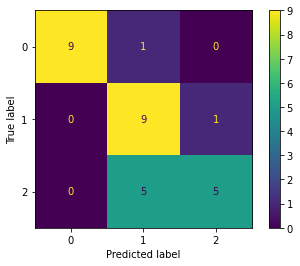

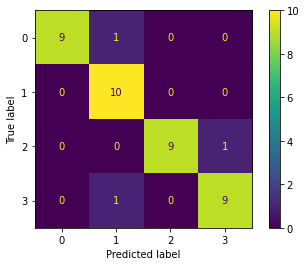

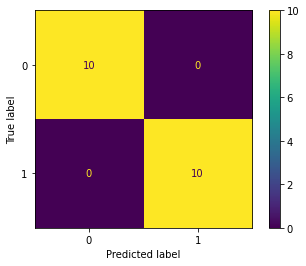

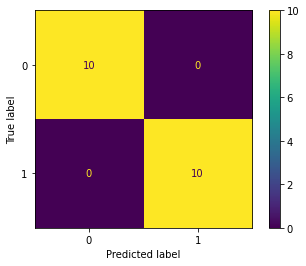

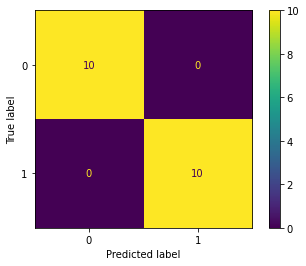

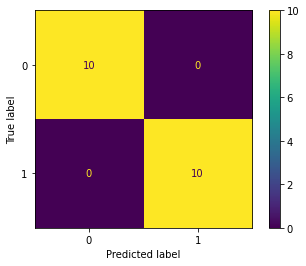

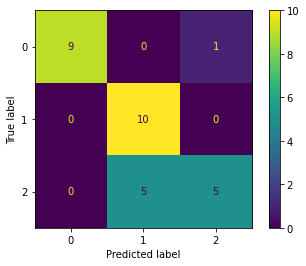

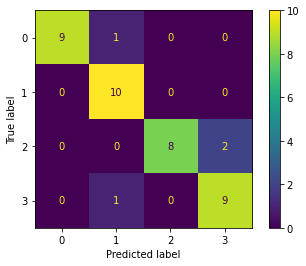

In [36]:
n_exps = 25

ground_truth = [0,1,2,3]

pred_iou = []
for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    known_classes = [0,1]
    known_classes_order = []
    
    model = None
    
    retrains = 0
    while len(known_classes) < len(ground_truth) and retrains < 5:
        print("Known classes:", known_classes)
        known_classes_order.append(known_classes.copy())
        
        #feature_idxs = [*range(3,16),*range(22,28)]
        feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
        #feature_idxs = [*range(3,19),*range(22,28)] # with object position
        Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
        print()

        model = train_classifier(Xtrain, Ttrain, len(known_classes))
        print()

        # check classifier on the test data
        classes, probs = model.use(Xtest)

        # make confusion matrix
        cm = sklearn.metrics.confusion_matrix(Ttest, classes)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()

        novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
        gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
            else float('inf') for i in range(len(dissimilarities))]
        
        gated_dissimilarities = [gated_dissimilarities[i] if gated_dissimilarities[i] == gated_dissimilarities[i] \
            else float('inf') for i in range(len(gated_dissimilarities))]
        
        if np.min(gated_dissimilarities) == float('inf'):
            print("No novel class found")
            retrains += 1
            print("Retraining (%s)" % retrains)
        else:
            new_class = np.argmin(gated_dissimilarities)
            known_classes.append(new_class)
            retrains = 0

            print("Most novel class:", known_classes[-1])
        print()
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, len(known_classes))
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
        else float('inf') for i in range(len(dissimilarities))]
    
    gated_dissimilarities = [gated_dissimilarities[i] if gated_dissimilarities[i] == gated_dissimilarities[i] \
        else float('inf') for i in range(len(gated_dissimilarities))]
    
    if np.min(gated_dissimilarities) != float('inf'):
        new_class = np.argmin(gated_dissimilarities)
        known_classes.append(new_class)
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    print("Order of acquisition:", known_classes_order)

    pred_iou.append(np.intersect1d(known_classes[2:],ground_truth[2:]).shape[0]/\
                    np.union1d(known_classes[2:],ground_truth[2:]).shape[0])
    print(pred_iou,pred_iou[-1])
    print()
    
print(np.sum(pred_iou)/len(pred_iou))

Same as above but limiting the number of retrains to 2.

========== Experiment 1 ==========
Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.011258959770202637
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlie

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 5.513563391686944
Dissimilarity from most similar class: 1.2978845190766364
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 5.525350570678711e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 927.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.01449209451675415
Angle from sim_mean to new_mean: 2.0265579223632812e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0001398388562826719
Outlier ratio: 2.003952580792437
Dissimilarity from most similar class: 0.19323773815033896
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.013808012008666992
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Outlier ratio: 5.7953521832527555
Dissimilarity from most similar class: 0.4709326034428914
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 2.3663043975830078e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.013808012008666992
Angle from sim_mean to new_mean: 1.1920928955078125e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 8.6333419666753e-05
Outlier ratio: 2.199586408575137
Dissimilarity from most similar class: 0.1374917375608043
Likely novel class: False

No novel class found
Retraining (2)

Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.000488579273223877
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_m

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 4.8171891049978735
Dissimilarity from most similar class: 0.7226142223207159
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 4.76837158203125e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 800.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.011784970760345459
Angle from sim_mean to new_mean: 3.5762786865234375e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 3.0346097239010918e-05
Outlier ratio: 2.199528808598908
Dissimilarity from most similar class: 0.05656211886893664
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.000
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.013582766056060791
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from si

Angle from sim_mean to sim_mean+std: 0.013016581535339355
Angle from sim_mean to new_mean: 0.00022900104522705078
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.017593025066168458
Outlier ratio: 2.14510088359952
Dissimilarity from most similar class: 29.841060644838347
Likely novel class: True

Known classes: [0, 1, 3, 4]
Order of acquisition: [[0, 1], [0, 1], [0, 1, 3], [0, 1, 3], [0, 1, 3], [0, 1, 3, 4]]
[1.0, 0.5, 0.3333333333333333] 0.3333333333333333

========== Experiment 4 ==========
Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Angle from sim_mean to sim_mean+std: 0.013086259365081787
Angle from sim_mean to new_mean: 4.0531158447265625e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00030972302562958036
Outlier ratio: 5.541375509483199
Dissimilarity from most similar class: 1.3107570839165221
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 3.36766242980957e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.013086259365081787
Angle from sim_mean to new_mean: 8.940696716308594e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 6.83212556535839e-05
Outlier ratio: 2.0000401075127052
Dissimilarity from most similar class: 0.10435798470629129
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.013950467109680176
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 4.834863043464725
Dissimilarity from most similar class: 0.6203419689727357
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 3.266334533691406e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 548.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.013950467109680176
Angle from sim_mean to new_mean: 2.980232238769531e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 2.1362956633198035e-05


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 1.9994605782493604
Dissimilarity from most similar class: 0.030540809750526213
Likely novel class: False

No novel class found
Retraining (2)

Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0014941096305847168
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.06941163539

Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.02225559949874878
Angle from sim_mean to new_mean: 0.0003750920295715332
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.01685382726233104
Outlier ratio: 2.465613299940643
Dissimilarity from most similar class: 15.429482436356755
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 3, 2]
(3600, 19) (3600,) (400, 19) (400,)
(360, 190) (360,) (40, 190) (40,)
(360, 1, 190) (360,) (40, 1, 190) (40,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.061
adam: Epoch 100 Loss 0.022
adam: Epoch 150 Loss 0.004
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.09021884202957153
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle f

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Angle from sim_mean to sim_mean+std: 0.1104246973991394
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0007671713829040527
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.14780539274215698
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.20674264430999756
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 4.844984295127838
Dissimilarity from most similar class: 0.7548776619075724
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: -1.1920928955078125e-07
Angle from sim_mean to new_mean: 3.3020973205566406e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: -277.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.013513922691345215
Angle from sim_mean to new_mean: 7.748603820800781e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 5.73379321295308e-05


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 2.1908976077814444
Dissimilarity from most similar class: 0.09245031527137394
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.011112570762634277
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 2.98023223876953

adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.013986170291900635
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 2
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.013986170291900635
Angle from sim_mean to new_mean: 3.337860107421875e-06
Angle from sim_

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Outlier ratio: 4.832592875243827
Dissimilarity from most similar class: 0.822780285892434
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 4.667043685913086e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.013986170291900635
Angle from sim_mean to new_mean: 2.980232238769531e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 2.130842236702479e-05
Outlier ratio: 1.999706694916285
Dissimilarity from most similar class: 0.030398485432648625
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01299738883972168
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 4.8560043839019045
Dissimilarity from most similar class: 0.8714713201112938
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 3.796815872192383e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 637.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01299738883972168
Angle from sim_mean to new_mean: 2.980232238769531e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 2.2929468953499036e-05


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 2.2004460508190355
Dissimilarity from most similar class: 0.038715474156644114
Likely novel class: False

No novel class found
Retraining (2)

Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.000552058219909668
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.014342129230

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Angle from sim_mean to sim_mean+std: 0.010856091976165771
Angle from sim_mean to new_mean: 1.430511474609375e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.000131770390095259
Outlier ratio: 4.846034386010577
Dissimilarity from most similar class: 0.5774772540518337
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 4.839897155761719e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.010856091976165771
Angle from sim_mean to new_mean: 7.748603820800781e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 7.137562796826529e-05
Outlier ratio: 2.0920052609040978
Dissimilarity from most similar class: 0.13503404403207075
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.011283040046691895
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim

Outlier ratio: 1.9847809555088889
Dissimilarity from most similar class: 0.23537389272712558
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.038
adam: Epoch 100 Loss 0.010
adam: Epoch 150 Loss 0.009
adam: Epoch 200 Loss 0.007
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.015653908252716064
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 1.9073486328125e-06
Angle fro

Angle from sim_mean to sim_mean+std: 0.03405869007110596
Angle from sim_mean to new_mean: 0.00039440393447875977
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.011580126354106508
Outlier ratio: 1.8122879600019748
Dissimilarity from most similar class: 10.682102629360239
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.024
adam: Epoch 100 Loss 0.009
adam: Epoch 150 Loss 0.003
adam: Epoch 200 Loss 0.001
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.019272267818450928
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from si

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 5.028455203854948
Dissimilarity from most similar class: 1.2195857761616054
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: -1.1920928955078125e-07
Angle from sim_mean to new_mean: 2.753734588623047e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: -231.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.013750851154327393
Angle from sim_mean to new_mean: 2.384185791015625e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 1.7338459737929182e-05


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 2.1982310289673515
Dissimilarity from most similar class: 0.027696211374935213
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.011312484741210938
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 1.1920928955078

adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.012529850006103516
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: nan
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 2
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Angle from sim_mean to sim_mean+std: 0.012529850006103516
Angle from sim_mean to new_mean: 1.0728836059570312e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 8.562621303801804e-05
Outlier ratio: 4.8098896049114455
Dissimilarity from most similar class: 0.3269302360030094
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 1.8298625946044922e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.012529850006103516
Angle from sim_mean to new_mean: 3.5762786865234375e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 2.854207101267268e-05
Outlier ratio: 2.199699418025807
Dissimilarity from most similar class: 0.04983816739692094
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.012377321720123291
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

0.012377321720123291
Angle from sim_mean to new_mean: 2.384185791015625e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00019262533890020562
Outlier ratio: 4.834829139430289
Dissimilarity from most similar class: 0.7501000329368741
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 3.790855407714844e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.012377321720123291
Angle from sim_mean to new_mean: 2.384185791015625e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 1.926253389002056e-05
Outlier ratio: 1.999951211333794
Dissimilarity from most similar class: 0.03102826234869577
Likely novel class: False

No novel class found
Retraining (2)

Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.003558635711669922
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim

Angle from sim_mean to sim_mean+std: 0.011839747428894043
Angle from sim_mean to new_mean: 8.499622344970703e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00717888822883839
Outlier ratio: 2.0898771305971557
Dissimilarity from most similar class: 9.747926966415543
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 3, 2]
(3600, 19) (3600,) (400, 19) (400,)
(360, 190) (360,) (40, 190) (40,)
(360, 1, 190) (360,) (40, 1, 190) (40,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.056
adam: Epoch 100 Loss 0.021
adam: Epoch 150 Loss 0.004
adam: Epoch 200 Loss 0.002
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.001
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.10073292255401611
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_m

Angle from sim_mean to sim_mean+std: 0.10888636112213135
Angle from sim_mean to new_mean: 0.0006172657012939453
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.005668898243386011
Outlier ratio: 1.4732330802467024
Dissimilarity from most similar class: 3.6387757630715263
Likely novel class: False

Known classes: [0, 1, 3, 2]
Order of acquisition: [[0, 1], [0, 1, 3], [0, 1, 3, 2], [0, 1, 3, 2]]
[1.0, 0.5, 0.3333333333333333, 0.5, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0] 1.0

========== Experiment 16 ==========
Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 50

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 4.954521074672345
Dissimilarity from most similar class: 0.8583720098483152
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 4.13060188293457e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 693.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.008977949619293213
Angle from sim_mean to new_mean: 1.3709068298339844e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00015269709543568464


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 1.9891198544212179
Dissimilarity from most similar class: 0.3170462692584494
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.012804567813873291
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.960464477539063

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 4.81612516258217
Dissimilarity from most similar class: 0.3245764458938829
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: -1.1920928955078125e-07
Angle from sim_mean to new_mean: 1.239776611328125e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: -104.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01362234354019165
Angle from sim_mean to new_mean: 2.384185791015625e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 1.7502023671487015e-05


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 2.0047862103175342
Dissimilarity from most similar class: 0.02573522671305703
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.014135658740997314
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.96046447753906

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 4.878549394491142
Dissimilarity from most similar class: 0.8144039501610132
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 2.6285648345947266e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 441.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.014135658740997314
Angle from sim_mean to new_mean: 1.1920928955078125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 8.43323199399554e-06
Outlier ratio: 1.999866600166756
Dissimilarity from most similar class: 0.011923181661994567
Likely novel class: False

No novel class found
Retraining (2)

Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0001754164695739746
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from s

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0001754164695739746
Angle from sim_mean to new_mean: 4.708766937255859e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.026843357118586476
Outlier ratio: 11.042399995609626
Dissimilarity from most similar class: 55.05796923746215
Likely novel class: True

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0037184953689575195
Angle from sim_mean to new_mean: 0.0011078715324401855
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.2979354342320392
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.0001754164695739746
Angle from sim_mean to new_mean: 1.1920928955078125e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0006795786612300374
Outlier ratio: 68.9799103998712
Dissimilarity from most similar class: 8.707274666736865
Likely novel class: False

Known classes: [0, 1, 2]
Order of acquisition: [[0, 1], [0, 1], [0, 1], [0, 1, 2]]
[1.0, 0.5, 0.3333333333333333, 0.5, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.5] 0.5

========== Experiment 18 ==========
Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Lo

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 4.81064338916746
Dissimilarity from most similar class: 0.499505369624974
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 4.1484832763671875e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 696.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.011080920696258545
Angle from sim_mean to new_mean: 8.344650268554688e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 7.530647043952084e-05
Outlier ratio: 1.9808636577840766
Dissimilarity from most similar class: 0.1308871273851385
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.013196945190429688
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 5.572240946747627
Dissimilarity from most similar class: 1.3719752294697842
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 2.2351741790771484e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 375.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.013196945190429688
Angle from sim_mean to new_mean: 2.980232238769531e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 2.2582743170978467e-05
Outlier ratio: 1.9999717723820092
Dissimilarity from most similar class: 0.034196192808065455
Likely novel class: False

No novel class found
Retraining (2)

Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0004049539566040039
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from

Outlier ratio: 7.958255117284548
Dissimilarity from most similar class: 52.14815657821352
Likely novel class: True

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.12282693386077881
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.014795362949371338
Angle from sim_mean to new_mean: 0.0001468658447265625
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.009926477993755666
Outlier ratio: 1.5886810429884741
Dissimilarity from most similar class: 4.0223708019313
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 3, 2]
(3600, 19) (3600,) (400, 19) (400,)
(360, 190) (360,) (40, 190) (40,)
(360, 1, 190) (360,) (40, 1, 190) (40,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Los

Most similar class: 2
Angle from sim_mean to sim_mean+std: 0.13317352533340454
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.22151470184326172
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.10978996753692627
Angle from sim_mean to new_mean: 0.000372469425201416
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0033925633967979932
Outlier ratio: 0.9745461837062913
Dissimilarity from most similar class: 1.8740598278344591
Likely novel class: False

Known classes: [0, 1, 3, 2]
Order of acquisition: [[0, 1], [0, 1, 3], [0, 1

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Outlier ratio: 4.814623963948379
Dissimilarity from most similar class: 0.2123365783008105
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 2.2470951080322266e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.012705087661743164
Angle from sim_mean to new_mean: 2.980232238769531e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 2.345699863011128e-05
Outlier ratio: 2.200990449650013
Dissimilarity from most similar class: 0.04044542076831451
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01353299617767334
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_m

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Outlier ratio: 4.829480284790748
Dissimilarity from most similar class: 0.5957094777842517
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 2.6881694793701172e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.01353299617767334
Angle from sim_mean to new_mean: 2.980232238769531e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 2.202196911639051e-05
Outlier ratio: 1.999457096297611
Dissimilarity from most similar class: 0.0324513381316817
Likely novel class: False

No novel class found
Retraining (2)

Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0013644695281982422
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_

Outlier ratio: 8.495393959542412
Dissimilarity from most similar class: 57.771283145648624
Likely novel class: True

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.17263507843017578
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.016872048377990723
Angle from sim_mean to new_mean: 0.00021326541900634766
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.012640161658411819
Outlier ratio: 4.428676114241148
Dissimilarity from most similar class: 14.836337433851531
Likely novel class: False

Most novel class: 2

Known classes: [0, 1, 3, 2]
(3600, 19) (3600,) (400, 19) (400,)
(360, 190) (360,) (40, 190) (40,)
(360, 1, 190) (360,) (40, 1, 190) (40,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50

Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.13429421186447144
Angle from sim_mean to new_mean: 0.6873868405818939
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 5.118514275772353
Outlier ratio: 35.58152061262718
Dissimilarity from most similar class: 17018.770723041616
Likely novel class: True

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.13429421186447144
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 4
Angle from sim_mean to sim_mean+std: 0.03766351938247681
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

Known classes: [0, 1, 3, 4, 2]
Order of acquisition: [[0, 1], [0, 1, 3], [0, 1, 3, 

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Outlier ratio: 4.828286383197946
Dissimilarity from most similar class: 0.6588397359052275
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 3.981590270996094e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.013527870178222656
Angle from sim_mean to new_mean: 2.980232238769531e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 2.2030313711667254e-05
Outlier ratio: 1.9997120355790938
Dissimilarity from most similar class: 0.0324844065448156
Likely novel class: False

No novel class found
Retraining (1)

Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.013875603675842285
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim

Angle from sim_mean to sim_mean+std: 0.008035421371459961
Angle from sim_mean to new_mean: 1.430511474609375e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0001780256950419844
Outlier ratio: 1.8858544429180215
Dissimilarity from most similar class: 0.28095794363739224
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.020
adam: Epoch 100 Loss 0.009
adam: Epoch 150 Loss 0.005
adam: Epoch 200 Loss 0.003
adam: Epoch 250 Loss 0.001
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.043679654598236084
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_

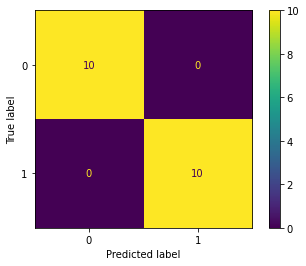

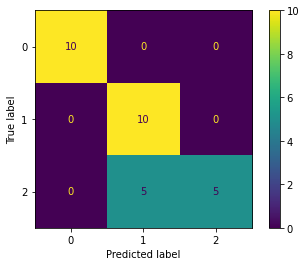

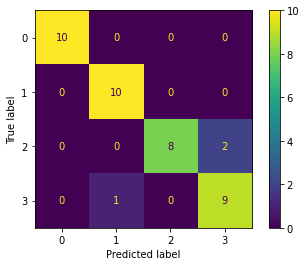

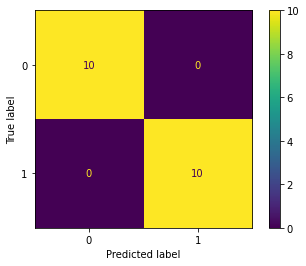

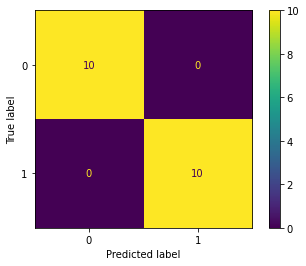

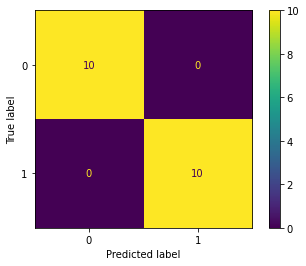

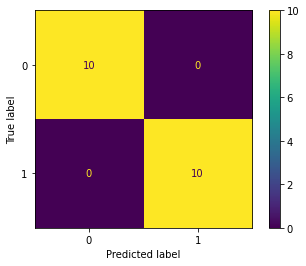

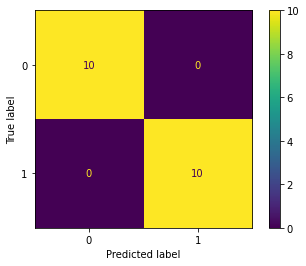

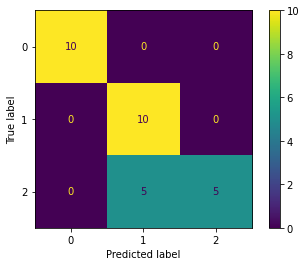

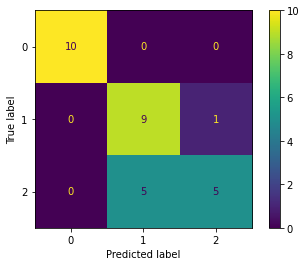

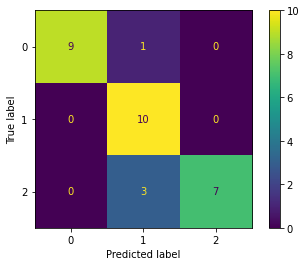

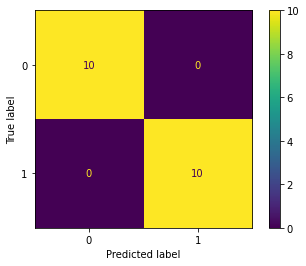

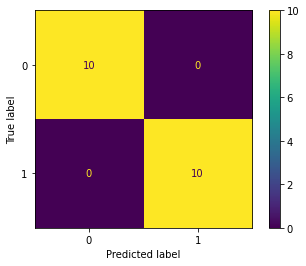

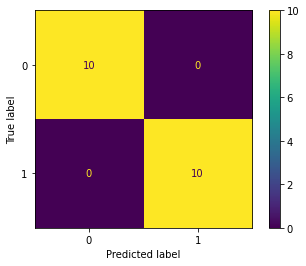

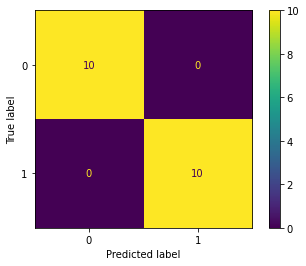

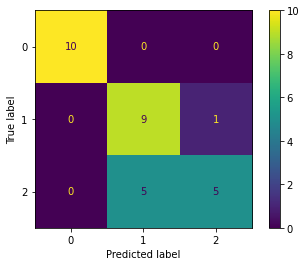

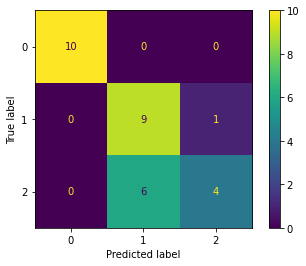

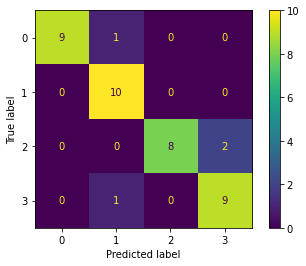

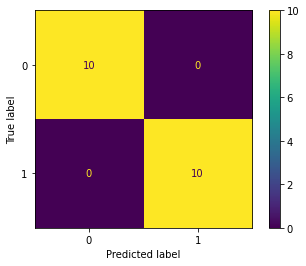

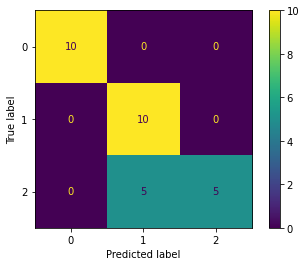

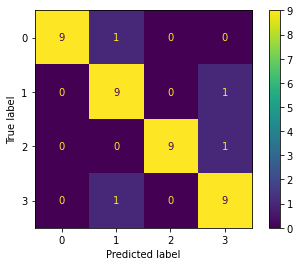

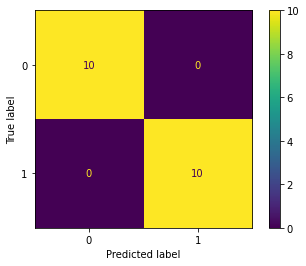

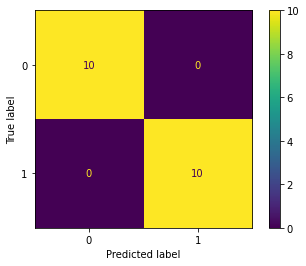

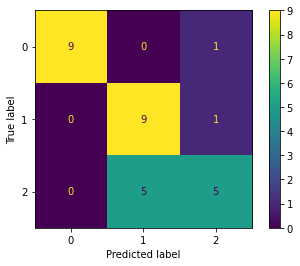

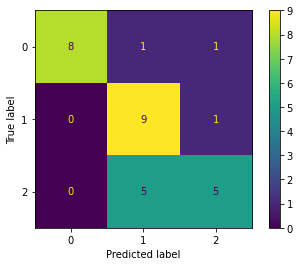

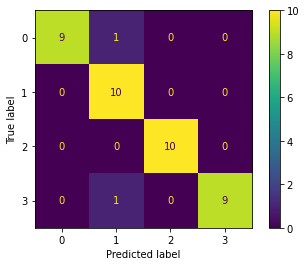

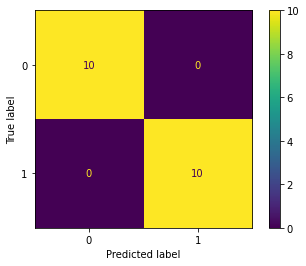

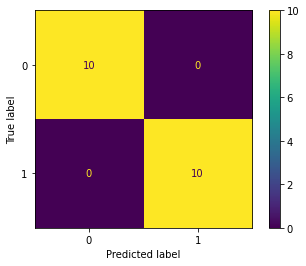

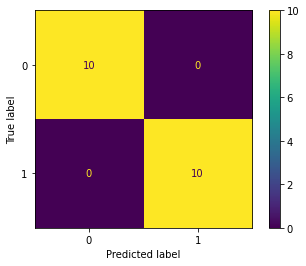

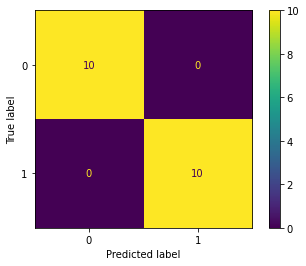

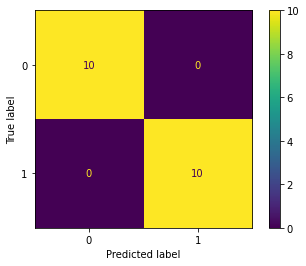

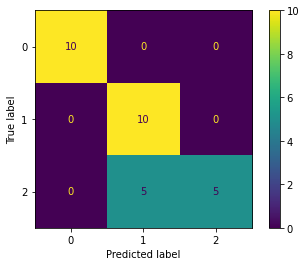

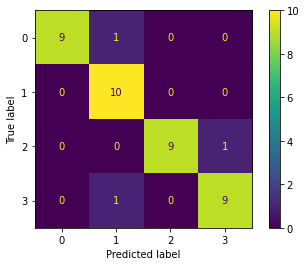

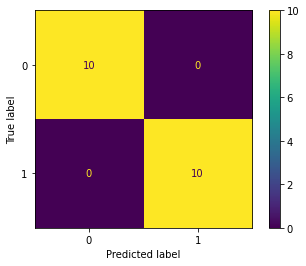

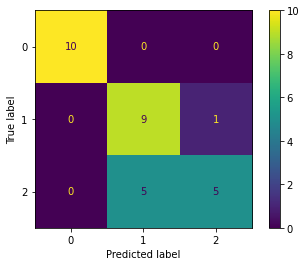

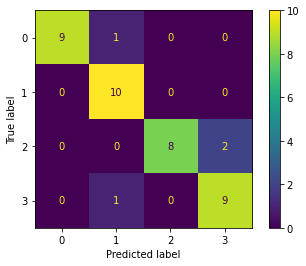

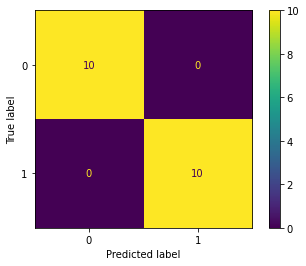

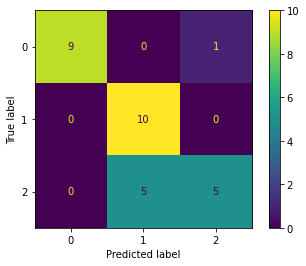

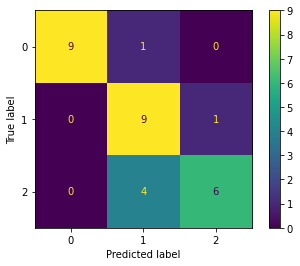

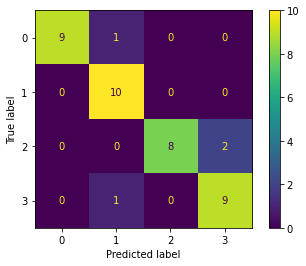

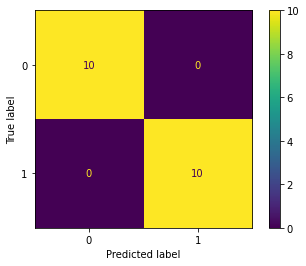

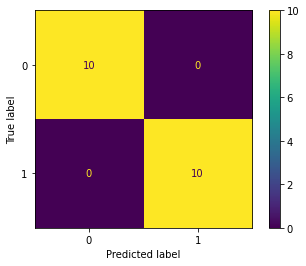

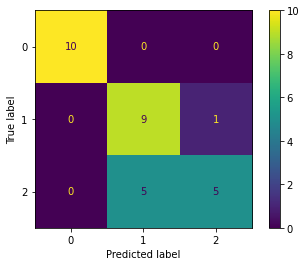

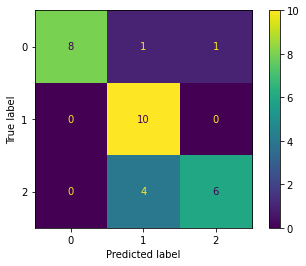

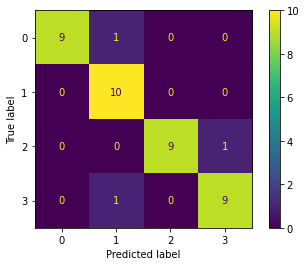

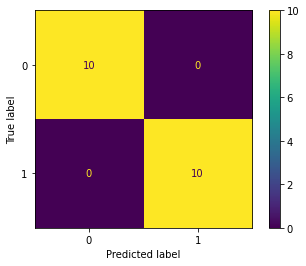

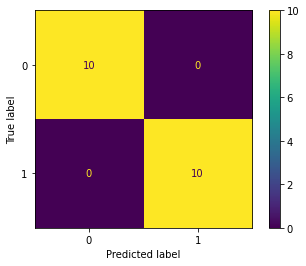

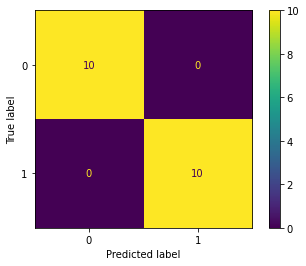

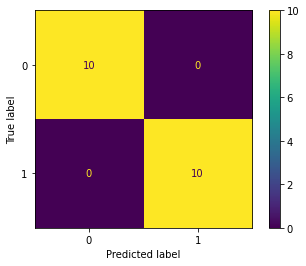

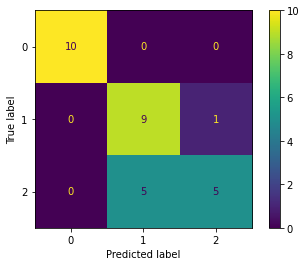

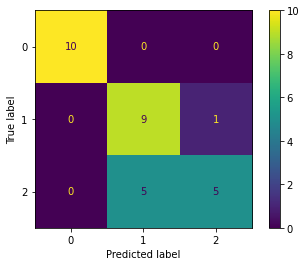

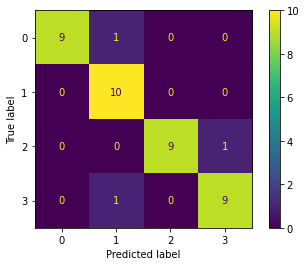

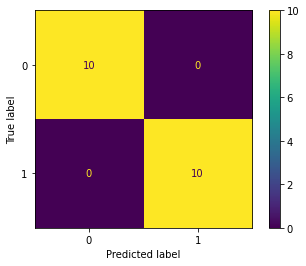

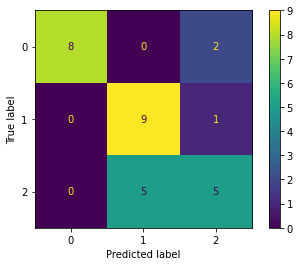

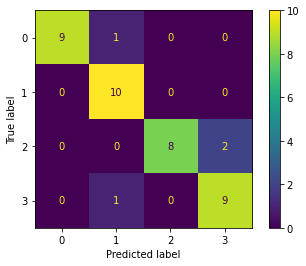

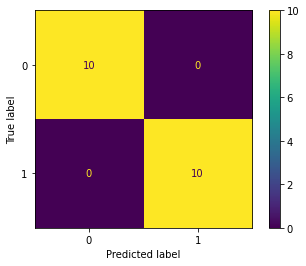

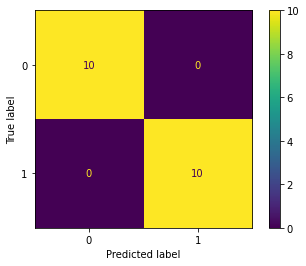

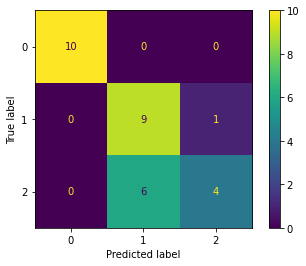

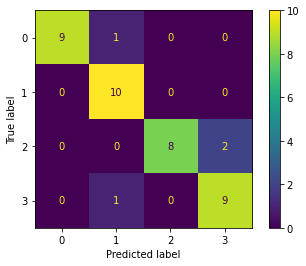

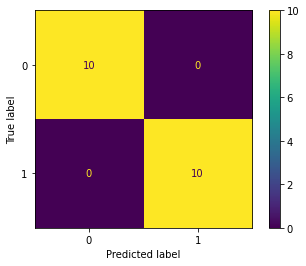

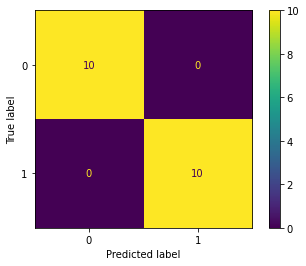

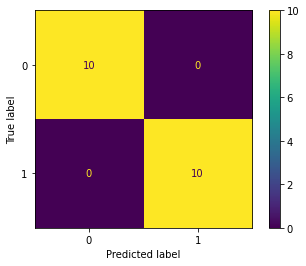

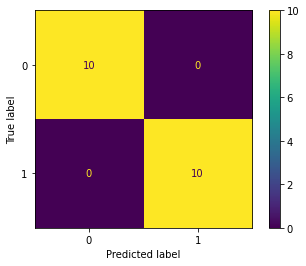

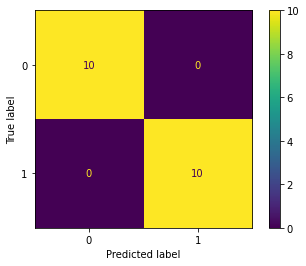

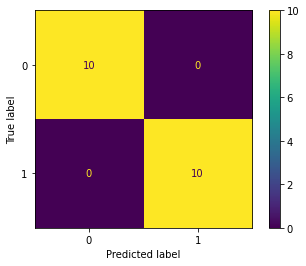

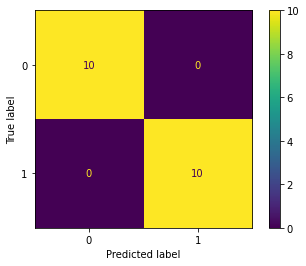

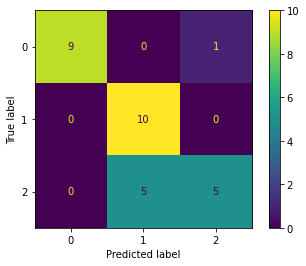

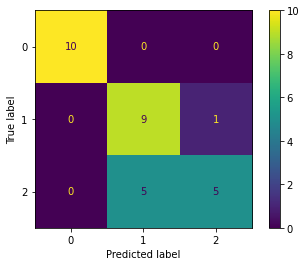

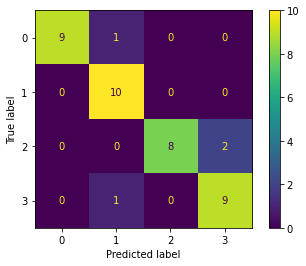

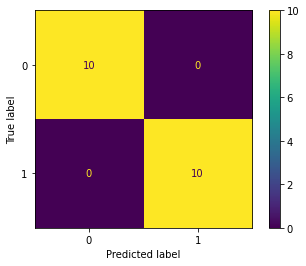

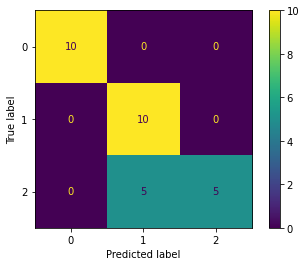

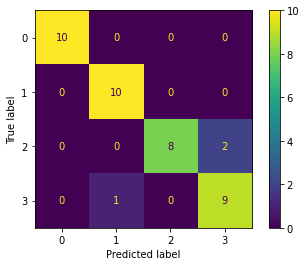

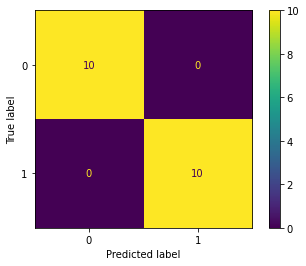

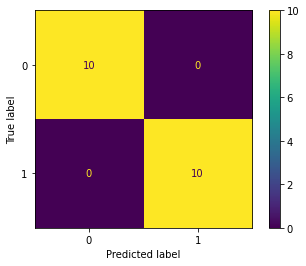

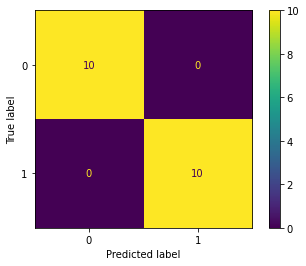

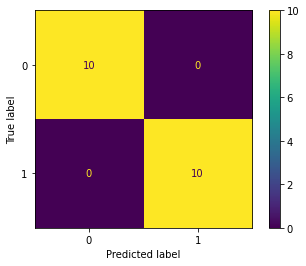

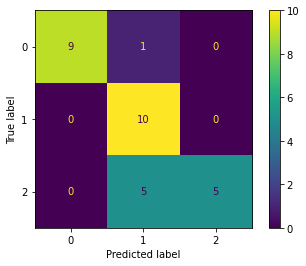

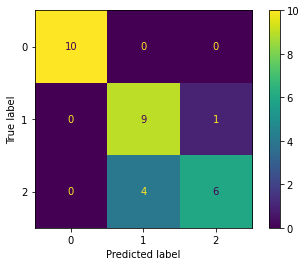

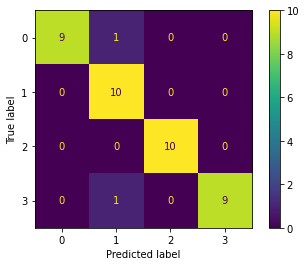

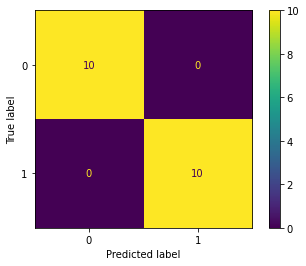

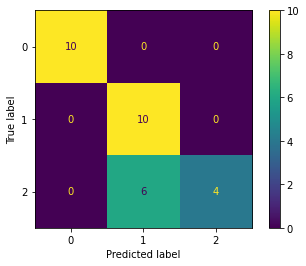

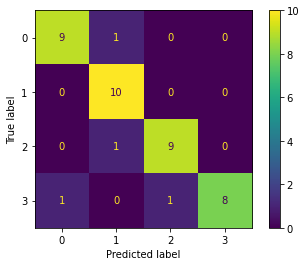

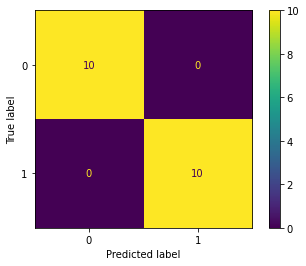

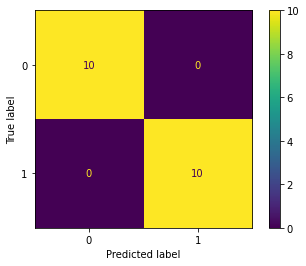

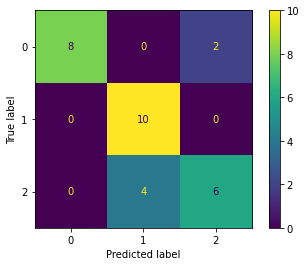

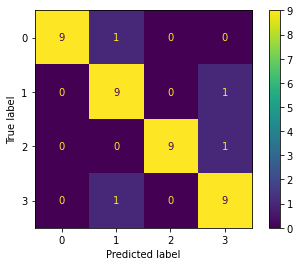

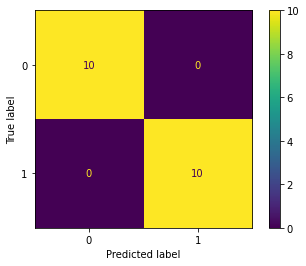

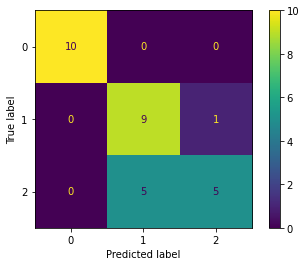

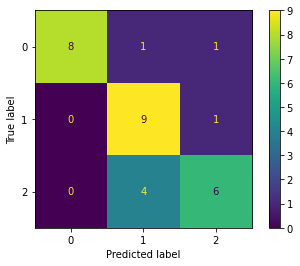

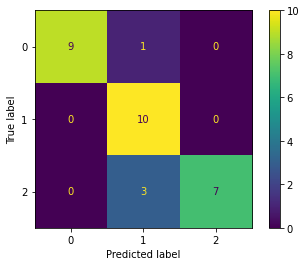

In [37]:
n_exps = 25

ground_truth = [0,1,2,3]

pred_iou = []
for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    known_classes = [0,1]
    known_classes_order = []
    
    model = None
    
    retrains = 0
    while len(known_classes) < len(ground_truth) and retrains < 2:
        print("Known classes:", known_classes)
        known_classes_order.append(known_classes.copy())
        
        #feature_idxs = [*range(3,16),*range(22,28)]
        feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
        #feature_idxs = [*range(3,19),*range(22,28)] # with object position
        Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
        print()

        model = train_classifier(Xtrain, Ttrain, len(known_classes))
        print()

        # check classifier on the test data
        classes, probs = model.use(Xtest)

        # make confusion matrix
        cm = sklearn.metrics.confusion_matrix(Ttest, classes)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()

        novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
        gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
            else float('inf') for i in range(len(dissimilarities))]
        
        gated_dissimilarities = [gated_dissimilarities[i] if gated_dissimilarities[i] == gated_dissimilarities[i] \
            else float('inf') for i in range(len(gated_dissimilarities))]
        
        if np.min(gated_dissimilarities) == float('inf'):
            print("No novel class found")
            retrains += 1
            print("Retraining (%s)" % retrains)
        else:
            new_class = np.argmin(gated_dissimilarities)
            known_classes.append(new_class)
            retrains = 0

            print("Most novel class:", known_classes[-1])
        print()
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, len(known_classes))
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
        else float('inf') for i in range(len(dissimilarities))]
    
    gated_dissimilarities = [gated_dissimilarities[i] if gated_dissimilarities[i] == gated_dissimilarities[i] \
        else float('inf') for i in range(len(gated_dissimilarities))]
    
    if np.min(gated_dissimilarities) != float('inf'):
        new_class = np.argmin(gated_dissimilarities)
        known_classes.append(new_class)
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    print("Order of acquisition:", known_classes_order)

    pred_iou.append(np.intersect1d(known_classes[2:],ground_truth[2:]).shape[0]/\
                    np.union1d(known_classes[2:],ground_truth[2:]).shape[0])
    print(pred_iou,pred_iou[-1])
    print()
    
print(np.sum(pred_iou)/len(pred_iou))

Same as above except not allowing any retraining (effectively constraining this model to the same behavior as models E-H).

========== Experiment 1 ==========
Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.004989683628082275
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 1.5556812286376953e-05
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outli

Angle from sim_mean to sim_mean+std: 0.013485252857208252
Angle from sim_mean to new_mean: 5.960464477539062e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 4.419987182037172e-05
Outlier ratio: 1.9999399109893021
Dissimilarity from most similar class: 0.06531513883202546
Likely novel class: False

Most novel class: 3

Known classes: [0, 1, 3]
(2700, 16) (2700,) (300, 16) (300,)
(270, 160) (270,) (30, 160) (30,)
(270, 1, 160) (270,) (30, 1, 160) (30,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.038
adam: Epoch 100 Loss 0.009
adam: Epoch 150 Loss 0.005
adam: Epoch 200 Loss 0.003
adam: Epoch 250 Loss 0.002
adam: Epoch 300 Loss 0.001
adam: Epoch 350 Loss 0.001
adam: Epoch 400 Loss 0.001
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.021763920783996582
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 4.818666337348785
Dissimilarity from most similar class: 0.6027493233173034
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 2.2709369659423828e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 381.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.010842680931091309
Angle from sim_mean to new_mean: 8.940696716308594e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 8.245835852894288e-05


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 1.9972454094047334
Dissimilarity from most similar class: 0.14989686789722506
Likely novel class: False

No novel class found

Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.00036197900772094727
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.016664326190948486
Angle f

Angle from sim_mean to sim_mean+std: 0.019268512725830078
Angle from sim_mean to new_mean: 0.0002886652946472168
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.014981192308644115
Outlier ratio: 2.037442745267575
Dissimilarity from most similar class: 18.799563216770217
Likely novel class: False

Known classes: [0, 1, 3, 2]
Order of acquisition: [[0, 1], [0, 1, 3], [0, 1, 3], [0, 1, 3, 2]]
[1.0, 1.0, 0.5, 1.0] 1.0

========== Experiment 5 ==========
Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to si

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 5.578597992447021
Dissimilarity from most similar class: 0.9063294525703358
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: -1.1920928955078125e-07
Angle from sim_mean to new_mean: 2.0682811737060547e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: -173.5
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.014329969882965088
Angle from sim_mean to new_mean: 2.384185791015625e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 1.663775856116664e-05


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 1.9999311759708591
Dissimilarity from most similar class: 0.023208551815222196
Likely novel class: False

No novel class found

Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0007969141006469727
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.04419362545013428
Angle fr

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Outlier ratio: 4.851667415162595
Dissimilarity from most similar class: 0.4426988542372188
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 4.8279762268066406e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.01159524917602539
Angle from sim_mean to new_mean: 7.152557373046875e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 6.16852407780565e-05
Outlier ratio: 1.998090769811887
Dissimilarity from most similar class: 0.10418244389173462
Likely novel class: False

No novel class found

Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.001576244831085205
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean

Angle from sim_mean to sim_mean+std: 0.11948341131210327
Angle from sim_mean to new_mean: 0.00030881166458129883
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.002584556811611699
Outlier ratio: 1.1899528599063027
Dissimilarity from most similar class: 2.0056489728874185
Likely novel class: False

Known classes: [0, 1, 3, 2]
Order of acquisition: [[0, 1], [0, 1, 3], [0, 1, 3, 2], [0, 1, 3, 2]]
[1.0, 1.0, 0.5, 1.0, 0.5, 0.5, 1.0] 1.0

========== Experiment 8 ==========
Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle 

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/sklearn/metrics/_plot/confusion_matrix.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Angle from sim_mean to sim_mean+std: 0.011579751968383789
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.00030559301376342773
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 2
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.16261035203933716
Angle from sim_mean to new_mean: 0.9078394025564194
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 5.582912718476886
Outlier ratio: 36.062614106489264
Dissimilarity from most similar class: 19870.67820572637
Likely novel class: True

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.16261035203933716
Angle fro

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 4.819914828466747
Dissimilarity from most similar class: 0.43827063636001273
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: -1.1920928955078125e-07
Angle from sim_mean to new_mean: 1.722574234008789e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: -144.5
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.013778746128082275
Angle from sim_mean to new_mean: 1.7881393432617188e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 1.2977518611924609e-05


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 2.1987531847774378
Dissimilarity from most similar class: 0.020682486462201017
Likely novel class: False

No novel class found

Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0017474889755249023
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.04281485080718994
Angle fr

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Outlier ratio: 4.816833750485446
Dissimilarity from most similar class: 0.4075760497635472
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 2.3126602172851562e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.013257086277008057
Angle from sim_mean to new_mean: 2.980232238769531e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 2.2480296020538e-05
Outlier ratio: 1.9997187782858186
Dissimilarity from most similar class: 0.033841212817842435
Likely novel class: False

No novel class found

Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.002279043197631836
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_me

Angle from sim_mean to sim_mean+std: 0.01198190450668335
Angle from sim_mean to new_mean: 0.0002589225769042969
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.021609467573362254
Outlier ratio: 2.1777334729285958
Dissimilarity from most similar class: 39.653747108534496
Likely novel class: True

Known classes: [0, 1, 3, 4]
Order of acquisition: [[0, 1], [0, 1, 3], [0, 1, 3], [0, 1, 3, 4]]
[1.0, 1.0, 0.5, 1.0, 0.5, 0.5, 1.0, 0.6666666666666666, 0.5, 0.5, 0.3333333333333333] 0.3333333333333333

========== Experiment 12 ==========
Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Ep

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 4.983368517624263
Dissimilarity from most similar class: 0.371682404803277
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: -1.1920928955078125e-07
Angle from sim_mean to new_mean: 3.057718276977539e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: -256.5
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.008804917335510254
Angle from sim_mean to new_mean: 7.152557373046875e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 8.123366864786559e-05


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 1.925394476104482
Dissimilarity from most similar class: 0.15665969639375793
Likely novel class: False

No novel class found

Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0010903477668762207
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.11417269706726074
Angle from

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 4.807758912817089
Dissimilarity from most similar class: 0.45091768438607144
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 3.0338764190673828e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 509.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.012848496437072754
Angle from sim_mean to new_mean: 1.7881393432617188e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 1.3917109694658614e-05


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 1.9999015749481859
Dissimilarity from most similar class: 0.02164268385737558
Likely novel class: False

No novel class found

Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 2.676248550415039e-05
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0003807544708251953
Angle f

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 4.843105754240289
Dissimilarity from most similar class: 0.30340353691829935
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 1.9371509552001953e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 325.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.01100146770477295
Angle from sim_mean to new_mean: 8.344650268554688e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 7.585033645042096e-05


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 1.9973630174987704
Dissimilarity from most similar class: 0.13475297887798843
Likely novel class: False

No novel class found

Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0004011988639831543
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 1
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.015878021717071533
Angle fr

Angle from sim_mean to sim_mean+std: 0.015159547328948975
Angle from sim_mean to new_mean: 0.00024896860122680664
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.01642322134193092
Outlier ratio: 2.106886420778766
Dissimilarity from most similar class: 24.562549805160824
Likely novel class: False

Known classes: [0, 1, 3, 2]
Order of acquisition: [[0, 1], [0, 1, 3], [0, 1, 3], [0, 1, 3, 2]]
[1.0, 1.0, 0.5, 1.0, 0.5, 0.5, 1.0, 0.6666666666666666, 0.5, 0.5, 0.3333333333333333, 1.0, 0.5, 0.5, 0.5, 1.0] 1.0

========== Experiment 17 ==========
Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.003
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.0

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Angle from sim_mean to sim_mean+std: 0.00973200798034668
Angle from sim_mean to new_mean: 1.1920928955078125e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00012249197677552121
Outlier ratio: 5.210397999956219
Dissimilarity from most similar class: 0.5837492284894502
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 3.8623809814453125e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.00973200798034668
Angle from sim_mean to new_mean: 1.6689300537109375e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0001714887674857297
Outlier ratio: 1.980593711319062
Dissimilarity from most similar class: 0.3106553609379905
Likely novel class: False

No novel class found

Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0013648271560668945
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_me

Angle from sim_mean to sim_mean+std: 0.022982895374298096
Angle from sim_mean to new_mean: 0.00034946203231811523
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.015205309280088385
Outlier ratio: 2.231012957753894
Dissimilarity from most similar class: 14.798625540269862
Likely novel class: False

Known classes: [0, 1, 3]
Order of acquisition: [[0, 1], [0, 1, 3], [0, 1, 3], [0, 1, 3]]
[1.0, 1.0, 0.5, 1.0, 0.5, 0.5, 1.0, 0.6666666666666666, 0.5, 0.5, 0.3333333333333333, 1.0, 0.5, 0.5, 0.5, 1.0, 0.5, 0.5] 0.5

========== Experiment 19 ==========
Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Los

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Angle from sim_mean to sim_mean+std: 0.010902702808380127
Angle from sim_mean to new_mean: 2.562999725341797e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0002350792982609599
Outlier ratio: 4.834765689808673
Dissimilarity from most similar class: 1.022298136318589
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 4.875659942626953e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.010902702808380127
Angle from sim_mean to new_mean: 9.5367431640625e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 8.747136679477578e-05
Outlier ratio: 1.994736610150934
Dissimilarity from most similar class: 0.15694201461215174
Likely novel class: False

No novel class found

Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0030138492584228516
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle fr

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/n

Angle from sim_mean to sim_mean+std: 0.012296080589294434
Angle from sim_mean to new_mean: 2.384185791015625e-06
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.00019389802902653494
Outlier ratio: 4.833823978617298
Dissimilarity from most similar class: 0.7533162662281911
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 0.0
Angle from sim_mean to new_mean: 7.37309455871582e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: inf
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.012296080589294434
Angle from sim_mean to new_mean: 7.748603820800781e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 6.301685943362386e-05
Outlier ratio: 1.99836315737063
Dissimilarity from most similar class: 0.10121486232323197
Likely novel class: False

No novel class found

Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.001
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.0005913972854614258
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_me

Outlier ratio: 3.064258158500958
Dissimilarity from most similar class: 54.33383071344222
Likely novel class: True

New class: 3
Most similar class: 3
Angle from sim_mean to sim_mean+std: 0.19863373041152954
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0
Outlier ratio: 1.0
Dissimilarity from most similar class: 0.0
Likely novel class: False

New class: 4
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.018042266368865967
Angle from sim_mean to new_mean: 0.0002976655960083008
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.016498237523083988
Outlier ratio: 2.0758630438495205
Dissimilarity from most similar class: 25.274270077455427
Likely novel class: True

Known classes: [0, 1, 3, 4]
Order of acquisition: [[0, 1], [0, 1, 3], [0, 1, 3], [0, 1, 3, 4]]
[1.0, 1.0, 0.5, 1.0, 0.5, 0.5, 1.0, 0.6666666666666666, 0.5, 0.5, 0.3333333333333333, 1.0, 0.5, 0.5, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5, 0.333333333

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 4.822900700977195
Dissimilarity from most similar class: 0.3796526587298574
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 2.5510787963867188e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 428.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.011921405792236328
Angle from sim_mean to new_mean: 5.960464477539062e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 4.99980000799968e-05
Outlier ratio: 1.9996800109436084
Dissimilarity from most similar class: 0.08284857248164373
Likely novel class: False

No novel class found

Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.00034415721893310547
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_

/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars
/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars


Outlier ratio: 4.874783513355983
Dissimilarity from most similar class: 1.5396488067271552
Likely novel class: False

New class: 3
Most similar class: 1
Angle from sim_mean to sim_mean+std: 5.960464477539063e-08
Angle from sim_mean to new_mean: 5.924701690673828e-05
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 994.0
Outlier ratio: inf
Dissimilarity from most similar class: nan
Likely novel class: True

New class: 4
Most similar class: 0


/Users/nikhil/Documents/Dev/trunk/BabyVW/ml-agents/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


Angle from sim_mean to sim_mean+std: 0.011723935604095459
Angle from sim_mean to new_mean: 2.384185791015625e-07
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 2.0336053280459593e-05
Outlier ratio: 1.999795376353916
Dissimilarity from most similar class: 0.034608998113872934
Likely novel class: False

No novel class found

Known classes: [0, 1]
(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000

New class: 0
Most similar class: 0
Angle from sim_mean to sim_mean+std: 0.001175999641418457
Angle from sim_mean to new_mean: 0.0
Angle from sim_mean to new_mean/Angle from sim_mean to sim_

Angle from sim_mean to sim_mean+std: 0.20349401235580444
Angle from sim_mean to new_mean: 0.0003643035888671875
Angle from sim_mean to new_mean/Angle from sim_mean to sim_mean+std: 0.0017902423007425464
Outlier ratio: 1.1300433009878486
Dissimilarity from most similar class: 1.1324002020730124
Likely novel class: False

Known classes: [0, 1, 3, 2]
Order of acquisition: [[0, 1], [0, 1, 3], [0, 1, 3, 2], [0, 1, 3, 2]]
[1.0, 1.0, 0.5, 1.0, 0.5, 0.5, 1.0, 0.6666666666666666, 0.5, 0.5, 0.3333333333333333, 1.0, 0.5, 0.5, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5, 0.3333333333333333, 0.5, 0.5, 1.0] 1.0

========== Experiment 25 ==========
Known classes: [0, 1]
(1800, 16) (1800,) (200, 16) (200,)
(180, 160) (180,) (20, 160) (20,)
(180, 1, 160) (180,) (20, 1, 160) (20,)

CUDA not available. Defaulting to CPU.
160 16 8 19
19 4 2 8
adam: Epoch 50 Loss 0.002
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Los

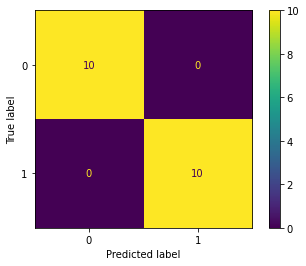

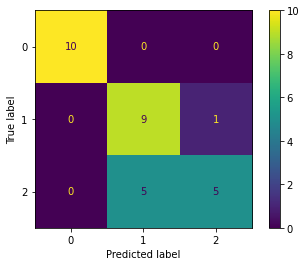

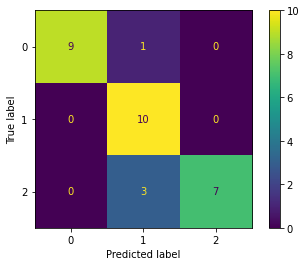

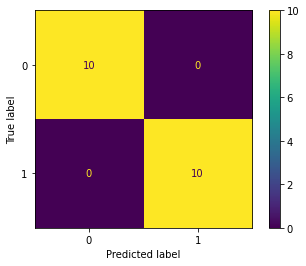

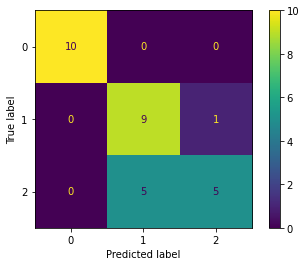

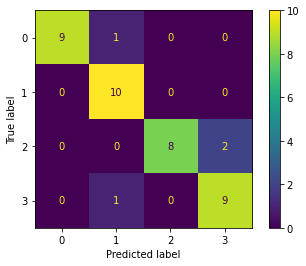

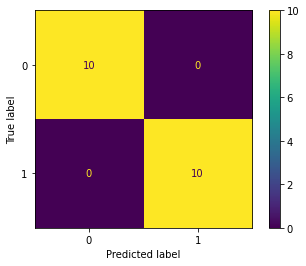

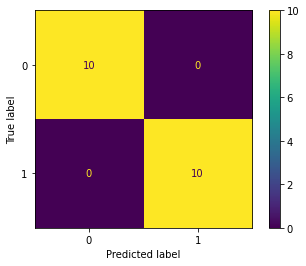

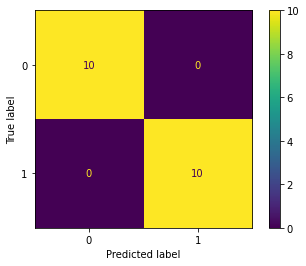

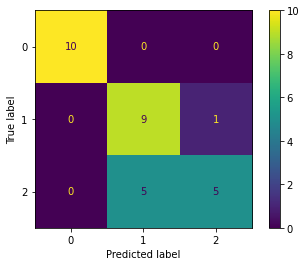

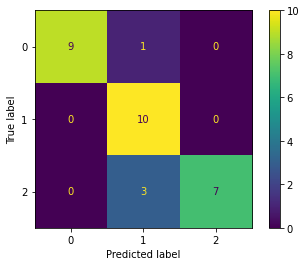

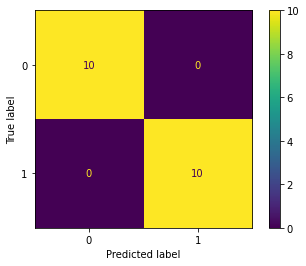

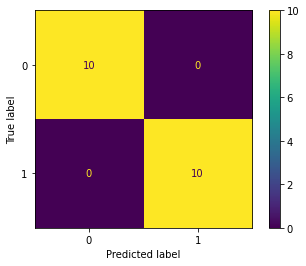

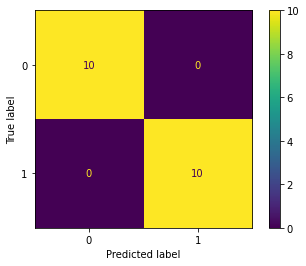

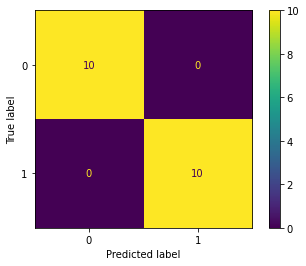

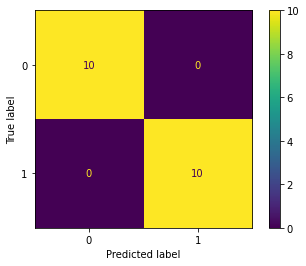

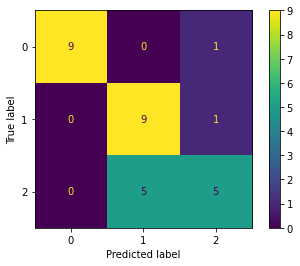

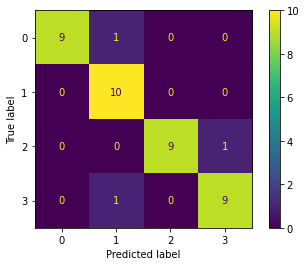

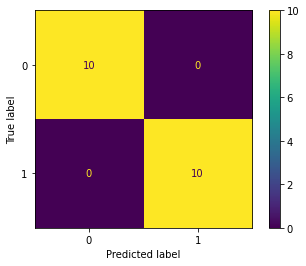

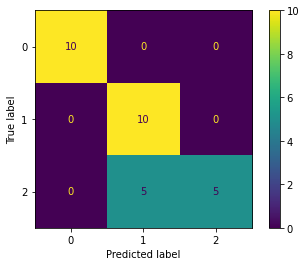

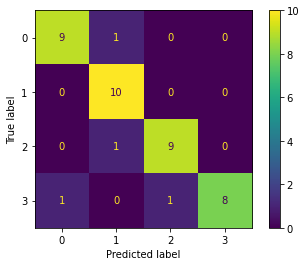

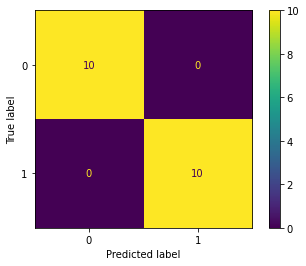

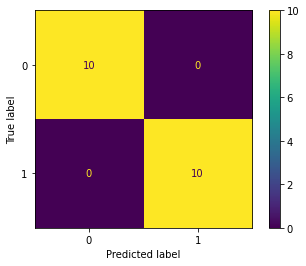

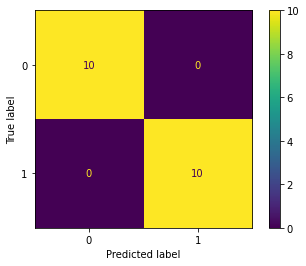

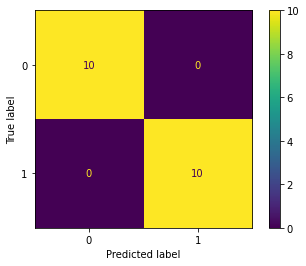

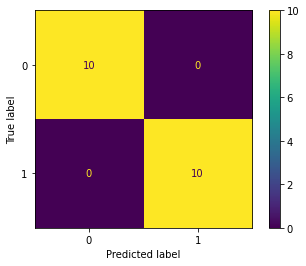

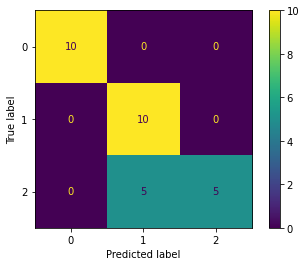

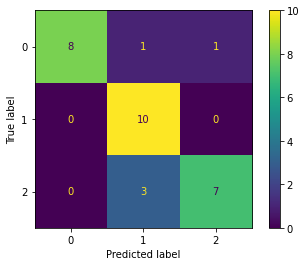

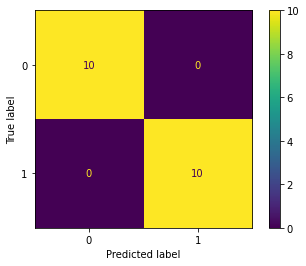

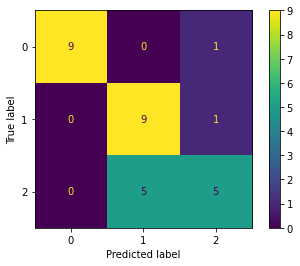

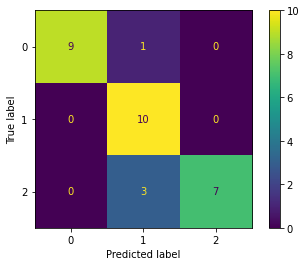

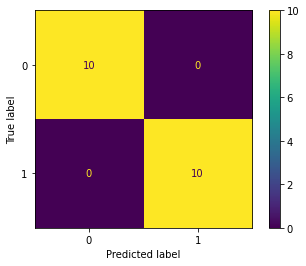

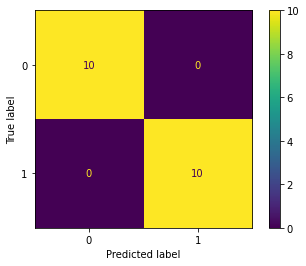

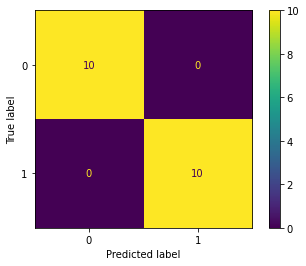

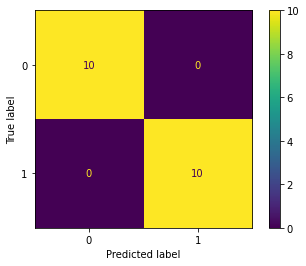

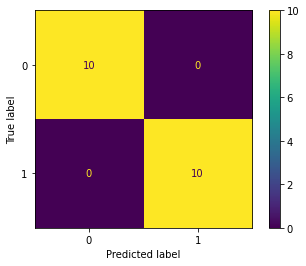

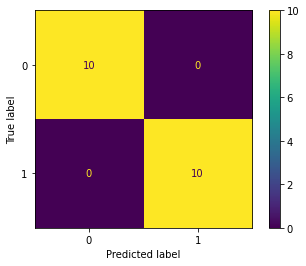

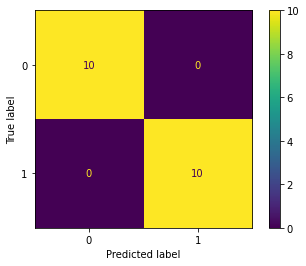

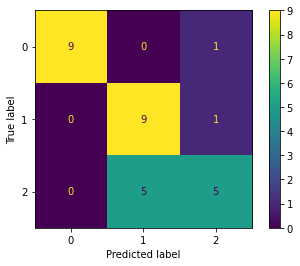

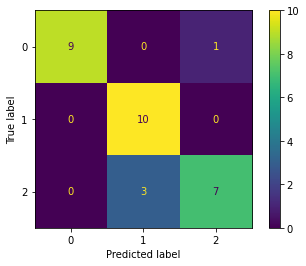

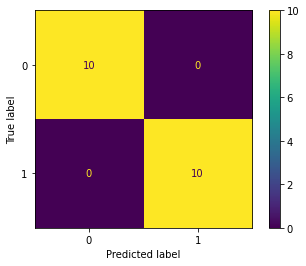

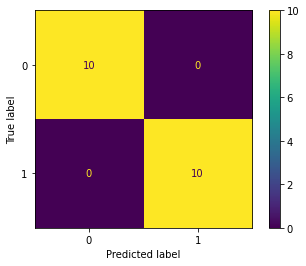

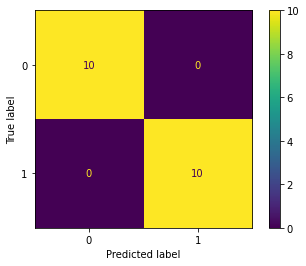

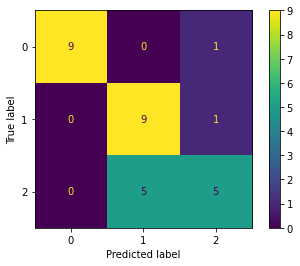

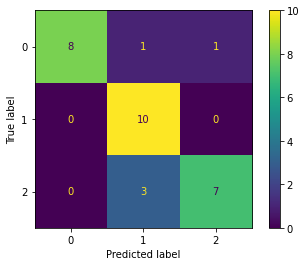

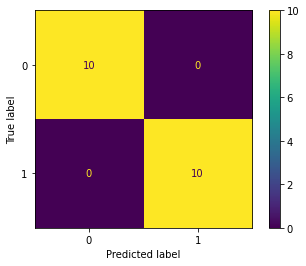

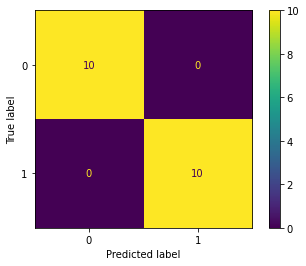

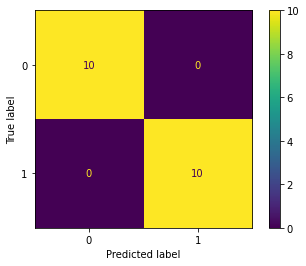

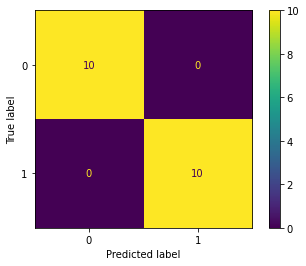

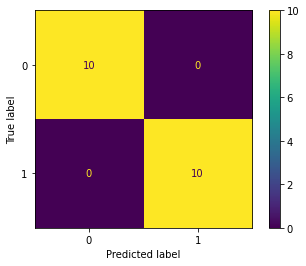

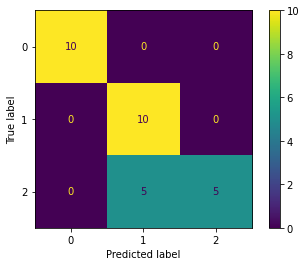

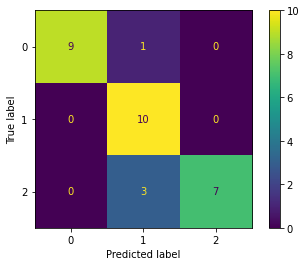

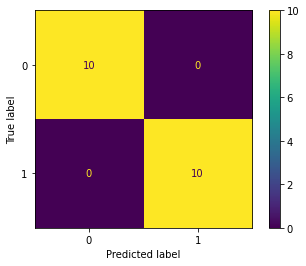

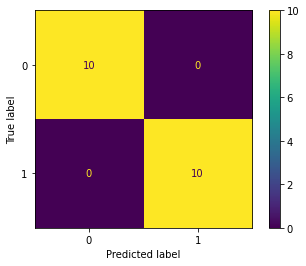

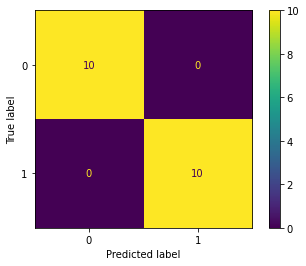

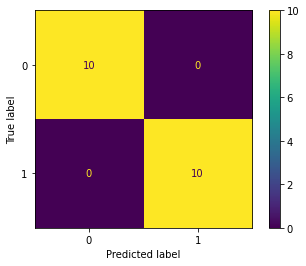

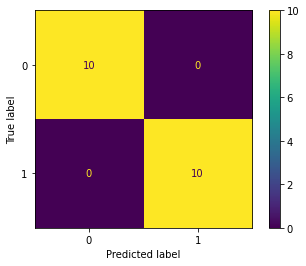

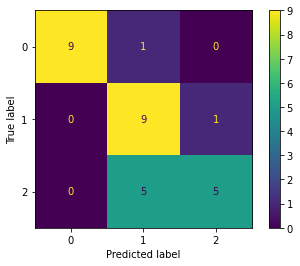

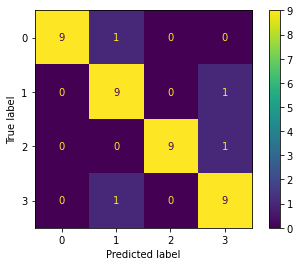

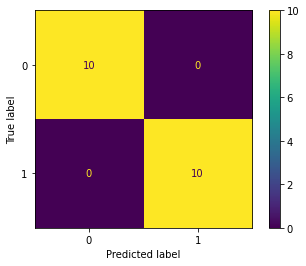

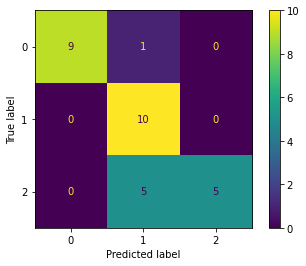

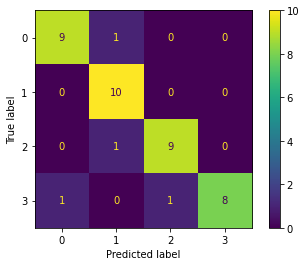

In [38]:
n_exps = 25

ground_truth = [0,1,2,3]

pred_iou = []
for i in range(n_exps):
    print("========== Experiment %s ==========" % str(i+1))
    known_classes = [0,1]
    known_classes_order = []
    
    model = None
    
    retrains = 0
    while len(known_classes) < len(ground_truth) and retrains < 1:
        print("Known classes:", known_classes)
        known_classes_order.append(known_classes.copy())
        
        #feature_idxs = [*range(3,16),*range(22,28)]
        feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
        #feature_idxs = [*range(3,19),*range(22,28)] # with object position
        Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
        print()

        model = train_classifier(Xtrain, Ttrain, len(known_classes))
        print()

        # check classifier on the test data
        classes, probs = model.use(Xtest)

        # make confusion matrix
        cm = sklearn.metrics.confusion_matrix(Ttest, classes)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()

        novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
        gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
            else float('inf') for i in range(len(dissimilarities))]
        
        gated_dissimilarities = [gated_dissimilarities[i] if gated_dissimilarities[i] == gated_dissimilarities[i] \
            else float('inf') for i in range(len(gated_dissimilarities))]
        
        if np.min(gated_dissimilarities) == float('inf'):
            print("No novel class found")
            retrains += 1
            #print("Retraining (%s)" % retrains)
        else:
            new_class = np.argmin(gated_dissimilarities)
            known_classes.append(new_class)
            retrains = 0

            print("Most novel class:", known_classes[-1])
        print()
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    feature_idxs = [*range(3,16),*range(22,28)]
    #feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
    #feature_idxs = [*range(3,19),*range(22,28)] # with object position
    Xtrain, Ttrain, Xtest, Ttest = make_train_test_data(known_classes, crop_len, feature_idxs)
    print()

    model = train_classifier(Xtrain, Ttrain, len(known_classes))
    print()

    # check classifier on the test data
    classes, probs = model.use(Xtest)

    # make confusion matrix
    cm = sklearn.metrics.confusion_matrix(Ttest, classes)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    novel_classes, dissimilarities = compare_classes(model, Xtrain.shape[-1]//10)
    gated_dissimilarities = [dissimilarities[i] if novel_classes[i] == True \
        else float('inf') for i in range(len(dissimilarities))]
    
    gated_dissimilarities = [gated_dissimilarities[i] if gated_dissimilarities[i] == gated_dissimilarities[i] \
        else float('inf') for i in range(len(gated_dissimilarities))]
    
    if np.min(gated_dissimilarities) != float('inf'):
        new_class = np.argmin(gated_dissimilarities)
        known_classes.append(new_class)
        
    print("Known classes:", known_classes)
    known_classes_order.append(known_classes.copy())
    
    print("Order of acquisition:", known_classes_order)

    pred_iou.append(np.intersect1d(known_classes[2:],ground_truth[2:]).shape[0]/\
                    np.union1d(known_classes[2:],ground_truth[2:]).shape[0])
    print(pred_iou,pred_iou[-1])
    print()
    
print(np.sum(pred_iou)/len(pred_iou))